<a href="https://colab.research.google.com/github/sergeiredkin/moex_scoring/blob/main/moex_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install apimoex

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

log_path = "/content/drive/MyDrive/portfolio_metrics_log.csv"

MessageError: Error: credential propagation was unsuccessful

In [6]:
import requests
import apimoex          # pip install apimoex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.style.use("default")
sns.set_palette("viridis")
%matplotlib inline

# -------------------------------------------------
# ПАРАМЕТРЫ ПЕРИОДА
# -------------------------------------------------
FROM_DATE = "2020-01-01"
TILL_DATE = "2026-12-31"


# -------- ВСЕЛЕННАЯ ТИКЕРОВ (60+ ШТ.) --------
tickers = [
    "SBER", "GAZP", "LKOH", "GMKN", "NVTK",
    "ROSN", "TATN", "MDMG", "MTSS", "MGNT",
    "CHMF", "PLZL", "YDEX", "MOEX", "TRNFP",
    "MRKP", "LSNGP", "SNGSP", "HEAD","RASP",
    "SFIN", "SMLT", "DIAS", "SVCB", "FEES",
    "FLOT", "BELU", "SPBE", "IVAT", "KAZTP",
    "RENI", "ASTR", "PHOR", "POSI", "LEAS",
    "OZON", "RTKMP", "WUSH", "X5",
    "NLMK", "SOFL", "MAGN", "CNRU", "ALRS",
    "IRAO", "SIBN", "BSPB",  "T",   "NMTP",
	  "SVET", "OKEY", "VTBR", "AQUA","FESH",
	  "SELG", "KAZT","GCHE", "FESH", "NKNC",
    "OZPH", "MBNK", "ELMT", "LENT", "RAGR",
    "HNFG", "ZAYM", "DATA", "MGKL", "MRKU"
]

#, "DOMRF"

print("🎯 Вселенная тикеров для анализа:")
print(tickers)


# -------------------------------------------------
# ФУНКЦИЯ ЗАГРУЗКИ ИСТОРИИ АКЦИИ
# -------------------------------------------------
def load_moex_history(secid, board="TQBR",
                      from_date=FROM_DATE, till_date=TILL_DATE):
    """
    История дневных котировок для бумаги secid в режиме board.
    Обрезает результат по from_date..till_date.
    Вызов адаптирован под сигнатуру get_board_history(session, security, board).
    """
    with requests.Session() as session:
        # ВАЖНО: без secid=, тикер передаётся позиционно
        data = apimoex.get_board_history(session, secid, board)

    df = pd.DataFrame(data)
    if "TRADEDATE" not in df.columns or "CLOSE" not in df.columns:
        raise KeyError(f"{secid}: нет TRADEDATE/CLOSE, есть колонки: {df.columns}")

    df["TRADEDATE"] = pd.to_datetime(df["TRADEDATE"])
    df = df.set_index("TRADEDATE").sort_index()
    df = df.loc[from_date:till_date]

    return df


def load_imoex_history(from_date=FROM_DATE, till_date=TILL_DATE):
    """
    История дневных значений индекса IMOEX через ISSClient /history.
    Обрезает по from_date..till_date.
    """
    with requests.Session() as session:
        client = apimoex.ISSClient(
            session,
            "https://iss.moex.com/iss/history/engines/stock/markets/index/securities/IMOEX.json"
        )
        rows = list(client)

    all_rows = []
    for page in rows:
        all_rows.extend(page.get("history", []))

    df = pd.DataFrame(all_rows)
    if "TRADEDATE" not in df.columns or "CLOSE" not in df.columns:
        raise KeyError(f"IMOEX: нет TRADEDATE/CLOSE, есть: {df.columns}")

    df["TRADEDATE"] = pd.to_datetime(df["TRADEDATE"])
    df = df.set_index("TRADEDATE").sort_index()
    df = df.loc[from_date:till_date]

    return df["CLOSE"]


def load_rvi_history(from_date="2020-01-01", till_date="2025-12-31"):
    """
    История дневных значений индекса волатильности RVI (Russian Volatility Index).
    Берём EOD-значения через ISS history по тикеру RVI.
    """
    with requests.Session() as session:
        client = apimoex.ISSClient(
            session,
            "https://iss.moex.com/iss/history/engines/stock/markets/index/securities/RVI.json"
        )
        rows = list(client)

    all_rows = []
    for page in rows:
        all_rows.extend(page.get("history", []))

    df = pd.DataFrame(all_rows)
    if "TRADEDATE" not in df.columns or "CLOSE" not in df.columns:
        raise KeyError(f"RVI: нет TRADEDATE/CLOSE, есть: {df.columns}")

    df["TRADEDATE"] = pd.to_datetime(df["TRADEDATE"])
    df = df.set_index("TRADEDATE").sort_index()
    df = df.loc[from_date:till_date]

    return df["CLOSE"]


# -------- ЗАГРУЗКА АКЦИЙ --------
prices_dict = {}
for t in tickers:
    try:
        moex_df = load_moex_history(t)
        if len(moex_df) == 0:
            print(f"⚠️ {t}: пустая история после обрезки по датам")
            continue
        prices_dict[t] = moex_df["CLOSE"]
        print(f"✅ {t}: {len(moex_df)} точек, {moex_df.index.min().date()} → {moex_df.index.max().date()}")
    except Exception as e:
        print(f"⚠️ {t}: ошибка загрузки: {e}")

data = pd.DataFrame(prices_dict).sort_index()

if data.empty:
    raise RuntimeError("После загрузки все тикеры пустые — проверь сигнатуру get_board_history и даты FROM_DATE/TILL_DATE")

data = data.loc[FROM_DATE:TILL_DATE]

print("\nИтоговый календарь акций:")
print(data.index.min().date(), "→", data.index.max().date())
print("Число дат:", len(data))


# -------- ЗАГРУЗКА ИНДЕКСА IMOEX --------
idx_prices = load_imoex_history(FROM_DATE, TILL_DATE)
idx_prices = idx_prices.reindex(data.index)

print(f"\n✅ IMOEX: {len(idx_prices)} точек, {idx_prices.index.min().date()} → {idx_prices.index.max().date()}")

# -------- ЗАГРУЗКА ИНДЕКСА ВОЛАТИЛЬНОСТИ RVI --------
rvi_series = load_rvi_history(FROM_DATE, TILL_DATE)
rvi_series = rvi_series.reindex(data.index)

print(f"\n✅ RVI: {len(rvi_series)} точек, {rvi_series.index.min().date()} → {rvi_series.index.max().date()}")


# -------- ДОХОДНОСТИ --------
returns = data.pct_change()
idx_returns = idx_prices.pct_change()

print("\n=== Анализ акций MOEX (apimoex + ISSClient) ===")
print(f"Период: {returns.index[0].date()} - {returns.index[-1].date()}")
print(f"Размер выборки: {len(returns)} наблюдений")
print(f"Анализируем тикеры: {list(returns.columns)}")




🎯 Вселенная тикеров для анализа:
['SBER', 'GAZP', 'LKOH', 'GMKN', 'NVTK', 'ROSN', 'TATN', 'MDMG', 'MTSS', 'MGNT', 'CHMF', 'PLZL', 'YDEX', 'MOEX', 'TRNFP', 'MRKP', 'LSNGP', 'SNGSP', 'HEAD', 'RASP', 'SFIN', 'SMLT', 'DIAS', 'SVCB', 'FEES', 'FLOT', 'BELU', 'SPBE', 'IVAT', 'KAZTP', 'RENI', 'ASTR', 'PHOR', 'POSI', 'LEAS', 'OZON', 'RTKMP', 'WUSH', 'X5', 'NLMK', 'SOFL', 'MAGN', 'CNRU', 'ALRS', 'IRAO', 'SIBN', 'BSPB', 'T', 'NMTP', 'SVET', 'OKEY', 'VTBR', 'AQUA', 'FESH', 'SELG', 'KAZT', 'GCHE', 'FESH', 'NKNC', 'OZPH', 'MBNK', 'ELMT', 'LENT', 'RAGR', 'HNFG', 'ZAYM', 'DATA', 'MGKL', 'MRKU']
✅ SBER: 1523 точек, 2020-01-03 → 2026-01-06
✅ GAZP: 1523 точек, 2020-01-03 → 2026-01-06
✅ LKOH: 1523 точек, 2020-01-03 → 2026-01-06
✅ GMKN: 1523 точек, 2020-01-03 → 2026-01-06
✅ NVTK: 1523 точек, 2020-01-03 → 2026-01-06
✅ ROSN: 1523 точек, 2020-01-03 → 2026-01-06
✅ TATN: 1523 точек, 2020-01-03 → 2026-01-06
✅ MDMG: 1311 точек, 2020-11-09 → 2026-01-06
✅ MTSS: 1523 точек, 2020-01-03 → 2026-01-06
✅ MGNT: 1523 точек

In [7]:
# ============================================================
# 📊 ИНТЕРАКТИВНЫЙ АНАЛИЗАТОР SHARPE С ВИДЖЕТАМИ
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display, clear_output

# %% Функции расчёта
def calculate_sharpe_ratio(returns_series, risk_free_rate=0.0):
    if len(returns_series) < 5:
        return 0.0
    excess = returns_series - (risk_free_rate / 252)
    mean_ret = excess.mean()
    std_ret = excess.std()
    return (mean_ret * np.sqrt(252)) / std_ret if std_ret != 0 else 0.0

def calculate_rolling_sharpe(prices, windows=[14, 30, 90, 180]):
    """Добавлен 14-дневный (2 недели) Sharpe"""
    rets = prices.pct_change().dropna()
    results = pd.DataFrame(index=rets.index)

    for window in windows:
        sharpe_vals = []
        for i in range(len(rets)):
            if i < window - 1:
                sharpe_vals.append(np.nan)
            else:
                sharpe = calculate_sharpe_ratio(rets.iloc[i-window+1:i+1])
                sharpe_vals.append(sharpe)
        results[f"sharpe_{window}d"] = sharpe_vals
    return results.dropna()

def calculate_stability_cv(sharpe_series):
    s = sharpe_series.dropna()
    if len(s) < 5:
        return {'cv': np.nan, 'stability': np.nan, 'mean': np.nan, 'std': np.nan}

    mean_s, std_s = s.mean(), s.std()

    if abs(mean_s) < 0.01:
        stab = 70.0 if std_s < 0.5 else 30.0
        cv = np.nan
    else:
        cv = abs(std_s / mean_s)
        if cv < 0.15:
            stab = 90.0 + (0.15 - cv) * 66.7
        elif cv < 0.5:
            stab = 50.0 + (0.5 - cv) * 114.3
        elif cv < 1.0:
            stab = 20.0 + (1.0 - cv) * 60.0
        else:
            stab = max(5.0, 20.0 - (cv - 1.0) * 10.0)

    return {'cv': cv, 'stability': min(100, max(0, stab)), 'mean': mean_s, 'std': std_s}

def detect_degradation(sharpe_df, window=30, threshold=-0.3):
    col = f"sharpe_{window}d"
    if col not in sharpe_df.columns:
        return pd.DataFrame()

    series = sharpe_df[col]
    mask = series < threshold
    periods, in_deg, start = [], False, None

    for date, degraded in mask.items():
        if degraded and not in_deg:
            start, in_deg = date, True
        elif not degraded and in_deg:
            periods.append({
                'start': start, 'end': date,
                'days': (date - start).days,
                'min_sharpe': series[start:date].min()
            })
            in_deg = False
    return pd.DataFrame(periods)

# %% ГРАФИК (без изменений)
def plot_price_and_sharpe(ticker, prices, sharpe_df, windows=[14, 30, 90, 180]):
    """График на matplotlib с поддержкой 2-недельного Sharpe"""

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    fig.suptitle(f'📊 Анализ динамики Sharpe для {ticker}', fontsize=16, fontweight='bold')

    # График 1: Цены
    ax1.plot(prices.index, prices.values, linewidth=2, color='#2E86C1', label='Цена')
    ax1.set_ylabel('Цена, ₽', fontsize=12, fontweight='bold')
    ax1.set_title(f'{ticker} — Цена закрытия', fontsize=13)
    ax1.legend(loc='upper left', fontsize=11)
    ax1.grid(True, alpha=0.3, linestyle='--')

    # График 2: Скользящий Sharpe
    colors = {14: '#9B59B6', 30: '#27AE60', 90: '#F39C12', 180: '#E74C3C'}
    labels = {14: '2 недели (14д)', 30: '1 месяц (30д)', 90: '3 месяца (90д)', 180: '6 месяцев (180д)'}

    for w in windows:
        col = f"sharpe_{w}d"
        if col in sharpe_df.columns:
            ax2.plot(sharpe_df.index, sharpe_df[col],
                    linewidth=2.5, color=colors[w], label=labels[w], alpha=0.9)

    # Пороговые линии
    ax2.axhline(1.0, linestyle='--', color='green', alpha=0.6, linewidth=1.5, label='Sharpe = 1.0 (хорошо)')
    ax2.axhline(0.0, linestyle='--', color='gray', alpha=0.6, linewidth=1.5, label='Sharpe = 0.0')
    ax2.axhline(-0.5, linestyle='--', color='red', alpha=0.6, linewidth=1.5, label='Sharpe = -0.5 (плохо)')

    ax2.set_xlabel('Дата', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
    ax2.set_title('Скользящий Sharpe Ratio', fontsize=13)
    ax2.legend(loc='upper left', fontsize=10, ncol=2)
    ax2.grid(True, alpha=0.3, linestyle='--')

    # Форматирование дат
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# %% Анализ тикера (без изменений логики, поддержка 4 окон)
def analyze_ticker(ticker, windows=[14, 30, 90, 180]):
    """Полный анализ с поддержкой 2 недель"""

    if ticker not in data.columns:
        print(f"❌ Тикер {ticker} не найден в data!")
        return

    prices = data[ticker].dropna()

    print(f"\n{'='*70}")
    print(f"📊 АНАЛИЗ ТИКЕРА: {ticker}")
    print(f"{'='*70}")
    print(f"📅 Период: {prices.index.min().date()} → {prices.index.max().date()}")
    print(f"📈 Данных: {len(prices)} дней\n")

    # Расчёт
    print("🔄 Рассчитываю скользящий Sharpe Ratio...")
    sharpe_df = calculate_rolling_sharpe(prices, windows)
    print(f"✅ Готово: {len(sharpe_df)} значений\n")

    # Стабильность
    print("📊 СТАБИЛЬНОСТЬ SHARPE:")
    print("-" * 70)
    for w in windows:
        stats = calculate_stability_cv(sharpe_df[f"sharpe_{w}d"])
        label = {14: '2нед', 30: '1мес', 90: '3мес', 180: '6мес'}[w]
        print(f"  {label:>4s} ({w:3d}д): CV={stats['cv']:>5.2f} | "
              f"Стабильность={stats['stability']:>5.0f}% | "
              f"Mean={stats['mean']:>6.2f} | Std={stats['std']:>5.2f}")

    # Деградация
    print(f"\n📉 ПЕРИОДЫ ДЕГРАДАЦИИ (Sharpe < -0.3):")
    print("-" * 70)
    has_deg = False
    for w in windows:
        deg = detect_degradation(sharpe_df, w, -0.3)
        label = {14: '2нед', 30: '1мес', 90: '3мес', 180: '6мес'}[w]
        if deg.empty:
            print(f"  ✅ {label:>4s} ({w:3d}д): деградации не обнаружено")
        else:
            has_deg = True
            print(f"  ⚠️  {label:>4s} ({w:3d}д): {len(deg)} периодов:")
            for _, p in deg.iterrows():
                print(f"       • {p['start'].date()} → {p['end'].date()} "
                      f"({p['days']:3d} дней, min Sharpe={p['min_sharpe']:>6.2f})")

    if not has_deg:
        print("  ✅ Деградация не обнаружена во всех окнах")

    print(f"\n{'='*70}")
    print("📈 СТРОЮ ГРАФИК...\n")

    # График
    plot_price_and_sharpe(ticker, prices, sharpe_df, windows)

    print(f"{'='*70}\n")

# %% ИНТЕРАКТИВНЫЙ ВИДЖЕТ
def create_interactive_analyzer():
    """Интерактивный анализатор с dropdown и чекбоксами"""

    # Получаем список доступных тикеров
    available_tickers = sorted([t for t in data.columns if data[t].notna().sum() > 30])

    # Dropdown для выбора тикера
    ticker_dropdown = widgets.Dropdown(
        options=available_tickers,
        value=available_tickers[0] if available_tickers else None,
        description='Тикер:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='250px')
    )

    # Чекбоксы для выбора временных окон
    check_2w = widgets.Checkbox(
        value=True,
        description='🟣 2 недели (14д)',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='200px')
    )

    check_1m = widgets.Checkbox(
        value=True,
        description='🟢 1 месяц (30д)',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='200px')
    )

    check_3m = widgets.Checkbox(
        value=True,
        description='🟠 3 месяца (90д)',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='200px')
    )

    check_6m = widgets.Checkbox(
        value=True,
        description='🔴 6 месяцев (180д)',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='200px')
    )

    # Кнопка запуска анализа
    analyze_button = widgets.Button(
        description='🔍 Анализировать',
        button_style='success',
        tooltip='Запустить анализ выбранного тикера',
        layout=widgets.Layout(width='200px', height='40px')
    )

    # Output для результатов
    output_area = widgets.Output()

    # Обработчик клика по кнопке
    def on_analyze_clicked(b):
        # Собираем выбранные окна
        windows = []
        if check_2w.value:
            windows.append(14)
        if check_1m.value:
            windows.append(30)
        if check_3m.value:
            windows.append(90)
        if check_6m.value:
            windows.append(180)

        if not windows:
            with output_area:
                clear_output()
                print("⚠️ Выбери хотя бы одно временное окно!")
            return

        # Запускаем анализ
        with output_area:
            clear_output(wait=True)
            analyze_ticker(ticker_dropdown.value, windows)

    analyze_button.on_click(on_analyze_clicked)

    # UI Layout
    ui = widgets.VBox([
        widgets.HTML("<h2 style='color:#2E86C1'>📊 Интерактивный анализатор динамики Sharpe</h2>"),
        widgets.HTML("<hr>"),
        widgets.HTML("<h3>Выбери тикер:</h3>"),
        ticker_dropdown,
        widgets.HTML("<br><h3>Выбери временные окна для анализа:</h3>"),
        widgets.HBox([
            widgets.VBox([check_2w, check_1m]),
            widgets.VBox([check_3m, check_6m])
        ]),
        widgets.HTML("<br>"),
        analyze_button,
        widgets.HTML("<hr>")
    ], layout=widgets.Layout(padding='20px'))

    # Отображаем UI
    display(ui, output_area)

# %% ЗАПУСК ИНТЕРАКТИВНОГО АНАЛИЗАТОРА
print("🚀 Запускаю интерактивный анализатор Sharpe Ratio...")
print("="*70)
print(f"📊 Доступно тикеров: {len([t for t in data.columns if data[t].notna().sum() > 30])}")
print("="*70 + "\n")

create_interactive_analyzer()





🚀 Запускаю интерактивный анализатор Sharpe Ratio...
📊 Доступно тикеров: 68



Output()

data: 2020-01-03 00:00:00 → 2026-01-06 00:00:00 1523
idx : 2020-01-03 00:00:00 → 2026-01-06 00:00:00 1523
=== Анализ акций MOEX (apimoex + ISSClient) ===
Период: 2020-01-03 - 2026-01-06
Размер выборки: 1523 наблюдений
Анализируем тикеры: ['SBER', 'GAZP', 'LKOH', 'GMKN', 'NVTK', 'ROSN', 'TATN', 'MDMG', 'MTSS', 'MGNT', 'CHMF', 'PLZL', 'YDEX', 'MOEX', 'TRNFP', 'MRKP', 'LSNGP', 'SNGSP', 'HEAD', 'RASP', 'SFIN', 'SMLT', 'DIAS', 'SVCB', 'FEES', 'FLOT', 'BELU', 'SPBE', 'IVAT', 'KAZTP', 'RENI', 'ASTR', 'PHOR', 'POSI', 'LEAS', 'OZON', 'RTKMP', 'WUSH', 'X5', 'NLMK', 'SOFL', 'MAGN', 'CNRU', 'ALRS', 'IRAO', 'SIBN', 'BSPB', 'T', 'NMTP', 'SVET', 'OKEY', 'VTBR', 'AQUA', 'FESH', 'SELG', 'KAZT', 'GCHE', 'NKNC', 'OZPH', 'MBNK', 'ELMT', 'LENT', 'RAGR', 'HNFG', 'ZAYM', 'DATA', 'MGKL', 'MRKU']

📈 Sharpe по всем загруженным тикерам:
T       1.110
OZPH    1.046
BSPB    0.893
FESH    0.832
MDMG    0.819
        ...  
ZAYM   -0.739
MBNK   -1.050
RAGR   -1.430
ELMT   -1.437
DIAS   -2.067
Length: 68, dtype: float

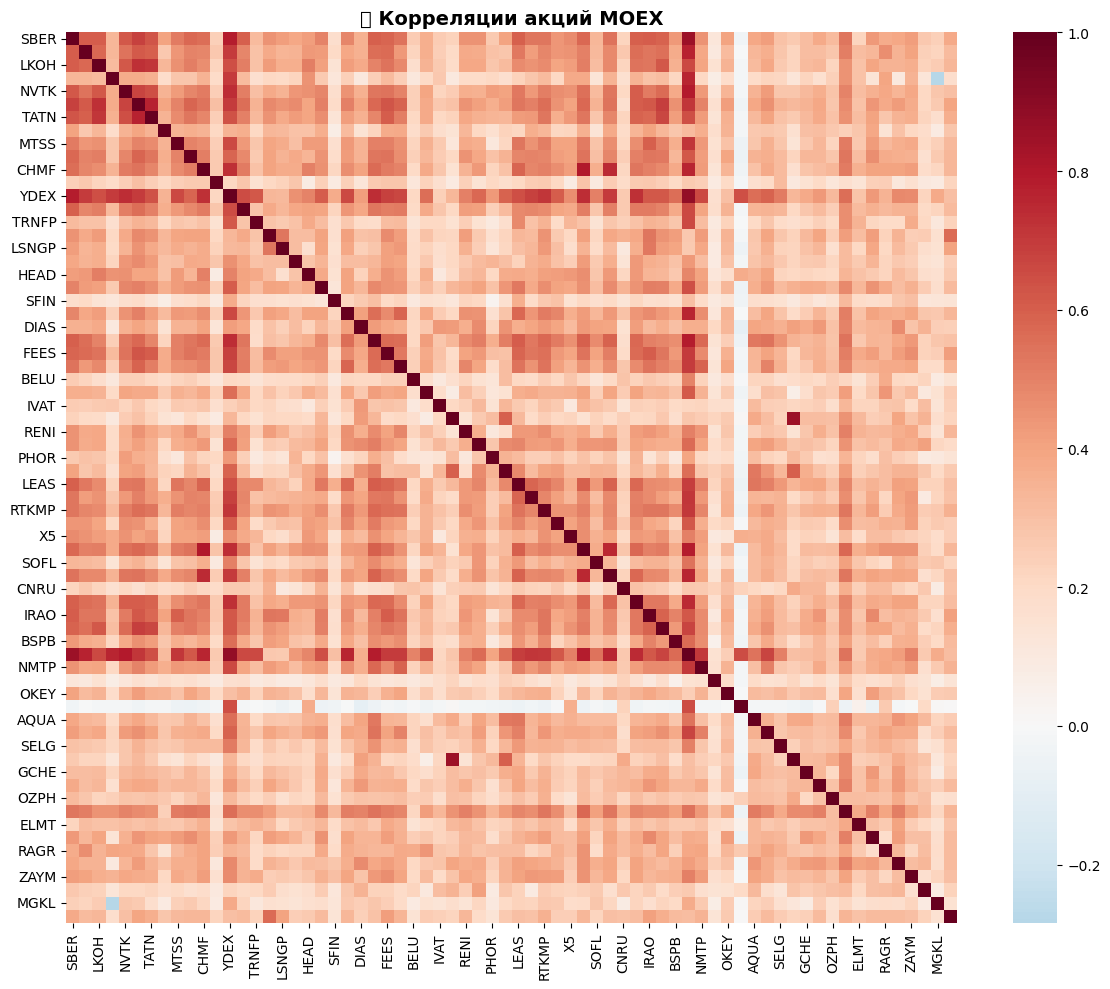


Фрагмент корреляционной матрицы:
       SBER   GAZP   LKOH   GMKN   NVTK
SBER  1.000  0.608  0.607  0.338  0.618
GAZP  0.608  1.000  0.574  0.334  0.547
LKOH  0.607  0.574  1.000  0.321  0.614
GMKN  0.338  0.334  0.321  1.000  0.372
NVTK  0.618  0.547  0.614  0.372  1.000

🎯 Выбранные 10 тикеров (TOP-10 по Sharpe):
T        1.110
OZPH     1.046
BSPB     0.893
FESH     0.832
MDMG     0.819
SELG     0.689
PHOR     0.681
MRKU     0.653
LSNGP    0.608
MRKP     0.594
dtype: float64
Список тикеров: ['T', 'OZPH', 'BSPB', 'FESH', 'MDMG', 'SELG', 'PHOR', 'MRKU', 'LSNGP', 'MRKP']


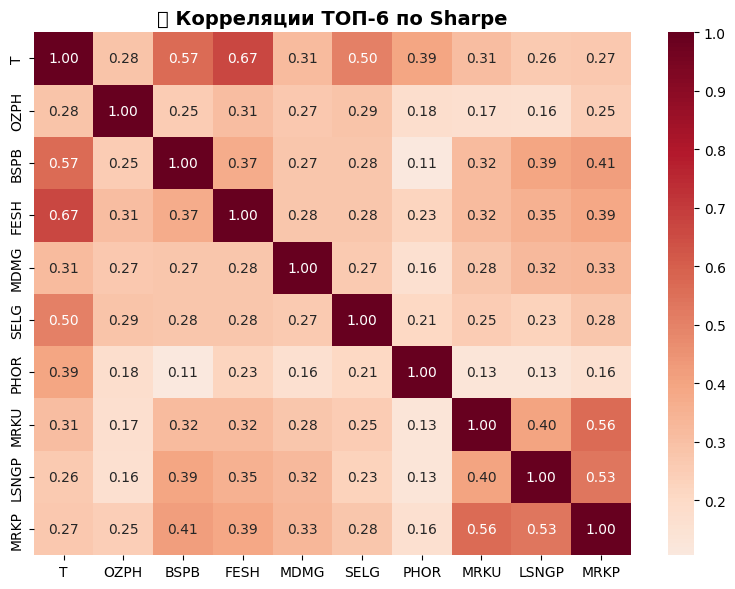


Корреляционная матрица ТОП-6 по Sharpe:
           T   OZPH   BSPB   FESH   MDMG   SELG   PHOR   MRKU  LSNGP   MRKP
T      1.000  0.282  0.568  0.670  0.315  0.502  0.395  0.306  0.263  0.269
OZPH   0.282  1.000  0.254  0.312  0.269  0.288  0.179  0.169  0.160  0.249
BSPB   0.568  0.254  1.000  0.374  0.275  0.275  0.106  0.322  0.394  0.415
FESH   0.670  0.312  0.374  1.000  0.277  0.276  0.228  0.320  0.354  0.390
MDMG   0.315  0.269  0.275  0.277  1.000  0.266  0.160  0.278  0.324  0.332
SELG   0.502  0.288  0.275  0.276  0.266  1.000  0.210  0.253  0.232  0.275
PHOR   0.395  0.179  0.106  0.228  0.160  0.210  1.000  0.133  0.128  0.160
MRKU   0.306  0.169  0.322  0.320  0.278  0.253  0.133  1.000  0.401  0.564
LSNGP  0.263  0.160  0.394  0.354  0.324  0.232  0.128  0.401  1.000  0.533
MRKP   0.269  0.249  0.415  0.390  0.332  0.275  0.160  0.564  0.533  1.000

🏆 Sharpe портфеля ТОП-6 (равные веса): 1.176
🏛 Sharpe индекса IMOEX:                 0.083
Δ Sharpe (портфель - индекс):  

In [9]:
def target_equity_weight(date):
    reg = rvi_regime(date)
    if reg == "low_vol":
        return 1.0
    elif reg == "normal":
        return 0.8
    else:  # high_vol
        return 0.5

# -------- ДОХОДНОСТИ --------
returns = data.pct_change()          # строки с NaN оставляем
idx_returns = idx_prices.pct_change()

# -------- RVI: сглаживание и режимы --------
rvi_rolling = rvi_series.rolling(21).mean()

low_q, high_q = rvi_rolling.quantile([0.3, 0.7])

def rvi_regime(date):
    """
    Классификация режима рынка по RVI:
    low_vol  — нижние 30% значений
    high_vol — верхние 30% значений
    normal   — середина
    """
    v = rvi_rolling.loc[date]
    if pd.isna(v):
        return "normal"
    if v <= low_q:
        return "low_vol"
    elif v >= high_q:
        return "high_vol"
    else:
        return "normal"


print("data:", data.index.min(), "→", data.index.max(), len(data))
print("idx :", idx_prices.index.min(), "→", idx_prices.index.max(), len(idx_prices))


print("=== Анализ акций MOEX (apimoex + ISSClient) ===")
print(f"Период: {returns.index[0].date()} - {returns.index[-1].date()}")
print(f"Размер выборки: {len(returns)} наблюдений")
print(f"Анализируем тикеры: {list(returns.columns)}")

# -------- SHARPE ДЛЯ ВСЕХ ТИКЕРОВ И ИНДЕКСА --------
sharpe_all = returns.mean() / returns.std() * np.sqrt(252)
print("\n📈 Sharpe по всем загруженным тикерам:")
print(sharpe_all.sort_values(ascending=False).round(3))

sharpe_index = idx_returns.mean() / idx_returns.std() * np.sqrt(252)
print(f"\n🏛 Sharpe индекса IMOEX: {sharpe_index:.3f}")

# -------- КОРРЕЛЯЦИОННАЯ МАТРИЦА (ВСЕ ТИКЕРЫ) --------
corr = returns.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="RdBu_r", center=0)
plt.title("🔥 Корреляции акций MOEX", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nФрагмент корреляционной матрицы:")
print(corr.iloc[:5, :5].round(3))

# -------- ВЫБОР 10 ТИКЕРОВ С ЛУЧШИМ SHARPE --------
# Сортируем Sharpe по убыванию и берём топ-10
sharpe_sorted = sharpe_all.sort_values(ascending=False)
top10 = list(sharpe_sorted.index[:10])

print("\n🎯 Выбранные 10 тикеров (TOP-10 по Sharpe):")
print(sharpe_sorted.head(10).round(3))
print("Список тикеров:", top10)

rets6 = returns[top10]

# -------- КОРРЕЛЯЦИЯ ЭТИХ 6 АКЦИЙ --------
corr6 = rets6.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr6, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("🔥 Корреляции ТОП-6 по Sharpe", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nКорреляционная матрица ТОП-6 по Sharpe:")
print(corr6.round(3))

# -------- SHARPE ПОРТФЕЛЯ ТОП‑6 VS ИНДЕКС --------
port6_rets = rets6.mean(axis=1)  # equal-weight портфель
sharpe_port6 = port6_rets.mean() / port6_rets.std() * np.sqrt(252)
sharpe_idx = idx_returns.mean() / idx_returns.std() * np.sqrt(252)

print(f"\n🏆 Sharpe портфеля ТОП-6 (равные веса): {sharpe_port6:.3f}")
print(f"🏛 Sharpe индекса IMOEX:                 {sharpe_idx:.3f}")
print(f"Δ Sharpe (портфель - индекс):           {sharpe_port6 - sharpe_idx:.3f}")

# -------- МОМЕНТУМ 1/3/6 МЕСЯЦЕВ И РАЗНИЦА С ИНДЕКСОМ --------
def calc_momentum(price_series, periods=[21, 63, 126]):
    moms = {}
    for p in periods:
        if len(price_series) > p:
            moms[p] = price_series.iloc[-1] / price_series.iloc[-p] - 1
        else:
            moms[p] = np.nan
    return moms

periods = [21, 63, 126]
print("\n⚡ Моментум 1/3/6 месяцев (и отличие от индекса) для ТОП-6 по Sharpe:")
print("Ticker | 1м (Δ к индекс) | 3м (Δ) | 6м (Δ)")
print("-" * 60)

for t in top10:
    moms_stock = calc_momentum(data[t])
    moms_idx = calc_momentum(idx_prices)
    row = f"{t:6s} | "
    for p in periods:
        ms = moms_stock[p]
        mi = moms_idx[p]
        if np.isnan(ms) or np.isnan(mi):
            row += "n/a         | "
        else:
            diff = ms - mi
            row += f"{ms:.1%} ({diff:+.1%}) | "
    print(row)





🎯 Дополнительные тикеры для анализа: ['TRNFP', 'GMKN', 'LSNGP', 'NVTK', 'SPBE', 'MRKP', 'CNRU', 'ZAYM', 'MDMG', 'LENT']


TypeError: title() takes from 1 to 4 positional arguments but 6 were given

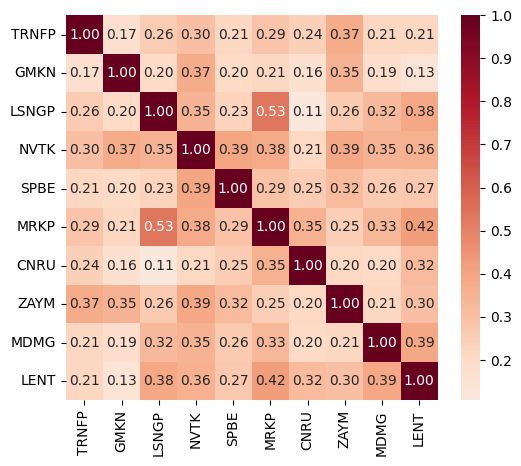

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ДЛЯ ФИКСИРОВАННЫХ 6 ТИКЕРОВ ===
extra6 = ["TRNFP", "GMKN", "LSNGP", "NVTK", "SPBE", "MRKP", "CNRU", "ZAYM", "MDMG", "LENT"]

# Фильтруем только те, которые реально есть в data/returns
extra6 = [t for t in extra6 if t in data.columns]
if len(extra6) == 0:
    print("❌ Ни одного из extra6 нет в data.columns")
else:
    print("🎯 Дополнительные тикеры для анализа:", extra6)

    # Берём цены и доходности только по этим тикерам
    prices_ex6 = data[extra6].copy()
    rets_ex6 = returns[extra6].copy()

    # Синхронизация с индексом (на всякий случай)
    common_idx = rets_ex6.index.intersection(idx_returns.index)
    rets_ex6 = rets_ex6.loc[common_idx]
    idx_rets_ex = idx_returns.loc[common_idx]
    prices_ex6 = prices_ex6.loc[common_idx]
    idx_prices_ex = idx_prices.loc[common_idx]

    # 1) Корреляция и heatmap
    corr_ex6 = rets_ex6.corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_ex6, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
    plt.title("🔥 Корреляции (CNRU", "MDMG", "PLZL", "LSNGP", "PHOR", "SBER)", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

    print("\nКорреляционная матрица (extra6):")
    print(corr_ex6.round(3))

    # 2) Sharpe каждого тикера и портфеля 1/6
    sharpe_each = rets_ex6.mean() / rets_ex6.std() * np.sqrt(252)
    port_ex6_rets = rets_ex6.mean(axis=1)  # equal-weight
    sharpe_port_ex6 = port_ex6_rets.mean() / port_ex6_rets.std() * np.sqrt(252)
    sharpe_idx_ex = idx_rets_ex.mean() / idx_rets_ex.std() * np.sqrt(252)

    print("\n📈 Sharpe по отдельным тикерам (extra6):")
    print(sharpe_each.round(3))

    print(f"\n🏆 Sharpe портфеля extra6 (equal-weight): {sharpe_port_ex6:.3f}")
    print(f"🏛 Sharpe индекса IMOEX:                 {sharpe_idx_ex:.3f}")
    print(f"Δ Sharpe (портфель extra6 - индекс):    {sharpe_port_ex6 - sharpe_idx_ex:.3f}")

    # 3) Momentum 1/3/6 месяцев и отличие от индекса
    def calc_momentum(price_series, periods=[21, 63, 126]):
        moms = {}
        for p in periods:
            if len(price_series) > p:
                moms[p] = price_series.iloc[-1] / price_series.iloc[-p] - 1
            else:
                moms[p] = np.nan
        return moms

    periods = [21, 63, 126]
    idx_moms = calc_momentum(idx_prices_ex)

    rows = []
    for t in extra6:
        moms = calc_momentum(prices_ex6[t])
        rows.append({
            "Ticker": t,
            "Sharpe": sharpe_each[t],
            "Mom_1m": moms[21],
            "Mom_3m": moms[63],
            "Mom_6m": moms[126],
            "Mom_1m_vs_Idx": moms[21] - idx_moms[21] if not np.isnan(moms[21]) and not np.isnan(idx_moms[21]) else np.nan,
            "Mom_3m_vs_Idx": moms[63] - idx_moms[63] if not np.isnan(moms[63]) and not np.isnan(idx_moms[63]) else np.nan,
            "Mom_6m_vs_Idx": moms[126] - idx_moms[126] if not np.isnan(moms[126]) and not np.isnan(idx_moms[126]) else np.nan,
        })

    res_ex6 = pd.DataFrame(rows).set_index("Ticker")

    print("\n=== Итоги по extra6 (CNRU", "MDMG", "PLZL", "LSNGP", "PHOR", "SBER) ===")
    print(res_ex6.round(3))

    print("\nКраткий отчёт (Sharpe и 6м momentum vs индекс):")
    for t in res_ex6.index:
        print(
            f"{t:6s} | Sharpe={res_ex6.loc[t,'Sharpe']:.2f} | "
            f"Mom_6m={res_ex6.loc[t,'Mom_6m']:.1%} "
            f"(Δ к индексу {res_ex6.loc[t,'Mom_6m_vs_Idx']:+.1%})"
        )


=== Анализ акций MOEX (apimoex + ISSClient) ===
Период: 2020-01-03 - 2026-01-06
Размер выборки: 1523 наблюдений
Анализируем тикеры: ['SBER', 'GAZP', 'LKOH', 'GMKN', 'NVTK', 'ROSN', 'TATN', 'MDMG', 'MTSS', 'MGNT', 'CHMF', 'PLZL', 'YDEX', 'MOEX', 'TRNFP', 'MRKP', 'LSNGP', 'SNGSP', 'HEAD', 'RASP', 'SFIN', 'SMLT', 'DIAS', 'SVCB', 'FEES', 'FLOT', 'BELU', 'SPBE', 'IVAT', 'KAZTP', 'RENI', 'ASTR', 'PHOR', 'POSI', 'LEAS', 'OZON', 'RTKMP', 'WUSH', 'X5', 'NLMK', 'SOFL', 'MAGN', 'CNRU', 'ALRS', 'IRAO', 'SIBN', 'BSPB', 'T', 'NMTP', 'SVET', 'OKEY', 'VTBR', 'AQUA', 'FESH', 'SELG', 'KAZT', 'GCHE', 'NKNC', 'OZPH', 'MBNK', 'ELMT', 'LENT', 'RAGR', 'HNFG', 'ZAYM', 'DATA', 'MGKL', 'MRKU']

📈 Sharpe по всем загруженным тикерам:
T       1.110
OZPH    1.046
BSPB    0.893
FESH    0.832
MDMG    0.819
        ...  
ZAYM   -0.739
MBNK   -1.050
RAGR   -1.430
ELMT   -1.437
DIAS   -2.067
Length: 68, dtype: float64

🏛 Sharpe индекса IMOEX: 0.083


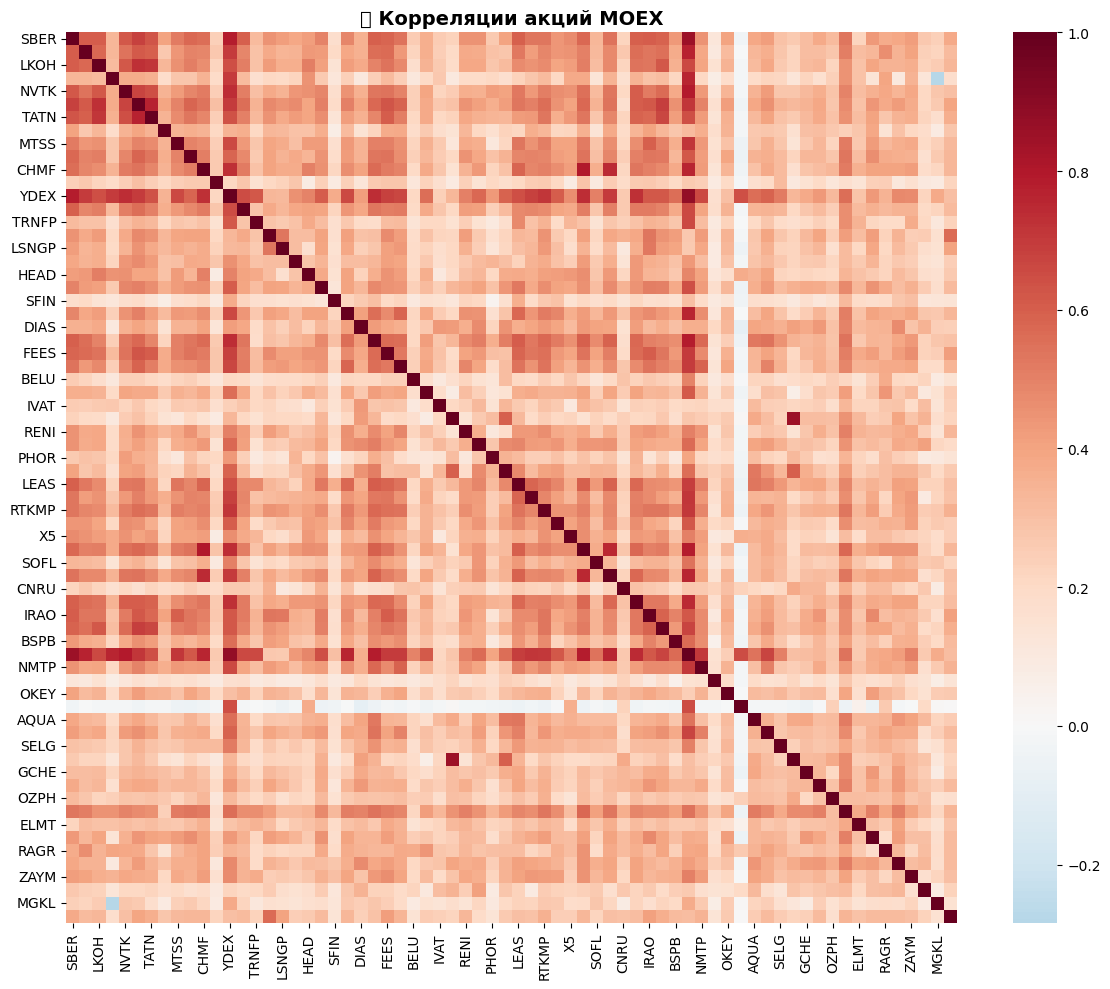


Фрагмент корреляционной матрицы:
       SBER   GAZP   LKOH   GMKN   NVTK
SBER  1.000  0.608  0.607  0.338  0.618
GAZP  0.608  1.000  0.574  0.334  0.547
LKOH  0.607  0.574  1.000  0.321  0.614
GMKN  0.338  0.334  0.321  1.000  0.372
NVTK  0.618  0.547  0.614  0.372  1.000

🎯 Выбранные 10 тикеров (TOP-10 по Sharpe):
T        1.110
OZPH     1.046
BSPB     0.893
FESH     0.832
MDMG     0.819
SELG     0.689
PHOR     0.681
MRKU     0.653
LSNGP    0.608
MRKP     0.594
dtype: float64
Список тикеров: ['T', 'OZPH', 'BSPB', 'FESH', 'MDMG', 'SELG', 'PHOR', 'MRKU', 'LSNGP', 'MRKP']


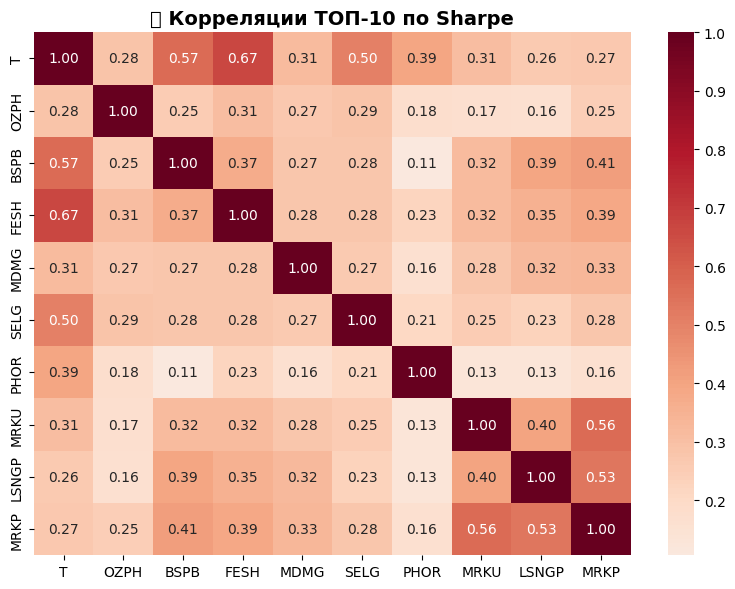


Корреляционная матрица ТОП-10 по Sharpe:
           T   OZPH   BSPB   FESH   MDMG   SELG   PHOR   MRKU  LSNGP   MRKP
T      1.000  0.282  0.568  0.670  0.315  0.502  0.395  0.306  0.263  0.269
OZPH   0.282  1.000  0.254  0.312  0.269  0.288  0.179  0.169  0.160  0.249
BSPB   0.568  0.254  1.000  0.374  0.275  0.275  0.106  0.322  0.394  0.415
FESH   0.670  0.312  0.374  1.000  0.277  0.276  0.228  0.320  0.354  0.390
MDMG   0.315  0.269  0.275  0.277  1.000  0.266  0.160  0.278  0.324  0.332
SELG   0.502  0.288  0.275  0.276  0.266  1.000  0.210  0.253  0.232  0.275
PHOR   0.395  0.179  0.106  0.228  0.160  0.210  1.000  0.133  0.128  0.160
MRKU   0.306  0.169  0.322  0.320  0.278  0.253  0.133  1.000  0.401  0.564
LSNGP  0.263  0.160  0.394  0.354  0.324  0.232  0.128  0.401  1.000  0.533
MRKP   0.269  0.249  0.415  0.390  0.332  0.275  0.160  0.564  0.533  1.000

🏆 Sharpe портфеля ТОП-10 (равные веса): 1.176
🏛 Sharpe индекса IMOEX:               0.083
Δ Sharpe (портфель - индекс):  

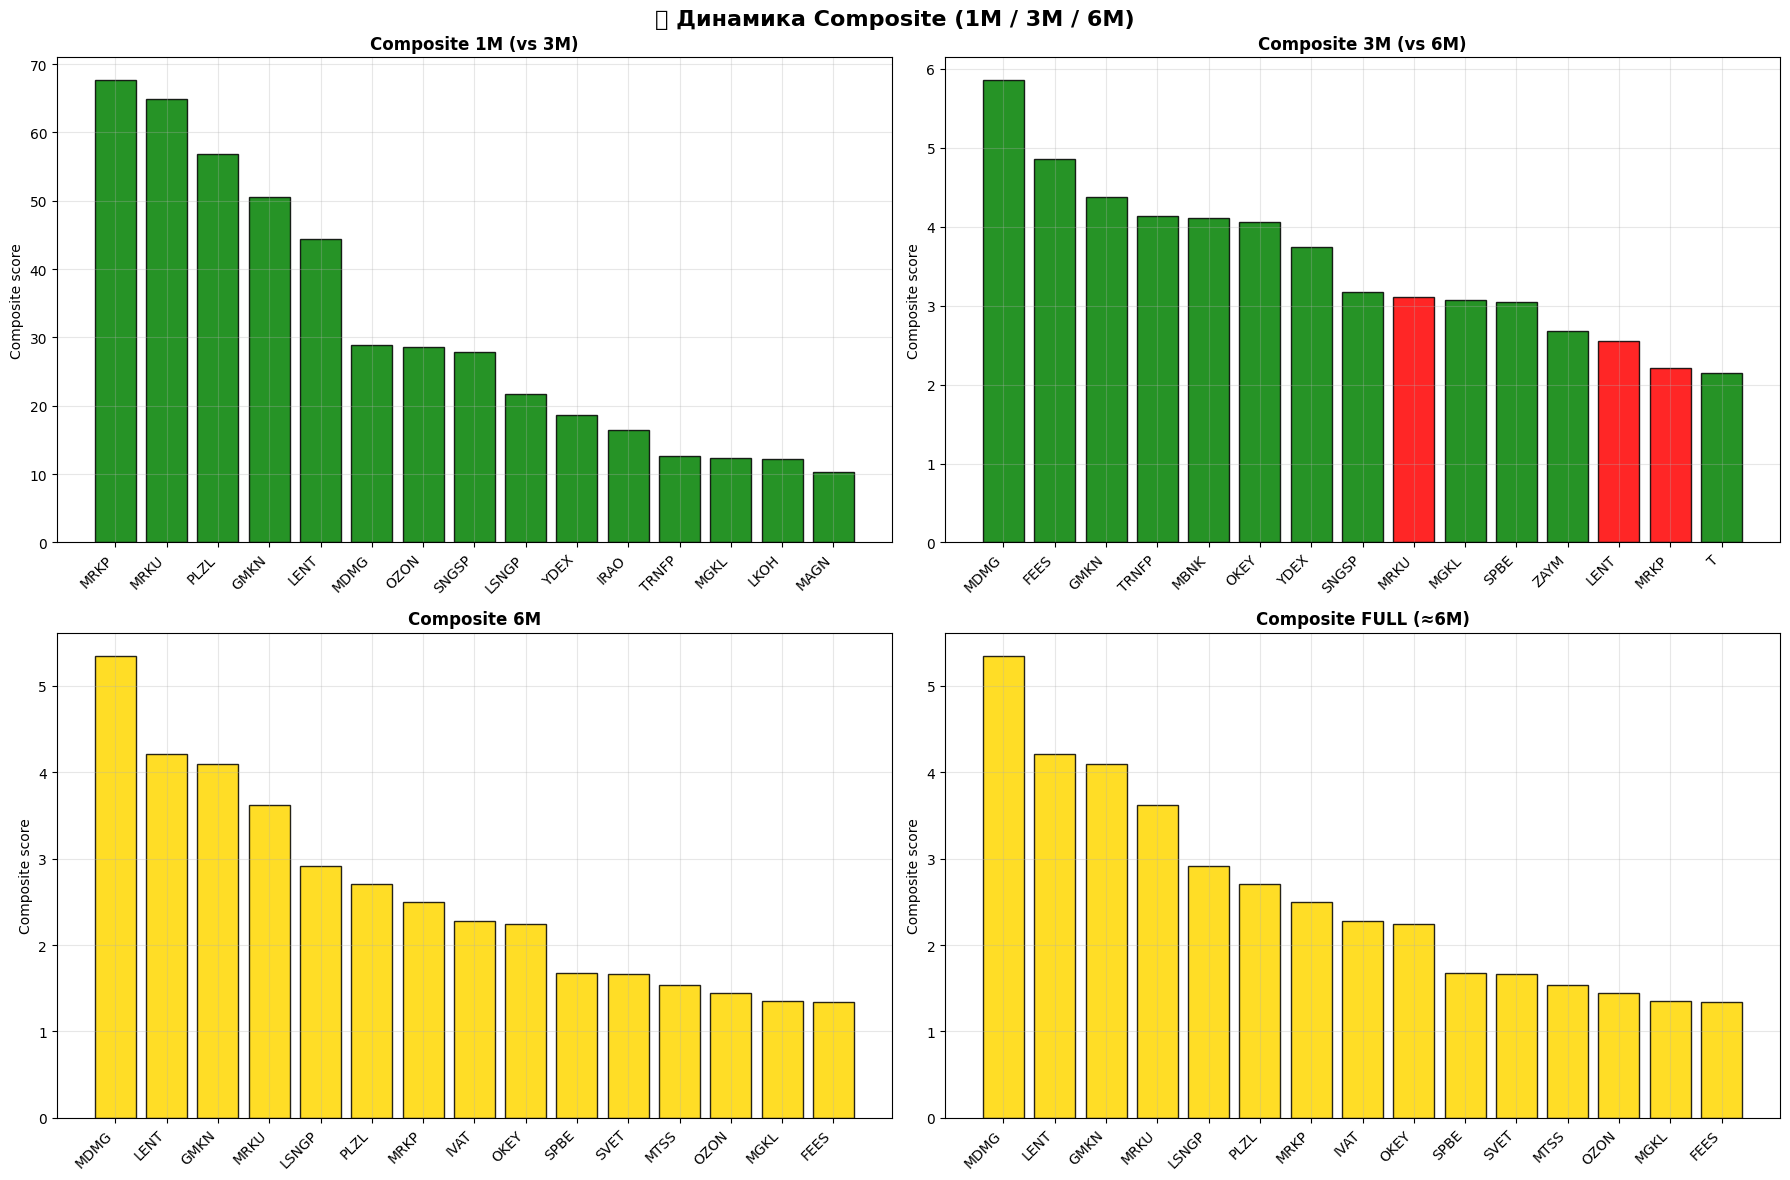


✅ ЛЕГЕНДА ЦВЕТОВ:
🟢 +5% и более — сильный рост качества (Sharpe растёт)
🟡 от -5% до +5% — стабильность / стагнация
🔴 -5% и менее — ухудшение качества (Sharpe падает)

TOP-15 по Composite (1m) с 3m и 6m:


,Composite,Composite_3m,Composite_6m
MRKP,67.609,2.211,2.496
MRKU,64.864,3.105,3.623
PLZL,56.810,0.560,2.712
GMKN,50.536,4.375,4.098
LENT,44.350,2.555,4.213
MDMG,28.913,5.850,5.348
OZON,28.617,1.443,1.445
SNGSP,27.869,3.172,-1.063
LSNGP,21.697,1.775,2.912
YDEX,18.714,3.746,0.937


Всего дат в цикле: 1439
Без пересечения: 8

📄 Итоговая таблица walk-forward (первые строки):


,Tickers,Ret_port_1w,Ret_port_2w,Ret_port_1m,Ret_idx_1w,Ret_idx_2w,Ret_idx_1m,Regime,Skip_flag
Date,,,,,,,,,
2020-04-06,"SNGSP,SELG,MOEX,TRNFP,NLMK,NVTK,MAGN,NKNC",2.42,2.64,2.48,0.24,-3.68,0.36,high_vol,
2020-04-07,"SELG,MOEX,NLMK,TRNFP,NVTK,MAGN,NKNC,GAZP",5.53,1.62,2.97,-0.11,-5.57,-0.03,high_vol,
2020-04-08,"BELU,MOEX,SELG,TRNFP,MTSS",5.84,9.42,12.88,-6.41,-3.62,-1.07,high_vol,
2020-04-09,"BELU,SELG,MOEX,NVTK,NLMK,ROSN,FEES",1.26,5.12,8.27,-6.91,-3.79,-2.21,high_vol,
2020-04-10,"BELU,CHMF,GAZP,NVTK,NLMK,FESH,IRAO,VTBR,RTKMP",-3.71,-3.87,-4.04,-5.34,-4.33,-2.72,high_vol,
2020-04-13,"BELU,SELG,ROSN,MOEX,NLMK,IRAO,NVTK,FESH,FEES",-1.13,0.35,1.02,-3.91,-2.20,-1.47,high_vol,
2020-04-14,"BELU,SELG,PLZL,PHOR,MOEX,MRKU,VTBR,RTKMP,IRAO",-0.89,2.37,1.52,-5.46,-0.74,-1.44,high_vol,
2020-04-15,"BELU,SELG,PLZL,PHOR,MOEX,MGNT,MRKU,MRKP,NLMK",4.13,4.43,5.81,2.98,6.57,7.82,high_vol,
2020-04-16,"BELU,SELG,PLZL,MOEX,MRKP,FEES,PHOR,NLMK,MRKU,MTSS",2.88,2.45,3.45,3.35,5.39,7.82,high_vol,



🛡️ STABILITY (% времени Sharpe > порога):
  1m: 60.1% | 3m: 60.3%
  normal: 60.9%
  high_vol: 58.3%

🎯 RISKSCORE: 43/100
  Win-rate 1m: 55.9%
  Stability 1m: 60.1%
  Альфа 1m: +5.00%
  Средний Sharpe 1m: 1.19
🟢 STATUS: CONSERVATIVE — 40-70% веса портфеля


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# =========================================
# 0. ВХОДНЫЕ ДАННЫЕ: data (цены акций), idx_prices (цены IMOEX)
# =========================================
# data: DataFrame, столбцы = тикеры, индекс = даты
# idx_prices: Series или DataFrame с одной колонкой IMOEX, индекс = даты

# -------- ДОХОДНОСТИ --------
returns = data.pct_change()          # строки с NaN оставляем
idx_returns = idx_prices.pct_change()

print("=== Анализ акций MOEX (apimoex + ISSClient) ===")
print(f"Период: {returns.index[0].date()} - {returns.index[-1].date()}")
print(f"Размер выборки: {len(returns)} наблюдений")
print(f"Анализируем тикеры: {list(returns.columns)}")

# -------- SHARPE ДЛЯ ВСЕХ ТИКЕРОВ И ИНДЕКСА --------
sharpe_all = returns.mean() / returns.std() * np.sqrt(252)
print("\n📈 Sharpe по всем загруженным тикерам:")
print(sharpe_all.sort_values(ascending=False).round(3))

sharpe_index = idx_returns.mean() / idx_returns.std() * np.sqrt(252)
print(f"\n🏛 Sharpe индекса IMOEX: {sharpe_index:.3f}")

# -------- КОРРЕЛЯЦИОННАЯ МАТРИЦА (ВСЕ ТИКЕРЫ) --------
corr = returns.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="RdBu_r", center=0)
plt.title("🔥 Корреляции акций MOEX", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nФрагмент корреляционной матрицы:")
print(corr.iloc[:5, :5].round(3))

# -------- ВЫБОР ТОП-10 ПО SHARPE --------
sharpe_sorted = sharpe_all.sort_values(ascending=False)
top10 = list(sharpe_sorted.index[:10])

print("\n🎯 Выбранные 10 тикеров (TOP-10 по Sharpe):")
print(sharpe_sorted.head(10).round(3))
print("Список тикеров:", top10)

rets10 = returns[top10]

# -------- КОРРЕЛЯЦИЯ ЭТИХ 10 АКЦИЙ --------
corr10 = rets10.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr10, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("🔥 Корреляции ТОП-10 по Sharpe", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nКорреляционная матрица ТОП-10 по Sharpe:")
print(corr10.round(3))

# -------- SHARPE ПОРТФЕЛЯ ТОП‑10 VS ИНДЕКС --------
port10_rets = rets10.mean(axis=1)  # equal-weight портфель
sharpe_port10 = port10_rets.mean() / port10_rets.std() * np.sqrt(252)
sharpe_idx = idx_returns.mean() / idx_returns.std() * np.sqrt(252)

print(f"\n🏆 Sharpe портфеля ТОП-10 (равные веса): {sharpe_port10:.3f}")
print(f"🏛 Sharpe индекса IMOEX:               {sharpe_idx:.3f}")
print(f"Δ Sharpe (портфель - индекс):         {sharpe_port10 - sharpe_idx:.3f}")

# -------- МОМЕНТУМ 1/3/6 МЕСЯЦЕВ --------
def calc_momentum(price_series, periods=[21, 63, 126]):
    moms = {}
    for p in periods:
        if len(price_series) > p:
            moms[p] = price_series.iloc[-1] / price_series.iloc[-p] - 1
        else:
            moms[p] = np.nan
    return moms

periods_mom = [21, 63, 126]
print("\n⚡ Моментум 1/3/6 месяцев (и отличие от индекса) для ТОП-10 по Sharpe:")
print("Ticker | 1м (Δ к индекс) | 3м (Δ) | 6м (Δ)")
print("-" * 60)

for t in top10:
    moms_stock = calc_momentum(data[t])
    moms_idx = calc_momentum(idx_prices)
    row = f"{t:6s} | "
    for p in periods_mom:
        ms = moms_stock[p]
        mi = moms_idx[p]
        if np.isnan(ms) or np.isnan(mi):
            row += "n/a         | "
        else:
            diff = ms - mi
            row += f"{ms:.1%} ({diff:+.1%}) | "
    print(row)

# =========================================
# 1. DYNAMIC SHARPE: 2w / 1m / 3m / 6m / full
# =========================================

print("\n" + "="*100)
print("📊 ДИНАМИКА SHARPE RATIO: 2w / 1m / 3m / 6m / Полный период")
print("="*100)

# -------- ЦВЕТОВАЯ РАСКРАСКА --------
def color_trend(val1, val2):
    """
    Возвращает эмодзи + цвет:
    🟢 рост >= +5%, 🟡 от -5% до +5%, 🔴 падение <= -5%.
    """
    if pd.isna(val1) or pd.isna(val2):
        return "n/a", "gray"
    if val1 == 0:
        diff_pct = 0
    else:
        diff_pct = (val2 - val1) / abs(val1) * 100
    if diff_pct >= 5:
        return f"🟢 +{diff_pct:.1f}%", "green"
    elif diff_pct <= -5:
        return f"🔴 {diff_pct:.1f}%", "red"
    else:
        return f"🟡 {diff_pct:+.1f}%", "gold"

# -------- ПЕРИОДЫ ДЛЯ АНАЛИЗА --------
periods = {
    "2w": 10,       # ~2 недели
    "1m": 21,       # ~1 месяц
    "3m": 63,       # ~3 месяца
    "6m": 126,      # ~6 месяцев
    "full": len(returns)
}

# -------- РАСЧЁТ SHARPE ПО ПЕРИОДАМ ДЛЯ АКЦИЙ --------
results = []
for period_name, n_days in periods.items():
    if period_name == "full":
        period_rets = returns.copy()
    else:
        period_rets = returns.tail(n_days).dropna()

    if len(period_rets) < 10:
        print(f"⚠️ Недостаточно данных для {period_name}: {len(period_rets)} дней")
        continue

    sharpe_period = period_rets.mean() / period_rets.std() * np.sqrt(252)

    for ticker in sharpe_period.index:
        results.append({
            "Ticker": ticker,
            "Period": period_name,
            "Days": len(period_rets),
            "Sharpe": float(sharpe_period[ticker])
        })

df_results = pd.DataFrame(results)

# -------- РАСЧЁТ SHARPE ПО ПЕРИОДАМ ДЛЯ ИНДЕКСА --------
idx_results = []
for period_name, n_days in periods.items():
    if period_name == "full":
        period_idx = idx_returns.copy()
    else:
        period_idx = idx_returns.tail(n_days).dropna()

    if len(period_idx) < 10:
        print(f"⚠️ Недостаточно данных по индексу для {period_name}: {len(period_idx)} дней")
        continue

    sharpe_idx_period = period_idx.mean() / period_idx.std() * np.sqrt(252)
    idx_results.append({
        "Ticker": "IMOEX",
        "Period": period_name,
        "Days": len(period_idx),
        "Sharpe": float(sharpe_idx_period)
    })

df_idx = pd.DataFrame(idx_results)

# -------- ПИВОТ-Таблица: акции --------
pivot_sharpe = df_results.pivot(index="Ticker", columns="Period", values="Sharpe").round(3)

# -------- ПИВОТ-Таблица: индекс --------
idx_pivot = df_idx.pivot(index="Ticker", columns="Period", values="Sharpe").round(3)

# -------- ОБЪЕДИНЯЕМ АКЦИИ + ИНДЕКС --------
pivot_sharpe = pd.concat([pivot_sharpe, idx_pivot])

for col in ["2w", "1m", "3m", "6m", "full"]:
    if col not in pivot_sharpe.columns:
        pivot_sharpe[col] = np.nan

# -------- ДОБАВЛЯЕМ ПРОЦЕНТЫ ИЗМЕНЕНИЙ --------
trend_3m_6m = []
trend_1m_3m = []

for ticker in pivot_sharpe.index:
    s6m = pivot_sharpe.loc[ticker, "6m"]
    s3m = pivot_sharpe.loc[ticker, "3m"]
    s1m = pivot_sharpe.loc[ticker, "1m"]
    t36, _ = color_trend(s6m, s3m)
    t13, _ = color_trend(s3m, s1m)
    trend_3m_6m.append(t36)
    trend_1m_3m.append(t13)

pivot_sharpe["3m↔6m"] = trend_3m_6m
pivot_sharpe["1m↔3m"] = trend_1m_3m

print("\n📈 Sharpe ratio по периодам + 🟢🟡🔴 динамика:")
print(
    pivot_sharpe
    .sort_values("6m", ascending=False)
    [["2w", "1m", "3m", "6m", "full", "3m↔6m", "1m↔3m"]]
)

# -------- ТОП-10 ПО 6-МЕСЯЧНОМУ SHARPE --------
print("\n🏆 ТОП-10 по Sharpe за 6 месяцев:")
top10_6m = pivot_sharpe.drop(index=["IMOEX"], errors="ignore").nlargest(10, "6m")
print(top10_6m[["2w", "1m", "3m", "6m", "full", "3m↔6m", "1m↔3m"]])


# =========================================
# 2. WALK-FORWARD ПОРТФЕЛЬ
# =========================================
trading_days = 252
risk_free = 0.0

def sharpe_ratio_series(r):
    r = r.dropna()
    if len(r) == 0 or r.std() == 0:
        return np.nan
    mean_excess = r.mean()  # риск-фри ≈ 0
    return np.sqrt(trading_days) * mean_excess / r.std()

def sortino_ratio(r):
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    downside = r[r < 0].std()
    if pd.isna(downside) or downside == 0:
        return np.nan
    mean_excess = r.mean()
    return np.sqrt(trading_days) * mean_excess / downside

def calmar_ratio(r):
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    cum = (1 + r).cumprod()
    mdd = ((cum / cum.cummax()) - 1).min()
    if mdd >= 0 or np.isnan(mdd):
        return np.nan
    ann_ret = (1 + r).prod() ** (trading_days / len(r)) - 1
    return ann_ret / abs(mdd)

def forward_return(r, start_loc, horizon):
    end_loc = start_loc + horizon
    if end_loc >= len(r):
        return np.nan
    window = r.iloc[start_loc+1:end_loc+1]
    return (1 + window).prod() - 1

# ================================
# MULTI-HORIZON METRICS & COMPOSITE
# ================================
windows_conf = {
    "2w": 10,
    "1m": 21,
    "3m": 63,
    "6m": 126
}

results_port = {}

for name, length in windows_conf.items():
    win = returns.iloc[-length:]  # последняя выборка по окну
    ratios = {}
    for t in win.columns:
        r = win[t].dropna()
        if len(r) < 10:
            continue
        ratios[t] = {
            "Sharpe": sharpe_ratio_series(r),
            "Sortino": sortino_ratio(r),
            "Calmar": calmar_ratio(r)
        }
    results_port[name] = pd.DataFrame(ratios).T

# Composite на 1m как базовый скоринг качества тикеров
# добавляем Composite для всех окон

for win_name, df_win in results_port.items():
    df_win["Composite"] = (
        0.5 * df_win["Sharpe"] +
        0.35 * df_win["Sortino"] +
        0.15 * df_win["Calmar"]
    )

comp_6m = results_port["6m"]["Composite"]
comp_3m = results_port["3m"]["Composite"]
comp_1m = results_port["1m"]["Composite"]


# -------- ВИЗУАЛИЗАЦИЯ С ЦВЕТАМИ (общий тренд 6м→1м) --------
# -------- ВИЗУАЛИЗАЦИЯ TOP-15 ПО COMPOSITE С ДИНАМИКОЙ --------
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

plot_windows = ["1m", "3m", "6m", "full_like"]  # full_like можно сделать по 6m Composite

for i, win_name in enumerate(plot_windows):
    ax = axes[i]

    if win_name == "1m":
        df_plot = results_port["1m"].copy()
        df_plot_base = comp_3m  # сравниваем 1m vs 3m
        title = "Composite 1M (vs 3M)"
    elif win_name == "3m":
        df_plot = results_port["3m"].copy()
        df_plot_base = comp_6m  # 3m vs 6m
        title = "Composite 3M (vs 6M)"
    elif win_name == "6m":
        df_plot = results_port["6m"].copy()
        # для 6m можно сравнивать с full или просто ставить все зелёным
        df_plot_base = comp_6m * 0  # базовое = 0 → цвет по абсолютному росту
        title = "Composite 6M"
    else:
        df_plot = results_port["6m"].copy()
        df_plot_base = comp_6m  # условный full
        title = "Composite FULL (≈6M)"

    df_plot = df_plot.dropna(subset=["Composite"])
    if df_plot.empty:
        ax.set_title(f"{title}: нет данных")
        ax.axis("off")
        continue

    # TOP-15 по Composite
    top15 = df_plot.nlargest(15, "Composite")

    colors15 = []
    for t in top15.index:
        base_val = df_plot_base.get(t, np.nan)
        _, c = color_trend(base_val, top15.loc[t, "Composite"])
        colors15.append(c)

    ax.bar(range(len(top15)),
           top15["Composite"],
           color=colors15,
           edgecolor="black",
           alpha=0.85)

    ax.set_title(title, fontweight="bold")
    ax.set_ylabel("Composite score")
    ax.set_xticks(range(len(top15)))
    ax.set_xticklabels(top15.index, rotation=45, ha="right")
    ax.grid(True, alpha=0.3)

plt.suptitle("🔥 Динамика Composite (1M / 3M / 6M)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


print("\n✅ ЛЕГЕНДА ЦВЕТОВ:")
print("🟢 +5% и более — сильный рост качества (Sharpe растёт)")
print("🟡 от -5% до +5% — стабильность / стагнация")
print("🔴 -5% и менее — ухудшение качества (Sharpe падает)")

# удобный alias для 1m
df_1m = results_port["1m"]

# TOP‑15 по 1m Composite
top15_1m = df_1m.nlargest(15, "Composite").copy()

# подтягиваем Composite 3m и 6m по тем же тикерам
df_3m = results_port["3m"]
df_6m = results_port["6m"]

top15_1m["Composite_3m"] = df_3m["Composite"].reindex(top15_1m.index)
top15_1m["Composite_6m"] = df_6m["Composite"].reindex(top15_1m.index)

# при желании можно округлить
top15_1m_rounded = top15_1m[["Composite", "Composite_3m", "Composite_6m"]].round(3)

print("\nTOP-15 по Composite (1m) с 3m и 6m:")
display(top15_1m_rounded.sort_values("Composite", ascending=False))



threshold_sharpe = 0.5
# =========================================
# WALK-FORWARD ПОРТФЕЛЬ TOP-10 vs IMOEX (без Sharpe, только доходности)
# =========================================

lookback_2w = 10
lookback_1m = 21
lookback_3m = 63

h_1w = 5
h_2w = 10
h_1m = 21

records = []
dates = returns.index
cnt_all = 0
cnt_no_intersection = 0

max_horizon = h_1m  # 21

# режимный фильтр по волатильности (RVI)
rvi_rolling = rvi_series.rolling(21).mean()
rvi_thresh = rvi_rolling.quantile(0.7)  # верхние 30% — high-vol regime

for i, current_date in enumerate(dates):
    if i < lookback_3m:
        continue
    if i + max_horizon >= len(dates):
        break

    window_2w = returns.iloc[i - lookback_2w + 1: i + 1]
    window_1m = returns.iloc[i - lookback_1m + 1: i + 1]
    window_3m = returns.iloc[i - lookback_3m + 1: i + 1]

    sharpe_2w = window_2w.apply(sharpe_ratio_series, axis=0)
    sharpe_1m = window_1m.apply(sharpe_ratio_series, axis=0)
    sharpe_3m = window_3m.apply(sharpe_ratio_series, axis=0)

    sortino_1m = window_1m.apply(sortino_ratio, axis=0)
    calmar_3m  = window_3m.apply(calmar_ratio,  axis=0)

    composite_1m = (
        0.5 * sharpe_1m +
        0.35 * sortino_1m +
        0.15 * calmar_3m
    )

    top15_2w = sharpe_2w.dropna().sort_values(ascending=False).head(15).index
    top15_1m = sharpe_1m.dropna().sort_values(ascending=False).head(15).index
    valid_3m = sharpe_3m.dropna().index

    universe = sorted(set(top15_2w) & set(top15_1m) & set(valid_3m))

    cnt_all += 1
    if len(universe) == 0:
        cnt_no_intersection += 1
        continue

    composite_universe = composite_1m.loc[universe].dropna()
    if composite_universe.empty:
        cnt_no_intersection += 1
        continue

    # теперь TOP-10
    selected = composite_universe.sort_values(ascending=False).head(10).index.tolist()

    # боевой портфель
    port_series = returns[selected].mean(axis=1)
    ret_port_1w = forward_return(port_series, i, h_1w)
    ret_port_2w = forward_return(port_series, i, h_2w)
    ret_port_1m = forward_return(port_series, i, h_1m)

    # доходности индекса вперёд
    ret_idx_1w = forward_return(idx_returns, i, h_1w)
    ret_idx_2w = forward_return(idx_returns, i, h_2w)
    ret_idx_1m = forward_return(idx_returns, i, h_1m)

    regime = "high_vol" if rvi_rolling.iloc[i] > rvi_thresh else "normal"

    records.append({
        "Date": current_date,
        "Tickers": ",".join(selected),
        "Ret_port_1w": ret_port_1w,
        "Ret_port_2w": ret_port_2w,
        "Ret_port_1m": ret_port_1m,
        "Ret_idx_1w": ret_idx_1w,
        "Ret_idx_2w": ret_idx_2w,
        "Ret_idx_1m": ret_idx_1m,
        "Regime": regime,
        "Skip_flag": ""
    })

print("Всего дат в цикле:", cnt_all)
print("Без пересечения:", cnt_no_intersection)

results_walk = pd.DataFrame(records).set_index("Date").sort_index()

# перевод доходностей в %
cols_ret = ["Ret_port_1w", "Ret_port_2w", "Ret_port_1m",
            "Ret_idx_1w", "Ret_idx_2w", "Ret_idx_1m"]

results_walk_pct = results_walk.copy()
for c in cols_ret:
    results_walk_pct[c] = (results_walk_pct[c] * 100).round(2)

print("\n📄 Итоговая таблица walk-forward (первые строки):")
display(results_walk_pct.head(20))

# ================================
# STABILITY + RISKSCORE (0-100) БЕЗ Sharpe_* КОЛОНОК
# ================================
trading_days = 252

def sharpe_ratio_series_from_ret(r):
    r = r.dropna()
    if len(r) == 0 or r.std() == 0:
        return np.nan
    return np.sqrt(trading_days) * r.mean() / r.std()

mask_live = (results_walk["Skip_flag"] == "")  # только торговые дни

# 1. STABILITY: % недель, где Sharpe портфеля за 1м > порога
# считаем "локальный" Sharpe по скользящему окну из 4 точек Ret_port_1m
rolling_sharpe_1m = (
    results_walk["Ret_port_1m"]
    .rolling(window=4, min_periods=3)
    .apply(sharpe_ratio_series_from_ret, raw=False)
)

rolling_sharpe_3m = (
    results_walk["Ret_port_1m"]
    .rolling(window=12, min_periods=6)
    .apply(sharpe_ratio_series_from_ret, raw=False)
)

# выбери порог Sharpe (например, 0.5 как раньше)
threshold_sharpe = 0.5

stability_1m = (
    rolling_sharpe_1m[mask_live] > threshold_sharpe
).mean() * 100

stability_3m = (
    rolling_sharpe_3m[mask_live] > threshold_sharpe
).mean() * 100

stability_regime = {}
for regime in ["normal", "high_vol"]:
    mask_regime = mask_live & (results_walk["Regime"] == regime)
    if mask_regime.sum() > 0:
        stab_1m_reg = (
            rolling_sharpe_1m[mask_regime] > threshold_sharpe
        ).mean() * 100
        stability_regime[regime] = stab_1m_reg

print("\n🛡️ STABILITY (% времени Sharpe > порога):")
print(f"  1m: {stability_1m:.1f}% | 3m: {stability_3m:.1f}%")
print(f"  normal: {stability_regime.get('normal', np.nan):.1f}%")
print(f"  high_vol: {stability_regime.get('high_vol', np.nan):.1f}%")

# 2. RISKSCORE (0-100): композитная оценка качества системы
# Формула: 40% win-rate + 30% stability + 20% альфа + 10% Sharpe

win_rate_1m = (
    results_walk.loc[mask_live, "Ret_port_1m"] >
    results_walk.loc[mask_live, "Ret_idx_1m"]
).mean() * 100

# ограничиваем "полезную" альфу разумным уровнем, например 0–5 % в месяц
alpha_1m_raw = (
    results_walk.loc[mask_live, "Ret_port_1m"].mean() -
    results_walk.loc[mask_live, "Ret_idx_1m"].mean()
)

alpha_1m_clipped = np.clip(alpha_1m_raw, 0, 0.05)  # максимум 5 % в месяц
alpha_1m_mean = alpha_1m_clipped * 100             # в проценты для печати


sharpe_avg = sharpe_ratio_series_from_ret(
    results_walk.loc[mask_live, "Ret_port_1m"]
)

risk_score = (
    0.40 * win_rate_1m +
    0.30 * stability_1m +
    0.20 * (alpha_1m_clipped * 100) +      # уже ограниченная альфа
    0.10 * max(sharpe_avg * 10, 0)
)
risk_score = min(max(risk_score, 0), 100)


risk_score = min(max(risk_score, 0), 100)

print(f"\n🎯 RISKSCORE: {risk_score:.0f}/100")
print(f"  Win-rate 1m: {win_rate_1m:.1f}%")
print(f"  Stability 1m: {stability_1m:.1f}%")
print(f"  Альфа 1m: {alpha_1m_mean:+.2f}%")
print(f"  Средний Sharpe 1m: {sharpe_avg:.2f}")

# 3. РЕКОМЕНДАЦИЯ ПО РИСКУ
if risk_score >= 80:
    print("✅ STATUS: AGGRESSIVE — полный вес портфеля")
elif risk_score >= 60:
    print("🟡 STATUS: BALANCED — 70-90% веса портфеля")
elif risk_score >= 40:
    print("🟢 STATUS: CONSERVATIVE — 40-70% веса портфеля")
else:
    print("🔴 STATUS: CAUTION — <40% веса, пересмотр отбора")




Всего дат в цикле: 1460
Всего записей в results_walk: 1431
Skip_flag
    1431
Name: count, dtype: int64
len(returns): 1523
первые/последние даты: 2020-01-03 00:00:00 2026-01-06 00:00:00
2026-01-06 00:00:00 2025-10-07 00:00:00
Дата формирования: 2025-10-07
TOP‑6 по 1M Composite на эту дату: ['PLZL', 'CNRU', 'IVAT', 'LSNGP', 'MRKP', 'PHOR']

Период: 2025-10-07 → 2026-01-06
Доходность портфеля TOP‑6: 3.96%
Доходность индекса IMOEX:  3.65%
Δ (портфель - индекс):    0.31%
Дата формирования портфеля (≈3м назад): 2025-10-07
TOP‑6 по 1M Composite на эту дату: ['PLZL', 'CNRU', 'IVAT', 'LSNGP', 'MRKP', 'PHOR', 'SELG', 'MDMG', 'GMKN', 'OZPH']


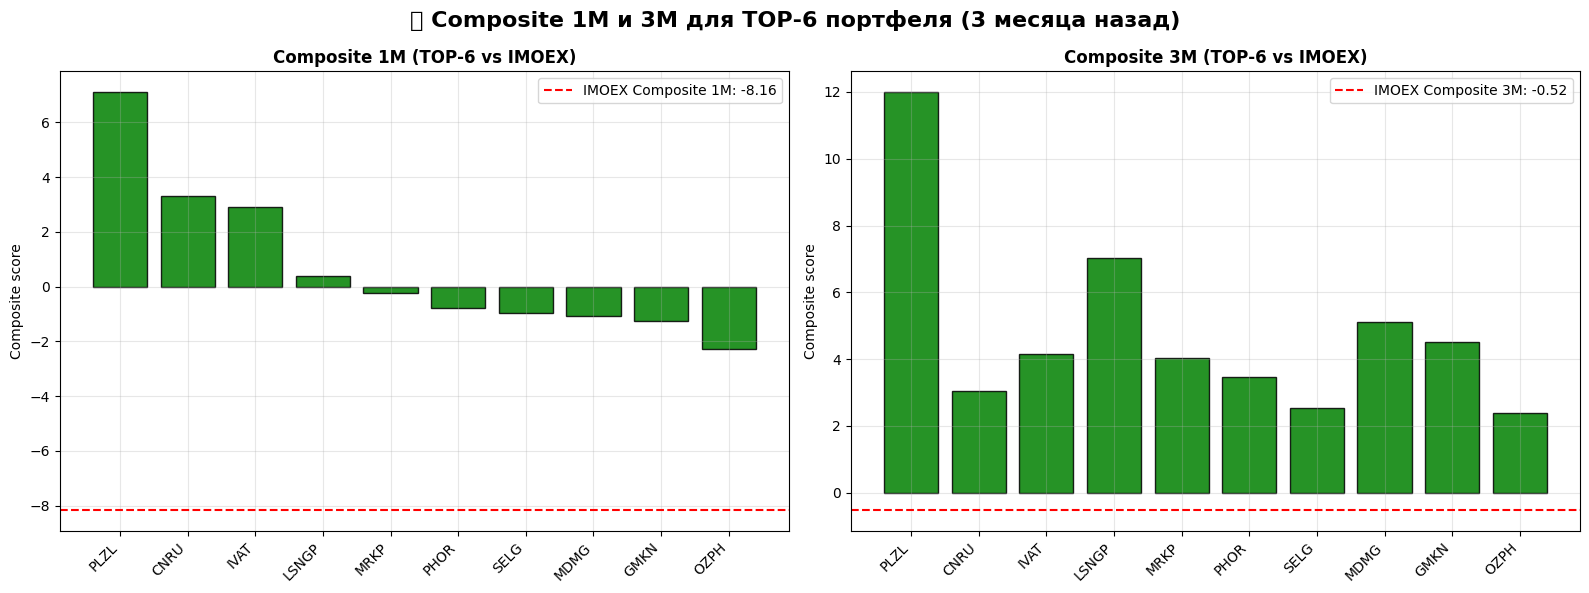

Текущий режим по RVI: normal
Нормальный режим: держать 80% в портфеле, 20% в кэше/ОФЗ.


In [12]:
print("Всего дат в цикле:", len(dates) - lookback_3m)
print("Всего записей в results_walk:", len(records))
print(results_walk['Skip_flag'].value_counts(dropna=False))
print("len(returns):", len(returns))
print("первые/последние даты:", returns.index[0], returns.index[-1])

as_of_date = returns.index[-1]              # текущая дата в данных
date_3m_ago = returns.index[-63]           # примерно 3 месяца назад (63 дня)
print(as_of_date, date_3m_ago)

# окно 1 месяца до date_3m_ago
end_loc = returns.index.get_loc(date_3m_ago)
start_loc = end_loc - 21 + 1

window_1m_past = returns.iloc[start_loc:end_loc+1]

sharpe_1m_past  = window_1m_past.apply(sharpe_ratio_series, axis=0)
sortino_1m_past = window_1m_past.apply(sortino_ratio,        axis=0)
calmar_1m_past  = window_1m_past.apply(calmar_ratio,         axis=0)

composite_1m_past = (
    0.5 * sharpe_1m_past +
    0.35 * sortino_1m_past +
    0.15 * calmar_1m_past
)

top6_past = composite_1m_past.dropna().sort_values(ascending=False).head(6).index.tolist()
print("Дата формирования:", date_3m_ago.date())
print("TOP‑6 по 1M Composite на эту дату:", top6_past)

# доходности за период [date_3m_ago, as_of_date]
period_rets = returns.loc[date_3m_ago:as_of_date, top6_past]
period_idx  = idx_returns.loc[date_3m_ago:as_of_date]

# равновзвешенный портфель
port_series = period_rets.mean(axis=1)

port_total_ret = (1 + port_series).prod() - 1
idx_total_ret  = (1 + period_idx).prod() - 1

print(f"\nПериод: {date_3m_ago.date()} → {as_of_date.date()}")
print(f"Доходность портфеля TOP‑6: {port_total_ret:.2%}")
print(f"Доходность индекса IMOEX:  {idx_total_ret:.2%}")
print(f"Δ (портфель - индекс):    {port_total_ret - idx_total_ret:.2%}")

# === 1. ДАТА 3 МЕСЯЦА НАЗАД И TOP-6 ПО 1M COMPOSITE ===
as_of_date = returns.index[-1]
end_loc = len(returns) - 63  # ~3 месяца назад
date_3m_ago = returns.index[end_loc]

start_loc_1m = end_loc - 21 + 1
window_1m_past = returns.iloc[start_loc_1m:end_loc+1]
window_3m_past = returns.iloc[end_loc-63+1:end_loc+1]

sharpe_1m_past  = window_1m_past.apply(sharpe_ratio_series, axis=0)
sortino_1m_past = window_1m_past.apply(sortino_ratio,        axis=0)
calmar_1m_past  = window_1m_past.apply(calmar_ratio,         axis=0)

sharpe_3m_past  = window_3m_past.apply(sharpe_ratio_series, axis=0)
sortino_3m_past = window_3m_past.apply(sortino_ratio,        axis=0)
calmar_3m_past  = window_3m_past.apply(calmar_ratio,         axis=0)

comp_1m_past = 0.5 * sharpe_1m_past + 0.35 * sortino_1m_past + 0.15 * calmar_1m_past
comp_3m_past = 0.5 * sharpe_3m_past + 0.35 * sortino_3m_past + 0.15 * calmar_3m_past

#  менять head (6)  на head(10) для расчета монте карло
top6_past = comp_1m_past.dropna().sort_values(ascending=False).head(10).index.tolist()

print("Дата формирования портфеля (≈3м назад):", date_3m_ago.date())
print("TOP‑6 по 1M Composite на эту дату:", top6_past)

# === 2. COMPOSITE ИНДЕКСА НА ТЕ ЖЕ ОКНА ===
idx_1m_past = idx_returns.iloc[start_loc_1m:end_loc+1].dropna()
idx_3m_past = idx_returns.iloc[end_loc-63+1:end_loc+1].dropna()

idx_comp_1m = 0.5 * sharpe_ratio_series(idx_1m_past) + \
              0.35 * sortino_ratio(idx_1m_past) + \
              0.15 * calmar_ratio(idx_1m_past)

idx_comp_3m = 0.5 * sharpe_ratio_series(idx_3m_past) + \
              0.35 * sortino_ratio(idx_3m_past) + \
              0.15 * calmar_ratio(idx_3m_past)

# === 3. ГРАФИКИ COMPOSITE ДЛЯ TOP-6 (1M И 3M) ===

def color_vs_index(comp_ticker, comp_index, tol=5.0):
    if pd.isna(comp_ticker) or pd.isna(comp_index):
        return "gray"
    if comp_index == 0:
        diff_pct = np.sign(comp_ticker) * 100
    else:
        diff_pct = (comp_ticker - comp_index) / abs(comp_index) * 100
    if diff_pct >= tol:
        return "green"
    elif diff_pct <= -tol:
        return "red"
    else:
        return "gold"

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

# 1M
comp_1m_top6 = comp_1m_past.loc[top6_past]
colors_1m = [color_vs_index(comp_1m_top6[t], idx_comp_1m) for t in top6_past]

ax = axes[0]
ax.bar(range(len(top6_past)),
       comp_1m_top6.values,
       color=colors_1m,
       edgecolor="black",
       alpha=0.85)
ax.axhline(y=idx_comp_1m, color="red", linestyle="--",
           label=f"IMOEX Composite 1M: {idx_comp_1m:.2f}")
ax.set_title("Composite 1M (TOP‑6 vs IMOEX)", fontweight="bold")
ax.set_ylabel("Composite score")
ax.set_xticks(range(len(top6_past)))
ax.set_xticklabels(top6_past, rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend()

# 3M
comp_3m_top6 = comp_3m_past.loc[top6_past]
colors_3m = [color_vs_index(comp_3m_top6[t], idx_comp_3m) for t in top6_past]

ax = axes[1]
ax.bar(range(len(top6_past)),
       comp_3m_top6.values,
       color=colors_3m,
       edgecolor="black",
       alpha=0.85)
ax.axhline(y=idx_comp_3m, color="red", linestyle="--",
           label=f"IMOEX Composite 3M: {idx_comp_3m:.2f}")
ax.set_title("Composite 3M (TOP‑6 vs IMOEX)", fontweight="bold")
ax.set_ylabel("Composite score")
ax.set_xticks(range(len(top6_past)))
ax.set_xticklabels(top6_past, rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend()

plt.suptitle("📊 Composite 1M и 3M для TOP‑6 портфеля (3 месяца назад)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

current_date = returns.index[-1]
current_regime = rvi_regime(current_date)
print("Текущий режим по RVI:", current_regime)

if current_regime == "high_vol":
    print("Рекомендация: держать только сильные по Composite тикеры, снизить общий вес (например до 50%).")
elif current_regime == "low_vol":
    print("Режим низкой волатильности: можно держать полный вес портфеля.")
else:
    print("Нормальный режим: держать 80% в портфеле, 20% в кэше/ОФЗ.")



In [13]:
  run_weekly_portfolio(115, returns, idx_returns)   # неделя 1

def run_weekly_portfolio( week_n, returns, idx_returns):
    """
    week_n: номер недели, начиная с 1 (первая неделя в данных).
    returns, idx_returns: как у тебя сейчас.
    Логика:
      - неделя = интервал из 5 торговых дней
      - на последней дате недели считаем 1M Composite (как выше)
      - берём TOP-6 тикеров
      - считаем доходность портфеля и индекса через 1, 2 и 3 месяца вперёд
      - рисуем график Composite 1M/3M для этих 6 тикеров
    """
    dates = returns.index
    total_days = len(dates)
    week_start_loc = (week_n - 1) * 5
    week_end_loc = week_start_loc + 4

    if week_start_loc < 0 or week_end_loc >= total_days:
        print(f"Неделя {week_n}: вне диапазона данных (len={total_days})")
        return

    week_start = dates[week_start_loc]
    week_end = dates[week_end_loc]

    print(f"\n=== НЕДЕЛЯ {week_n}: {week_start.date()} → {week_end.date()} ===")

    # дата формирования портфеля — конец недели
    as_of_loc = week_end_loc
    as_of_date = dates[as_of_loc]

    # окна назад для 1m/3m Composite
    lookback_1m = 21
    lookback_3m = 63

    if as_of_loc < lookback_3m:
        print("Недостаточно истории для 3M окна на этой неделе")
        return

    start_1m = as_of_loc - lookback_1m + 1
    start_3m = as_of_loc - lookback_3m + 1

    window_1m = returns.iloc[start_1m:as_of_loc+1]
    window_3m = returns.iloc[start_3m:as_of_loc+1]

    sharpe_1m  = window_1m.apply(sharpe_ratio_series, axis=0)
    sortino_1m = window_1m.apply(sortino_ratio,        axis=0)
    calmar_1m  = window_1m.apply(calmar_ratio,         axis=0)

    sharpe_3m  = window_3m.apply(sharpe_ratio_series, axis=0)
    sortino_3m = window_3m.apply(sortino_ratio,        axis=0)
    calmar_3m  = window_3m.apply(calmar_ratio,         axis=0)

    comp_1m = 0.5 * sharpe_1m + 0.35 * sortino_1m + 0.15 * calmar_1m
    comp_3m = 0.5 * sharpe_3m + 0.35 * sortino_3m + 0.15 * calmar_3m

#  менять head (6)  на head(10) для расчета монте карло

    top6 = comp_1m.dropna().sort_values(ascending=False).head(10).index.tolist()
    if len(top6) == 0:
        print("Нет тикеров для TOP-6 на этой неделе")
        return

    print("TOP‑6 по 1M Composite на конец недели:", top6)

    # индекс: Composite 1m/3m на ту же дату
    idx_1m = idx_returns.iloc[start_1m:as_of_loc+1].dropna()
    idx_3m = idx_returns.iloc[start_3m:as_of_loc+1].dropna()

    idx_comp_1m = 0.5 * sharpe_ratio_series(idx_1m) + \
                  0.35 * sortino_ratio(idx_1m) + \
                  0.15 * calmar_ratio(idx_1m)

    idx_comp_3m = 0.5 * sharpe_ratio_series(idx_3m) + \
                  0.35 * sortino_ratio(idx_3m) + \
                  0.15 * calmar_ratio(idx_3m)

    # горизонты вперёд: 1m/2m/3m (21/42/63 дней)
    h_1m = 21
    h_2m = 42
    h_3m = 63

    def total_return_forward(r, start_loc, horizon):
        end_loc = start_loc + horizon
        if end_loc >= len(r):
            return np.nan
        w = r.iloc[start_loc+1:end_loc+1]
        return (1 + w).prod() - 1

    # портфель forward
    port_series = returns[top6].mean(axis=1)

    ret_port_1m = total_return_forward(port_series, as_of_loc, h_1m)
    ret_port_2m = total_return_forward(port_series, as_of_loc, h_2m)
    ret_port_3m = total_return_forward(port_series, as_of_loc, h_3m)

    # индекс forward
    ret_idx_1m = total_return_forward(idx_returns, as_of_loc, h_1m)
    ret_idx_2m = total_return_forward(idx_returns, as_of_loc, h_2m)
    ret_idx_3m = total_return_forward(idx_returns, as_of_loc, h_3m)

    print(f"\nДоходность портфеля TOP‑6 от {as_of_date.date()}:")
    print(f"  1 месяц: портфель {ret_port_1m:.2%}, индекс {ret_idx_1m:.2%}")
    print(f"  2 месяца: портфель {ret_port_2m:.2%}, индекс {ret_idx_2m:.2%}")
    print(f"  3 месяца: портфель {ret_port_3m:.2%}, индекс {ret_idx_3m:.2%}")

    # --- График Composite 1m и 3m для этих 6 тикеров ---
    def color_vs_index(comp_ticker, comp_index, tol=5.0):
        if pd.isna(comp_ticker) or pd.isna(comp_index):
            return "gray"
        if comp_index == 0:
            diff_pct = np.sign(comp_ticker) * 100
        else:
            diff_pct = (comp_ticker - comp_index) / abs(comp_index) * 100
        if diff_pct >= tol:
            return "green"
        elif diff_pct <= -tol:
            return "red"
        else:
            return "gold"

    comp_1m_top6 = comp_1m.loc[top6]
    comp_3m_top6 = comp_3m.loc[top6]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1M
    colors_1m = [color_vs_index(comp_1m_top6[t], idx_comp_1m) for t in top6]
    ax = axes[0]
    ax.bar(range(len(top6)), comp_1m_top6.values,
           color=colors_1m, edgecolor="black", alpha=0.85)
    ax.axhline(y=idx_comp_1m, color="red", linestyle="--",
               label=f"IMOEX Composite 1M: {idx_comp_1m:.2f}")
    ax.set_title(f"Неделя {week_n}: Composite 1M (TOP‑6 vs IMOEX)", fontweight="bold")
    ax.set_ylabel("Composite score")
    ax.set_xticks(range(len(top6)))
    ax.set_xticklabels(top6, rotation=45, ha="right")
    ax.grid(True, alpha=0.3)
    ax.legend()

    # 3M
    colors_3m = [color_vs_index(comp_3m_top6[t], idx_comp_3m) for t in top6]
    ax = axes[1]
    ax.bar(range(len(top6)), comp_3m_top6.values,
           color=colors_3m, edgecolor="black", alpha=0.85)
    ax.axhline(y=idx_comp_3m, color="red", linestyle="--",
               label=f"IMOEX Composite 3M: {idx_comp_3m:.2f}")
    ax.set_title(f"Неделя {week_n}: Composite 3M (TOP‑6 vs IMOEX)", fontweight="bold")
    ax.set_ylabel("Composite score")
    ax.set_xticks(range(len(top6)))
    ax.set_xticklabels(top6, rotation=45, ha="right")
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.suptitle(f"📊 НЕДЕЛЯ {week_n}: {week_start.date()} → {week_end.date()}\n"
                 f"Composite 1M и 3M для TOP‑6 портфеля", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


NameError: name 'run_weekly_portfolio' is not defined

In [14]:

def weekly_signals(returns, idx_returns):
    dates = returns.index
    total_days = len(dates)
    lookback_1m = 21
    lookback_3m = 63

    h_2w = 10
    h_1m = 21
    h_3m = 63
    h_6m = 126

    rows = []

    n_weeks = total_days // 5
    for week_n in range(1, n_weeks + 1):
        week_start_loc = (week_n - 1) * 5
        week_end_loc = week_start_loc + 4
        if week_end_loc >= total_days:
            break

        as_of_loc = week_end_loc
        as_of_date = dates[as_of_loc]

        if as_of_loc < lookback_3m:
            continue

        start_1m = as_of_loc - lookback_1m + 1
        start_3m = as_of_loc - lookback_3m + 1

        window_1m = returns.iloc[start_1m:as_of_loc+1]
        window_3m = returns.iloc[start_3m:as_of_loc+1]

        sharpe_1m  = window_1m.apply(sharpe_ratio_series, axis=0)
        sortino_1m = window_1m.apply(sortino_ratio,        axis=0)
        calmar_1m  = window_1m.apply(calmar_ratio,         axis=0)

        comp_1m = 0.5 * sharpe_1m + 0.35 * sortino_1m + 0.15 * calmar_1m

#  менять head (6)  на head(10) для расчета монте карло

        top6 = comp_1m.dropna().sort_values(ascending=False).head(10).index.tolist()
        if len(top6) == 0:
            continue

        # индексный композит 1m (для доп. анализа, если нужно)
        idx_1m = idx_returns.iloc[start_1m:as_of_loc+1].dropna()
        idx_comp_1m = 0.5 * sharpe_ratio_series(idx_1m) + \
                      0.35 * sortino_ratio(idx_1m) + \
                      0.15 * calmar_ratio(idx_1m)

        def total_return_forward(r, start_loc, horizon):
            end_loc = start_loc + horizon
            if end_loc >= len(r):
                return np.nan
            w = r.iloc[start_loc+1:end_loc+1]
            return (1 + w).prod() - 1



        # режим по RVI на дату as_of_date
        rvi_val = rvi_series.loc[as_of_date]
        regime = rvi_regime(as_of_date)

        w_equity = target_equity_weight(as_of_date)

        port_series = returns[top6].mean(axis=1) * w_equity
        # port_series = returns[top6].mean(axis=1)

        rows.append({
            "Week": week_n,
            "Date": as_of_date,
            "Tickers": ",".join(top10),
            "Ret_port_2w": total_return_forward(port_series, as_of_loc, h_2w),
            "Ret_port_1m": total_return_forward(port_series, as_of_loc, h_1m),
            "Ret_port_3m": total_return_forward(port_series, as_of_loc, h_3m),
            "Ret_port_6m": total_return_forward(port_series, as_of_loc, h_6m),
            "Ret_idx_2w":  total_return_forward(idx_returns, as_of_loc, h_2w),
            "Ret_idx_1m":  total_return_forward(idx_returns, as_of_loc, h_1m),
            "Ret_idx_3m":  total_return_forward(idx_returns, as_of_loc, h_3m),
            "Ret_idx_6m":  total_return_forward(idx_returns, as_of_loc, h_6m),
            "Comp_1m": comp_1m[top10].mean(),
            "Comp_idx_1m": idx_comp_1m,
            "RVI": rvi_val,
            "Regime": regime
        })


    return pd.DataFrame(rows).set_index("Date").sort_index()

weekly_df = weekly_signals(returns, idx_returns)


def mc_paths(weekly_df, col_port, col_idx, n_paths=1000, horizon_weeks=26, seed=42):
    np.random.seed(seed)
    weekly_rets = weekly_df[[col_port, col_idx]].dropna()
    if weekly_rets.empty:
        return pd.DataFrame()

    paths = []
    max_start = len(weekly_rets) - horizon_weeks
    if max_start <= 0:
        return pd.DataFrame()

    for _ in range(n_paths):
        start = np.random.randint(0, max_start+1)
        end = start + horizon_weeks

        path = weekly_rets.iloc[start:end]
        port = path[col_port]
        idx_r = path[col_idx]

        port_equity = (1 + port).cumprod()
        idx_equity  = (1 + idx_r).cumprod()

        sr_port = sharpe_ratio_series(port)
        sr_idx  = sharpe_ratio_series(idx_r)

        paths.append({
            "start_date": path.index[0],
            "end_date": path.index[-1],
            "n_weeks": len(path),
            "port_total": port_equity.iloc[-1] - 1,
            "idx_total": idx_equity.iloc[-1] - 1,
            "sr_port": sr_port,
            "sr_idx": sr_idx
        })

    return pd.DataFrame(paths)


mc_res = mc_paths(weekly_df, "Ret_port_1m", "Ret_idx_1m", n_paths=1000, horizon_weeks=26)

# доля траекторий, где Sharpe портфеля > Sharpe индекса
mc_res["beat_sharpe"] = mc_res["sr_port"] > mc_res["sr_idx"]
mc_res["beat_total"]  = mc_res["port_total"] > mc_res["idx_total"]

print("Доля траекторий, где Sharpe портфеля > индекса:",
      mc_res["beat_sharpe"].mean().round(2))

print("Доля траекторий, где итоговая доходность портфеля > индекса:",
      mc_res["beat_total"].mean().round(2))

# Если хочешь анализировать 2w/3m/6m — вместо "Ret_port_1m", "Ret_idx_1m" подставляй "Ret_port_2w", "Ret_idx_2w", "Ret_port_3m", "Ret_idx_3m", "Ret_port_6m", "Ret_idx_6m"
for H in [4, 8, 13, 26, 52]:
    mc_res_H = mc_paths(weekly_df, "Ret_port_3m", "Ret_idx_3m",
                        n_paths=500, horizon_weeks=H)
    if mc_res_H.empty:
        continue
    mc_res_H["beat_sharpe"] = mc_res_H["sr_port"] > mc_res_H["sr_idx"]
    mc_res_H["beat_total"]  = mc_res_H["port_total"] > mc_res_H["idx_total"]

    print(f"\nГоризонт {H} недель:")
    print("  Sharpe портфеля (средний):", mc_res_H["sr_port"].mean().round(2))
    print("  Sharpe индекса (средний): ", mc_res_H["sr_idx"].mean().round(2))
    print("  Доля побед по Sharpe:     ", mc_res_H["beat_sharpe"].mean().round(2))
    print("  Доля побед по доходности: ", mc_res_H["beat_total"].mean().round(2))

# -------- УСЛОВНЫЙ MONTE CARLO ПО РЕЖИМАМ RVI --------
weekly_low  = weekly_df[weekly_df["Regime"] == "low_vol"]
weekly_norm = weekly_df[weekly_df["Regime"] == "normal"]
weekly_high = weekly_df[weekly_df["Regime"] == "high_vol"]

def mc_summary(label, df, col_port="Ret_port_3m", col_idx="Ret_idx_3m"):
    if df.empty:
        print(f"\n{label}: нет данных")
        return
    mc = mc_paths(df, col_port, col_idx, n_paths=500, horizon_weeks=26)
    if mc.empty:
        print(f"\n{label}: недостаточно данных для MC")
        return
    mc["beat_sharpe"] = mc["sr_port"] > mc["sr_idx"]
    mc["beat_total"]  = mc["port_total"] > mc["idx_total"]
    print(f"\n{label} (26 недель, 1m-портфель):")
    print("  Sharpe портфеля (ср.):", mc["sr_port"].mean().round(2))
    print("  Sharpe индекса (ср.): ", mc["sr_idx"].mean().round(2))
    print("  Доля побед по Sharpe: ", mc["beat_sharpe"].mean().round(2))
    print("  Доля побед по доходн.:", mc["beat_total"].mean().round(2))

mc_summary("LOW VOL",  weekly_low)
mc_summary("NORMAL",   weekly_norm)
mc_summary("HIGH VOL", weekly_high)

current_date = returns.index[-1]
current_regime = rvi_regime(current_date)
print("Текущий режим по RVI:", current_regime)

if current_regime == "high_vol":
    print("Рекомендация: держать только сильные по Composite тикеры, снизить общий вес (например до 50%).")
elif current_regime == "low_vol":
    print("Режим низкой волатильности: можно держать полный вес портфеля.")
else:
    print("Нормальный режим: держать 80% в портфеле, 20% в кэше/ОФЗ.")





Доля траекторий, где Sharpe портфеля > индекса: 0.62
Доля траекторий, где итоговая доходность портфеля > индекса: 0.71

Горизонт 4 недель:
  Sharpe портфеля (средний): 15.74
  Sharpe индекса (средний):  20.15
  Доля побед по Sharpe:      0.51
  Доля побед по доходности:  0.62

Горизонт 8 недель:
  Sharpe портфеля (средний): 13.61
  Sharpe индекса (средний):  11.69
  Доля побед по Sharpe:      0.51
  Доля побед по доходности:  0.63

Горизонт 13 недель:
  Sharpe портфеля (средний): 11.27
  Sharpe индекса (средний):  9.59
  Доля побед по Sharpe:      0.55
  Доля побед по доходности:  0.67

Горизонт 26 недель:
  Sharpe портфеля (средний): 9.04
  Sharpe индекса (средний):  6.05
  Доля побед по Sharpe:      0.63
  Доля побед по доходности:  0.72

Горизонт 52 недель:
  Sharpe портфеля (средний): 7.43
  Sharpe индекса (средний):  3.94
  Доля побед по Sharpe:      0.73
  Доля побед по доходности:  0.8

LOW VOL (26 недель, 1m-портфель):
  Sharpe портфеля (ср.): 3.75
  Sharpe индекса (ср.):  -1.8

In [15]:
# ==========================================
# MEAN REVERSION ANALYTICS ПО ДНЕВНЫМ ДАННЫМ
# ==========================================

WINDOW = 20          # окно SMA/STD
ENTRY_Z = 2.0        # порог входа
EXIT_Z = 0.5         # порог выхода
CAPITAL = 1_000_000  # капитал, руб
RISK_PER_TRADE = 0.02  # 2% на сделку

# 1) Считаем SMA, STD, Z-score по Close
def add_zscore_from_prices(price_df, window=WINDOW):
    z_df = price_df.copy()
    sma = z_df.rolling(window).mean()
    std = z_df.rolling(window).std()
    z = (z_df - sma) / std
    return sma, std, z

sma_df, std_df, z_df = add_zscore_from_prices(data, window=WINDOW)

# 2) Быстрый бэктест по одному тикеру
def backtest_mean_rev_series(prices, z_series,
                             entry_z=ENTRY_Z, exit_z=EXIT_Z):
    """
    prices: pd.Series с Close (индекс = даты)
    z_series: pd.Series с Z-score
    Торгуем 1 условную единицу, считаем PnL в % на сделку.
    """
    prices = prices.dropna()
    z_series = z_series.reindex(prices.index).dropna()
    if len(z_series) < WINDOW + 10:
        return {"n_trades": 0, "win_rate": np.nan, "avg_ret": np.nan, "sharpe": np.nan}

    position = 0  # 0 нет, 1 long, -1 short
    entry_price = None
    trades = []

    for date, z in z_series.items():
        price = prices.loc[date]

        # выход
        if position != 0:
            if abs(z) < exit_z:
                if position == 1:
                    ret = (price - entry_price) / entry_price
                else:
                    ret = (entry_price - price) / entry_price
                trades.append(ret)
                position = 0
                entry_price = None
                continue

        # вход
        if position == 0:
            if z < -entry_z:
                position = 1
                entry_price = price
            elif z > entry_z:
                position = -1
                entry_price = price

    if not trades:
        return {"n_trades": 0, "win_rate": np.nan, "avg_ret": np.nan, "sharpe": np.nan}

    trades = np.array(trades)
    win_rate = (trades > 0).mean()
    avg_ret = trades.mean()
    sharpe = (trades.mean() / trades.std()) * np.sqrt(len(trades)) if trades.std() > 0 else np.nan

    return {
        "n_trades": len(trades),
        "win_rate": win_rate,
        "avg_ret": avg_ret,
        "sharpe": sharpe,
    }

# 3) Эвристика вероятности успеха по тикеру и текущему Z
def estimate_prob(bt_metrics, z_value):
    """
    База = win_rate; усиливаем при больших |Z|.
    """
    if np.isnan(bt_metrics["win_rate"]) or bt_metrics["n_trades"] < 5:
        return np.nan
    base_p = bt_metrics["win_rate"]  # 0..1
    z_factor = min(abs(z_value) / ENTRY_Z, 2.0)  # 1..2 при |Z|>=ENTRY_Z
    p = base_p * (0.8 + 0.2 * z_factor)
    return max(0.0, min(1.0, p))

# 4) Размер позиции и стоп по волатильности
def calc_position_size(last_price, last_std,
                       capital=CAPITAL,
                       risk_per_trade=RISK_PER_TRADE,
                       sigma_stop=1.0):
    """
    Стоп = sigma_stop * STD, риск = % от капитала.
    """
    if pd.isna(last_std) or last_std <= 0:
        return 0, np.nan
    risk_rub = capital * risk_per_trade
    stop_rub = sigma_stop * last_std
    if stop_rub <= 0:
        return 0, np.nan
    qty = int(risk_rub / stop_rub)
    if qty <= 0:
        return 0, np.nan
    # фактический % стопа относительно цены:
    stop_pct = stop_rub / last_price
    return qty, stop_pct

# 5) Поиск сигналов на сегодня и топ‑5 идей
def find_today_signals_top5(
    prices=data,
    sma=sma_df,
    std=std_df,
    z=z_df,
    capital=CAPITAL,
    risk_per_trade=RISK_PER_TRADE,
    top_n=5
):
    last_date = prices.index[-1]
    print(f"\n📅 Последняя дата в данных: {last_date.date()}")

    rows = []
    for ticker in prices.columns:
        series = prices[ticker].dropna()
        if len(series) < WINDOW + 10:
            continue

        last_price = series.iloc[-1]
        last_z = z[ticker].loc[last_date]
        last_std = std[ticker].loc[last_date]

        # фильтрация: должен быть сигнал
        if last_z < -ENTRY_Z:
            side = "LONG"
        elif last_z > ENTRY_Z:
            side = "SHORT"
        else:
            continue

        # объём — из returns/data его нет, если нужен фильтр по Volume, можно отдельно подгрузить
        # здесь пропускаем фильтр volume, т.к. в текущем фрейме только цены

        # бэктест по тикеру
        bt = backtest_mean_rev_series(series, z[ticker])

        prob = estimate_prob(bt, last_z)
        if np.isnan(prob):
            continue

        qty, stop_pct = calc_position_size(last_price, last_std,
                                           capital=capital,
                                           risk_per_trade=risk_per_trade,
                                           sigma_stop=1.0)
        if qty <= 0:
            continue

        exp_ret = bt["avg_ret"] * (abs(last_z) / ENTRY_Z) if not np.isnan(bt["avg_ret"]) else np.nan

        rows.append({
            "Ticker": ticker,
            "Side": side,
            "LastDate": last_date,
            "LastClose": round(last_price, 2),
            "Z": round(last_z, 2),
            "AbsZ": abs(last_z),
            "Prob_%": round(prob * 100, 1),
            "BtWinRate_%": round(bt["win_rate"] * 100, 1) if not np.isnan(bt["win_rate"]) else np.nan,
            "BtSharpe": round(bt["sharpe"], 2) if not np.isnan(bt["sharpe"]) else np.nan,
            "BtAvgRet_%": round(bt["avg_ret"] * 100, 2) if not np.isnan(bt["avg_ret"]) else np.nan,
            "Qty": int(qty),
            "Stop_%": round(stop_pct * 100, 2) if not np.isnan(stop_pct) else np.nan,
            "ExpRet_%": round(exp_ret * 100, 2) if not np.isnan(exp_ret) else np.nan,
        })

    if not rows:
        print("Сегодня по стратегии mean reversion валидных сигналов нет.")
        return pd.DataFrame()

    sig_df = pd.DataFrame(rows)

    # ранжирование: по Prob_% и |Z|
    sig_df = sig_df.sort_values(["Prob_%", "AbsZ"], ascending=[False, False])
    top = sig_df.head(top_n).reset_index(drop=True)

    print("\n🔥 ТОП‑5 СДЕЛОК НА СЕГОДНЯ (mean reversion Bollinger/Z-score):")
    display_cols = [
        "Ticker", "Side", "LastClose", "Z",
        "Prob_%", "BtWinRate_%", "BtSharpe",
        "Qty", "Stop_%", "ExpRet_%"
    ]
    print(top[display_cols].to_string(index=False))

    return top

# запуск
top5_signals = find_today_signals_top5()



📅 Последняя дата в данных: 2026-01-06

🔥 ТОП‑5 СДЕЛОК НА СЕГОДНЯ (mean reversion Bollinger/Z-score):
Ticker  Side  LastClose     Z  Prob_%  BtWinRate_%  BtSharpe    Qty  Stop_%  ExpRet_%
    X5  LONG    2725.50 -2.50    87.5         83.3      0.94    237    3.09      2.28
 LSNGP SHORT     306.60  2.08    71.8         71.2      0.75   2427    2.69      0.72
  MGKL SHORT       2.71  2.14    65.6         64.7      0.29 162295    4.54      0.35
  MDMG SHORT    1554.20  2.47    64.6         61.7     -0.90    392    3.28     -1.26
 SNGSP SHORT      43.18  2.12    63.9         63.2     -0.57  15548    2.98     -0.48


In [16]:
import numpy as np
import pandas as pd

# 1. Список тикеров и подвыборка данных
tickers_10 = ["TRNFP", "GMKN", "LSNGP", "NVTK", "SPBE", "MRKP", "CNRU", "ZAYM", "MDMG", "LENT"]

missing = [t for t in tickers_10 if t not in returns.columns]
print("Нет в returns:", missing)

returns_10 = returns[[t for t in tickers_10 if t in returns.columns]].dropna(how="all", axis=0)
idx_10     = idx_returns.reindex(returns_10.index)

print("Размер returns_10:", returns_10.shape)
print("Размер idx_10:", idx_10.shape)

# 2. Функция weekly_signals для фиксированного портфеля
def weekly_signals_fixed_port(returns_sub, idx_sub, tickers):
    dates = returns_sub.index
    total_days = len(dates)

    h_2w = 10
    h_1m = 21
    h_3m = 63
    h_6m = 126

    rows = []

    n_weeks = total_days // 5
    for week_n in range(1, n_weeks + 1):
        week_start_loc = (week_n - 1) * 5
        week_end_loc = week_start_loc + 4
        if week_end_loc >= total_days:
            break

        as_of_loc = week_end_loc
        as_of_date = dates[as_of_loc]

        def total_return_forward(r, start_loc, horizon):
            end_loc = start_loc + horizon
            if end_loc >= len(r):
                return np.nan
            w = r.iloc[start_loc+1:end_loc+1]
            return (1 + w).prod() - 1

        # равновзвешенный портфель из заданных тикеров
        tickers_here = [t for t in tickers if t in returns_sub.columns]
        if not tickers_here:
            continue

        port_series = returns_sub[tickers_here].mean(axis=1)

        rows.append({
            "Week": week_n,
            "Date": as_of_date,
            "Ret_port_2w": total_return_forward(port_series, as_of_loc, h_2w),
            "Ret_port_1m": total_return_forward(port_series, as_of_loc, h_1m),
            "Ret_port_3m": total_return_forward(port_series, as_of_loc, h_3m),
            "Ret_port_6m": total_return_forward(port_series, as_of_loc, h_6m),
            "Ret_idx_2w":  total_return_forward(idx_sub,    as_of_loc, h_2w),
            "Ret_idx_1m":  total_return_forward(idx_sub,    as_of_loc, h_1m),
            "Ret_idx_3m":  total_return_forward(idx_sub,    as_of_loc, h_3m),
            "Ret_idx_6m":  total_return_forward(idx_sub,    as_of_loc, h_6m),
        })

    df = pd.DataFrame(rows).set_index("Date").sort_index()
    print("weekly_fix shape:", df.shape)
    return df

weekly_fix = weekly_signals_fixed_port(returns_10, idx_10, tickers_10)

# 3. Monte Carlo по твоей функции
def mc_paths(weekly_df, col_port, col_idx, n_paths=1000, horizon_weeks=26, seed=42):
    np.random.seed(seed)
    weekly_rets = weekly_df[[col_port, col_idx]].dropna()
    print("weekly_rets shape:", weekly_rets.shape)
    if weekly_rets.empty:
        return pd.DataFrame()

    paths = []
    max_start = len(weekly_rets) - horizon_weeks
    print("max_start:", max_start)
    if max_start <= 0:
        return pd.DataFrame()

    for _ in range(n_paths):
        start = np.random.randint(0, max_start+1)
        end = start + horizon_weeks

        path = weekly_rets.iloc[start:end]
        port = path[col_port]
        idx_r = path[col_idx]

        port_equity = (1 + port).cumprod()
        idx_equity  = (1 + idx_r).cumprod()

        sr_port = sharpe_ratio_series(port)
        sr_idx  = sharpe_ratio_series(idx_r)

        paths.append({
            "start_date": path.index[0],
            "end_date": path.index[-1],
            "n_weeks": len(path),
            "port_total": port_equity.iloc[-1] - 1,
            "idx_total": idx_equity.iloc[-1] - 1,
            "sr_port": sr_port,
            "sr_idx": sr_idx
        })

    return pd.DataFrame(paths)

mc_fix = mc_paths(weekly_fix, "Ret_port_1m", "Ret_idx_1m",
                  n_paths=1000, horizon_weeks=26)

print("mc_fix shape:", mc_fix.shape)

if not mc_fix.empty:
    mc_fix["beat_sharpe"] = mc_fix["sr_port"] > mc_fix["sr_idx"]
    mc_fix["beat_total"]  = mc_fix["port_total"] > mc_fix["idx_total"]

    print("\nИТОГИ MC для 10 тикеров (1m портфель, горизонт 26 недель):")
    print("Доля траекторий, где Sharpe портфеля > индекса:",
          mc_fix["beat_sharpe"].mean().round(2))
    print("Доля траекторий, где доходность портфеля > индекса:",
          mc_fix["beat_total"].mean().round(2))
    print("Средняя итоговая доходность портфеля за 6 мес:",
          mc_fix["port_total"].mean().round(3))
    print("Средняя итоговая доходность индекса за 6 мес:",
          mc_fix["idx_total"].mean().round(3))
else:
    print("mc_fix пустой — не хватает данных или горизонт слишком длинный.")



Нет в returns: []
Размер returns_10: (1522, 10)
Размер idx_10: (1522,)
weekly_fix shape: (304, 9)
weekly_rets shape: (300, 2)
max_start: 274
mc_fix shape: (1000, 7)

ИТОГИ MC для 10 тикеров (1m портфель, горизонт 26 недель):
Доля траекторий, где Sharpe портфеля > индекса: 0.6
Доля траекторий, где доходность портфеля > индекса: 0.69
Средняя итоговая доходность портфеля за 6 мес: 0.556
Средняя итоговая доходность индекса за 6 мес: 0.339



📊 ДИНАМИКА SHARPE RATIO: 1м / 3м / 6м / Полный период

📈 Sharpe ratio по периодам + 🟢🟡🔴 динамика:
Period     1m     3m     6m   full      3m↔6m       1m↔3m
Ticker                                                   
MDMG    6.848  3.463  3.263  0.819    🟢 +6.1%    🟢 +97.7%
MRKU    9.394  2.444  2.838  0.653   🔴 -13.9%   🟢 +284.4%
LENT    7.711  1.632  2.789  0.571   🔴 -41.5%   🟢 +372.5%
GMKN    7.365  2.482  2.313 -0.292    🟢 +7.3%   🟢 +196.7%
PLZL    8.919  0.492  2.148  0.231   🔴 -77.1%  🟢 +1712.8%
...       ...    ...    ...    ...        ...         ...
WUSH    0.001  0.246 -1.734 -0.310  🟢 +114.2%    🔴 -99.6%
RASP   -2.170 -0.717 -1.813  0.387   🟢 +60.5%   🔴 -202.6%
DIAS   -5.654 -2.228 -2.406 -2.067    🟢 +7.4%   🔴 -153.8%
ASTR   -5.818 -1.835 -2.511 -0.626   🟢 +26.9%   🔴 -217.1%
DATA   -8.837 -3.250 -3.212 -0.584    🟡 -1.2%   🔴 -171.9%

[69 rows x 6 columns]

🏆 ТОП-6 по Sharpe за 6 месяцев:
Period     1m     3m     6m   full     3m↔6m       1m↔3m
Ticker                            

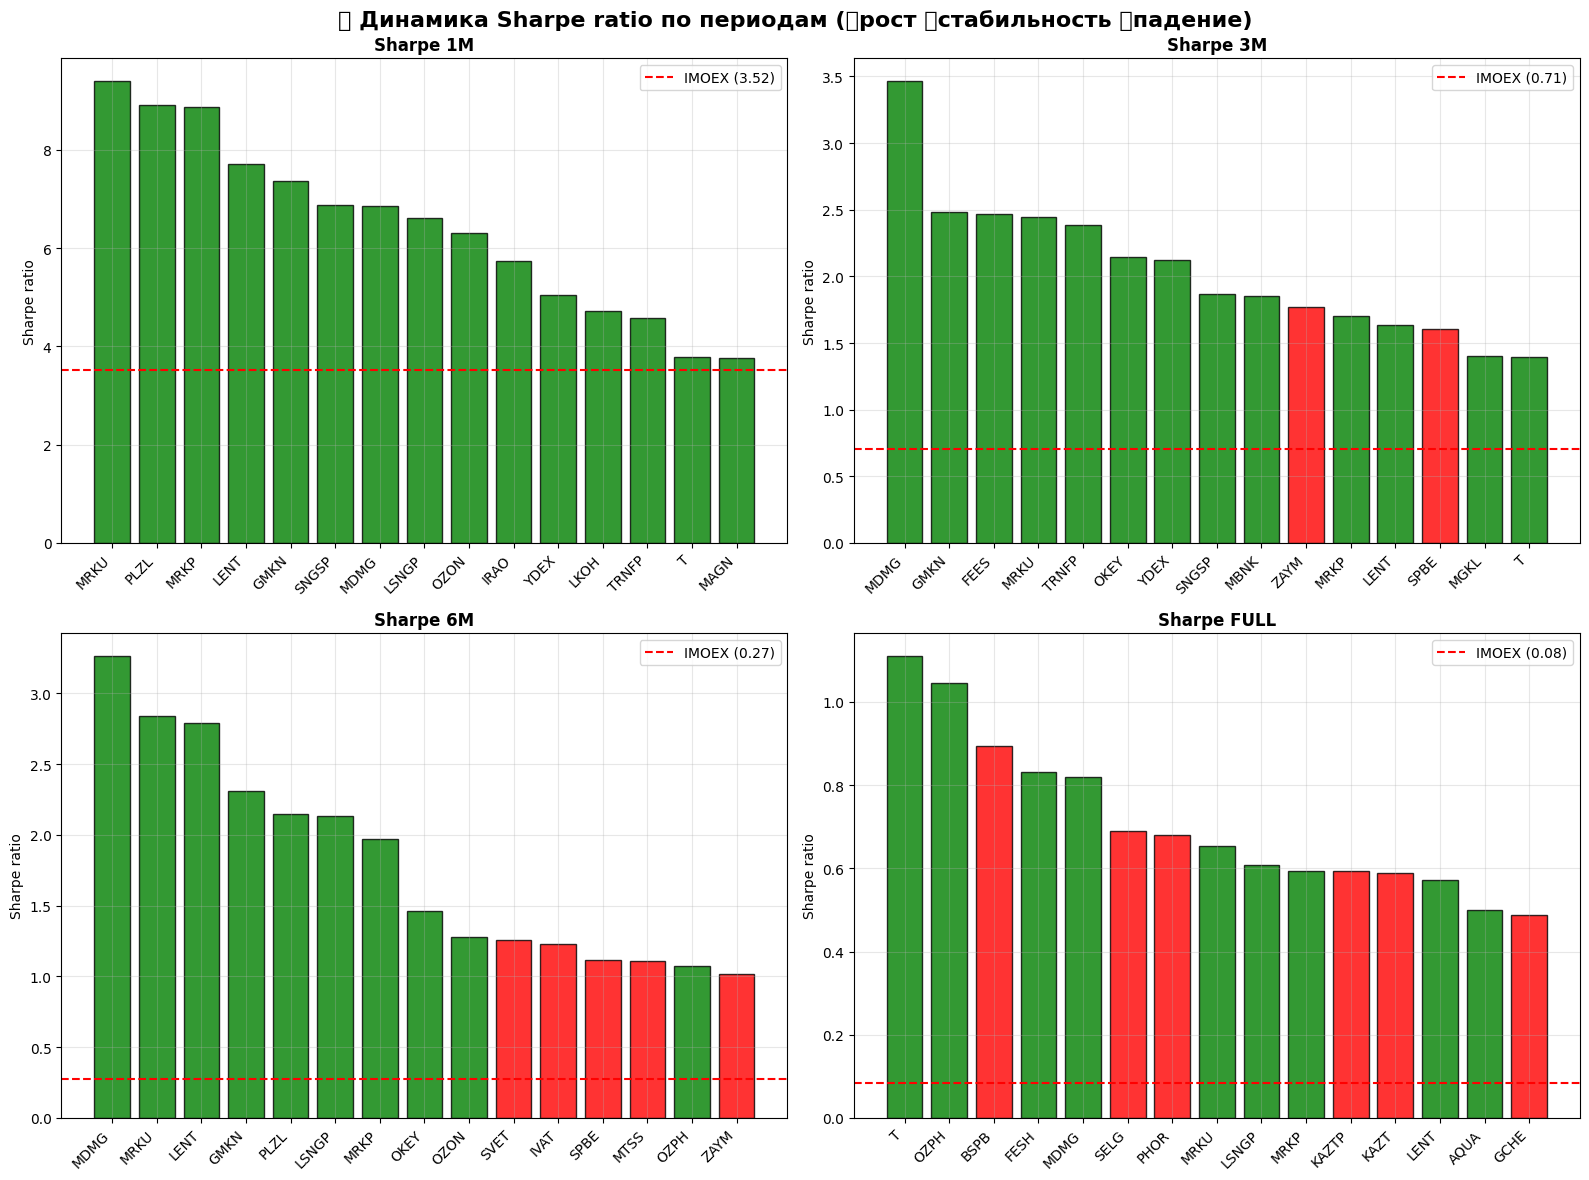


✅ ЛЕГЕНДА ЦВЕТОВ:
🟢 +5% и более — сильный рост качества (Sharpe растёт)
🟡 от -5% до +5% — стабильность / стагнация
🔴 -5% и менее — ухудшение качества (Sharpe падает)


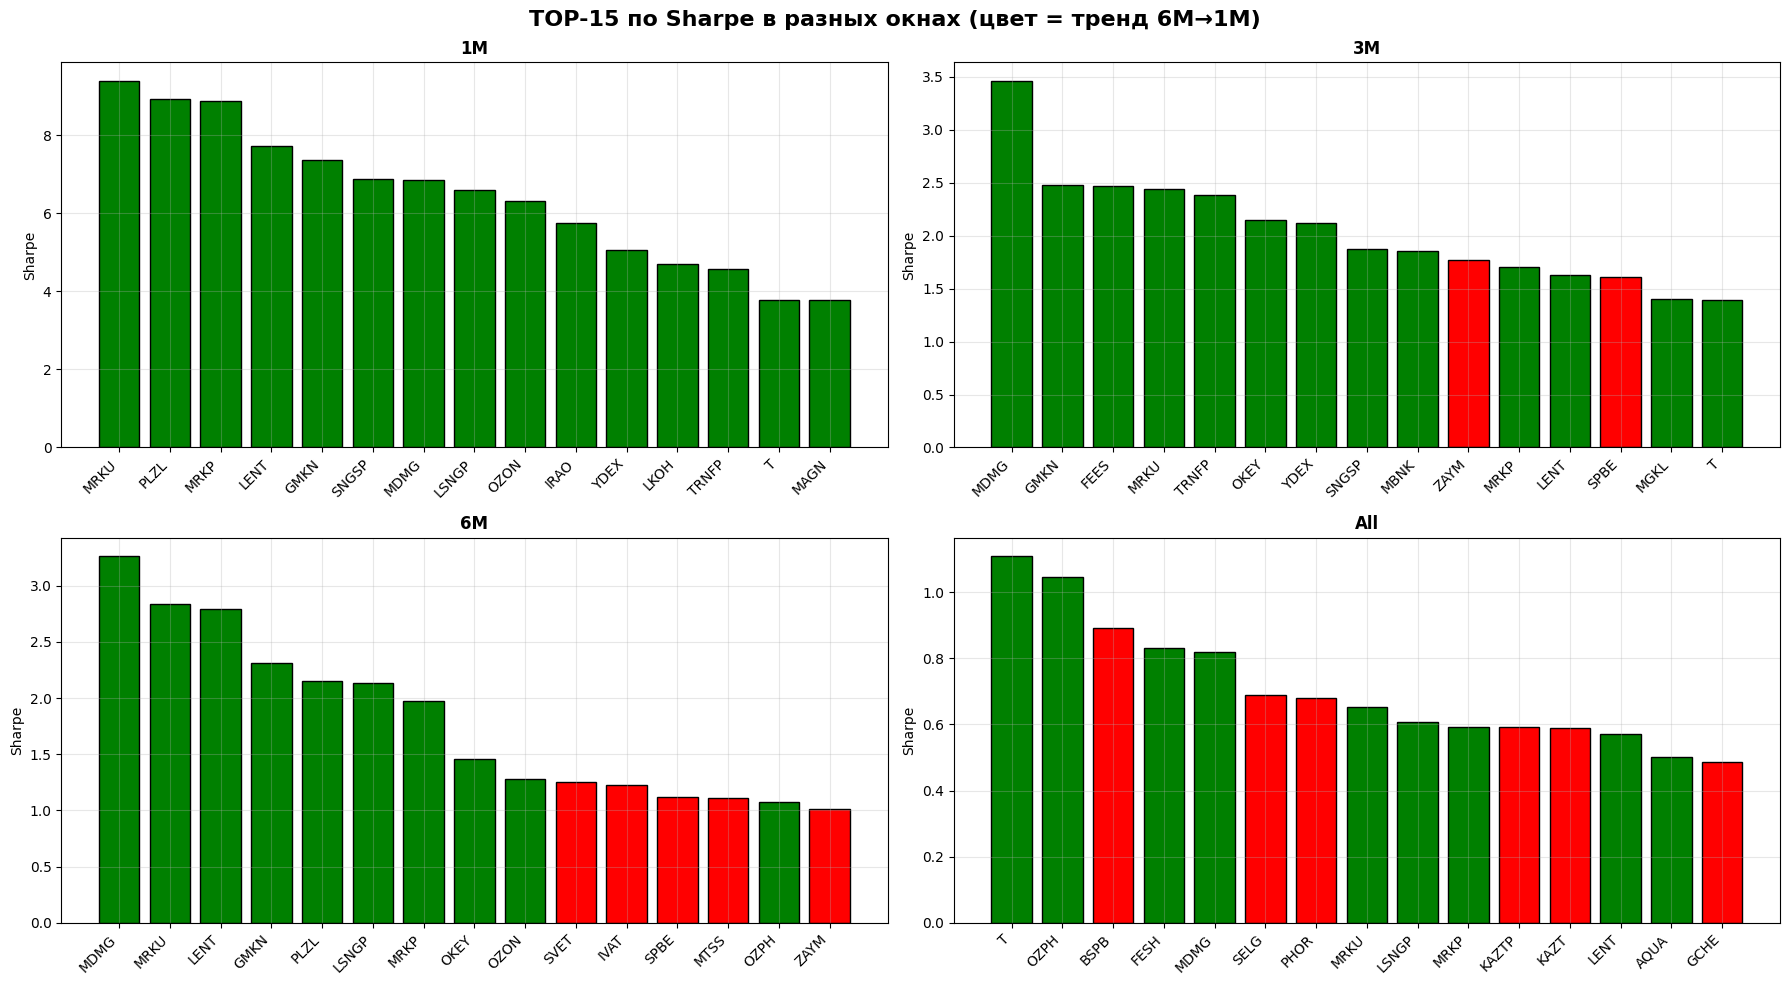

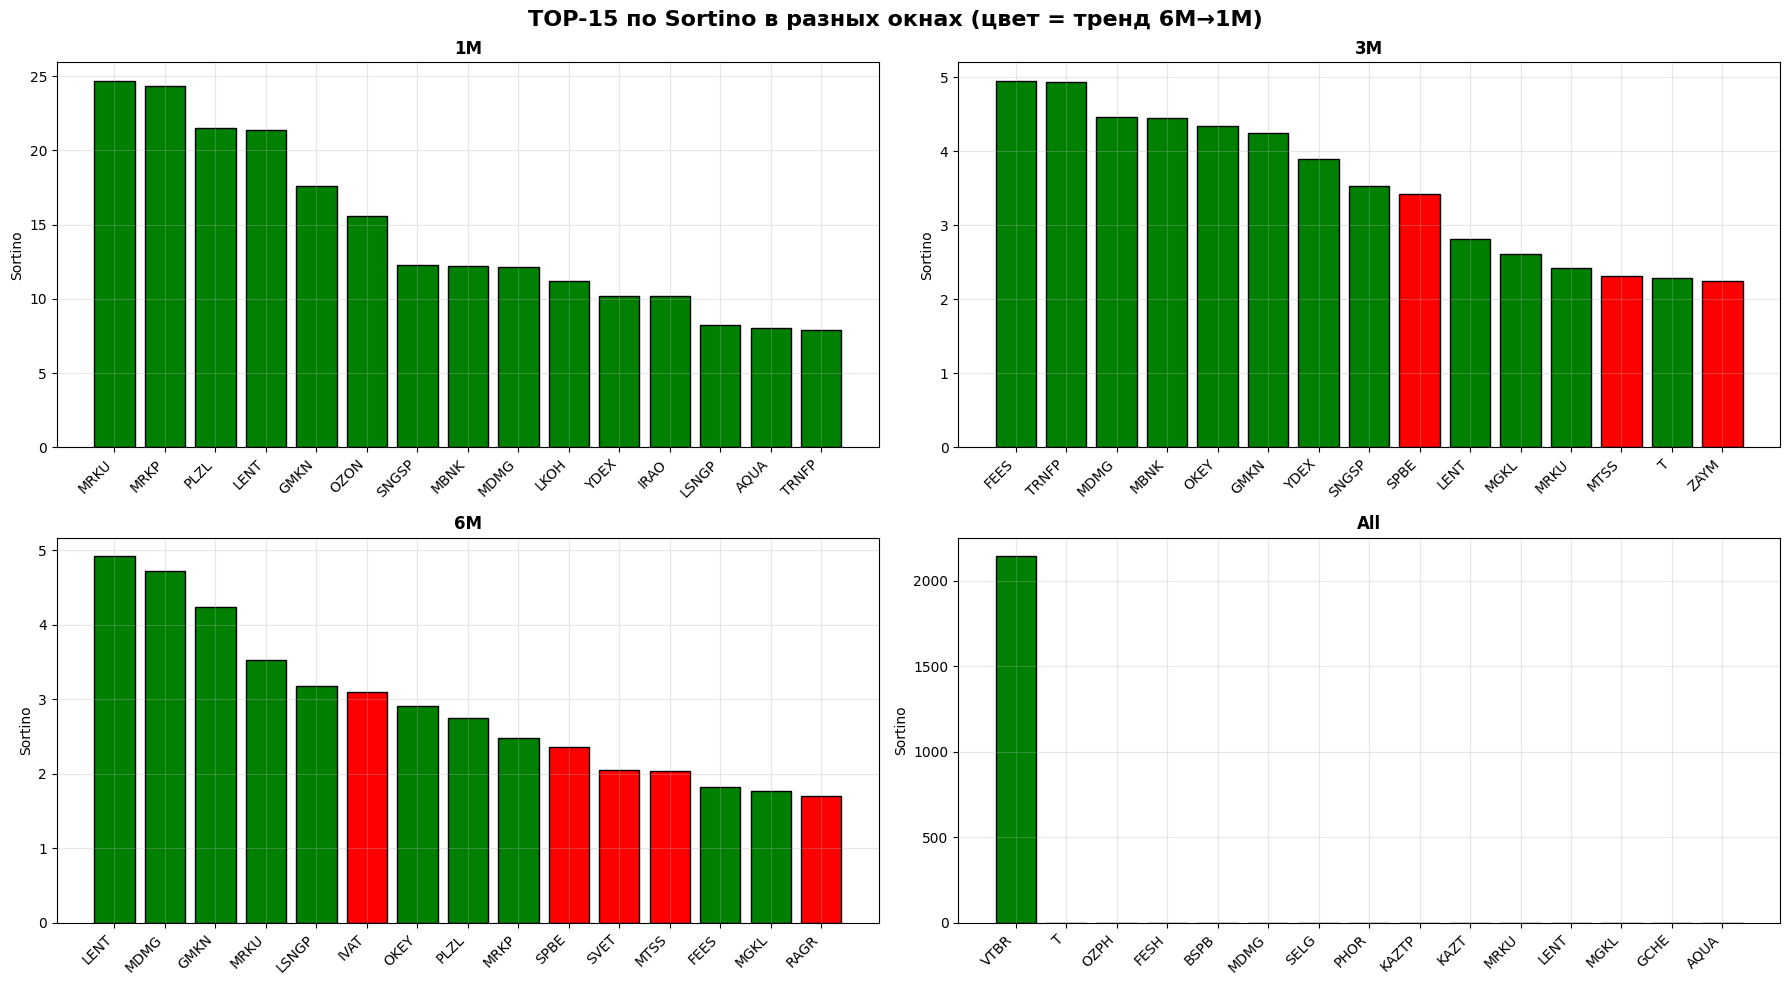

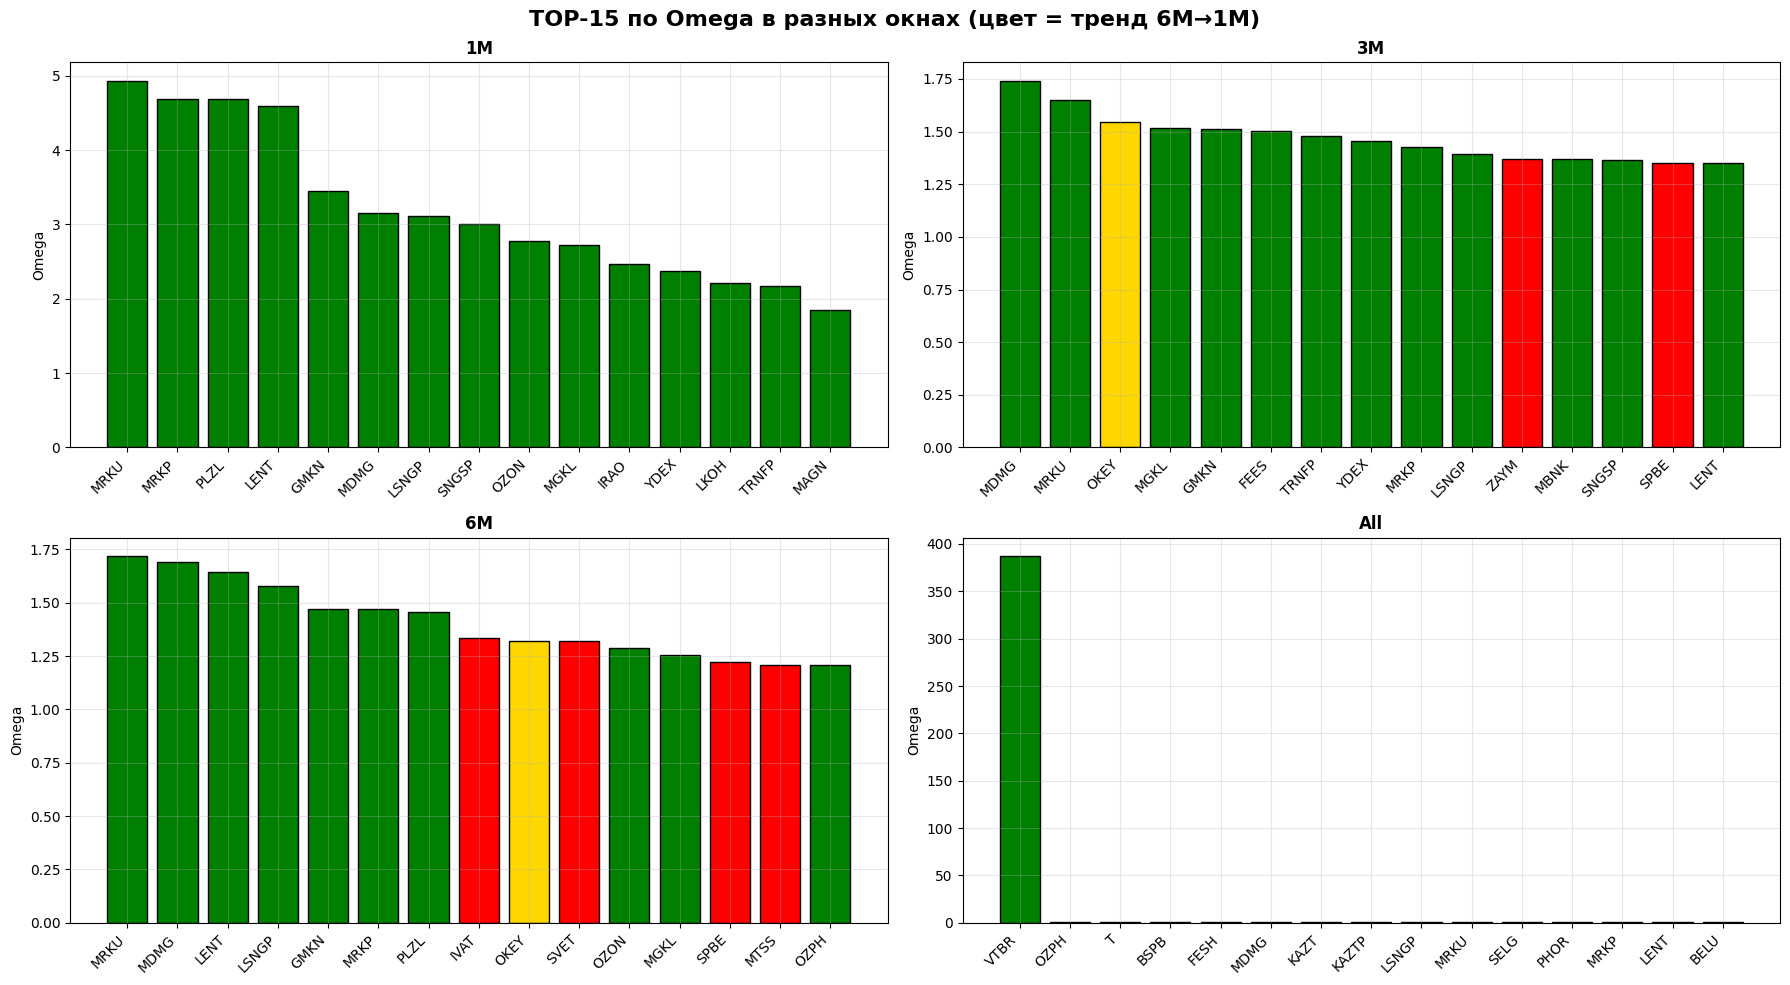

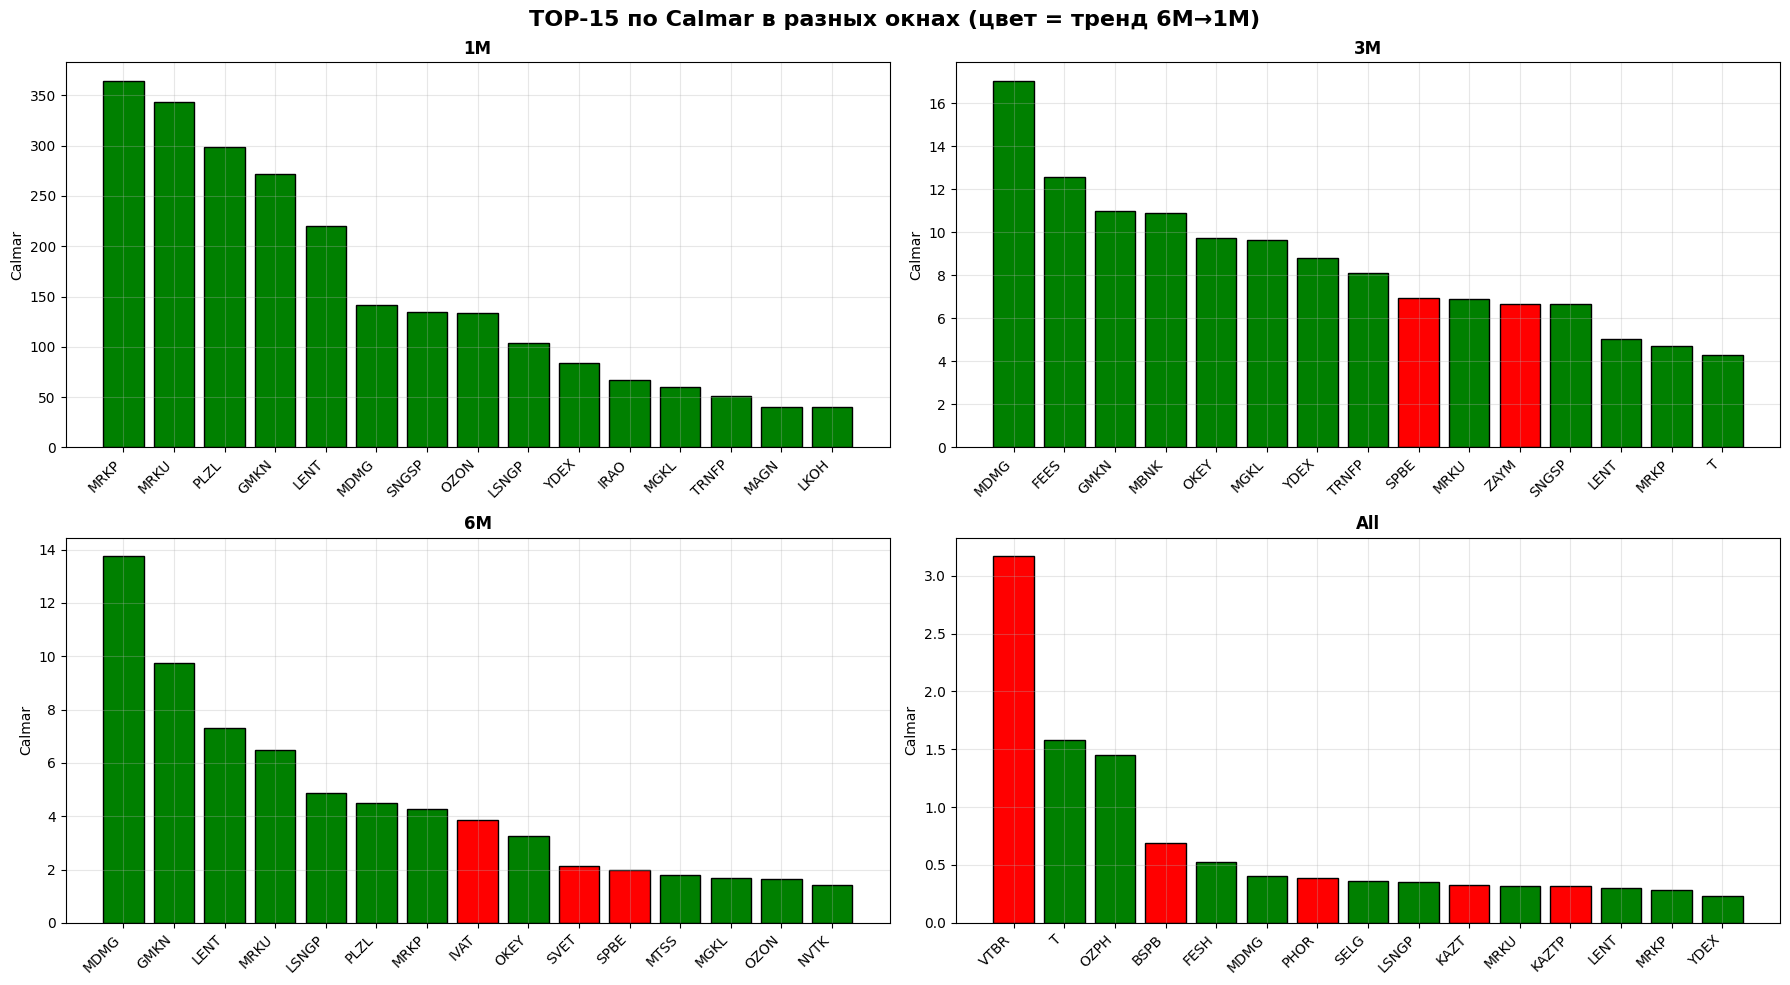

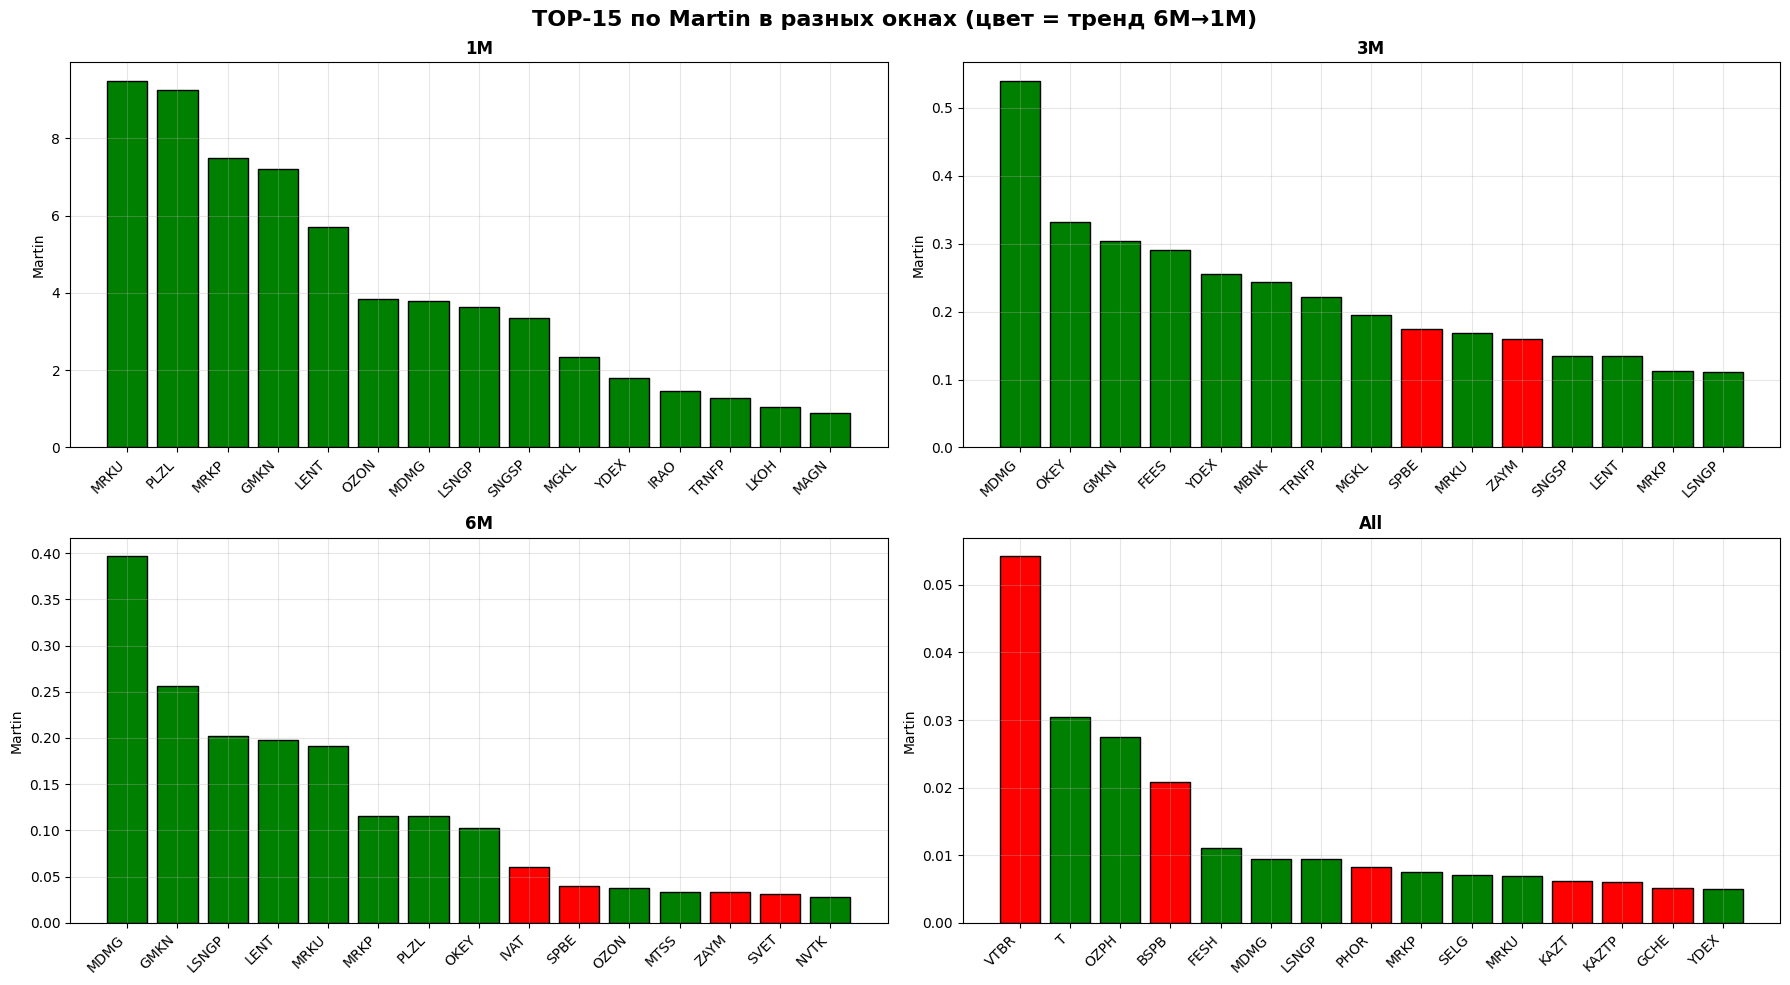


✅ ЛЕГЕНДА ЦВЕТОВ:
🟢 +5% и более — сильный рост качества (соотношение растёт)
🟡 от -5% до +5% — стабильность / стагнация
🔴 -5% и менее — ухудшение качества (соотношение падает)
FINAL RATING: топ-15 тикеров по всем соотношениям и окнам:


,1M,3M,6M,All,Score_mean
MDMG,35.0,7.0,7.0,29.0,19.50
MRKU,6.0,38.0,16.0,51.0,27.75
LENT,22.0,63.0,14.0,68.0,41.75
MRKP,11.0,68.0,35.0,63.0,44.25
LSNGP,45.0,83.0,23.0,50.0,50.25
MGKL,70.0,43.0,74.0,94.0,70.25
T,79.0,77.0,124.0,10.0,72.50
YDEX,55.0,34.0,107.0,97.0,73.25
OZON,38.0,105.0,63.0,104.0,77.50
GMKN,23.0,19.0,16.0,292.0,87.50



Топ-15 c отдельными скорингами по окнам:


,1M,3M,6M,All,Score_mean
MDMG,35.0,7.0,7.0,29.0,19.50
MRKU,6.0,38.0,16.0,51.0,27.75
LENT,22.0,63.0,14.0,68.0,41.75
MRKP,11.0,68.0,35.0,63.0,44.25
LSNGP,45.0,83.0,23.0,50.0,50.25
MGKL,70.0,43.0,74.0,94.0,70.25
T,79.0,77.0,124.0,10.0,72.50
YDEX,55.0,34.0,107.0,97.0,73.25
OZON,38.0,105.0,63.0,104.0,77.50
GMKN,23.0,19.0,16.0,292.0,87.50


MONITORING: long-term top-6 (All-based):


,Sharpe_3M,Sharpe_6M,Sortino_3M,Omega_3M,Calmar_6M,Martin_6M,Calmar_1Y,Martin_1Y,Rank_Sharpe_3M,Rank_Sortino_3M,...,Rank_Sharpe_1M,Rank_Sortino_1M,Rank_Omega_1M,TopDecile_3M,TopDecile_1M,In_top30_All,In_top30_1Y,Soft_exit,Hard_exit,Exit_flag
Ticker,,,,,,,,,,,,,,,,,,,,,
MDMG,3.462982,3.263465,4.459595,1.741760,13.755941,0.396815,4.611517,0.099485,1.0,3.0,...,7.0,9.0,6.0,1,0,1,1,0,0,0
GMKN,2.482079,2.312517,4.249170,1.513433,9.732084,0.256073,1.144488,0.021244,2.0,6.0,...,5.0,5.0,5.0,1,1,0,1,0,0,0
LENT,1.631556,2.789490,2.810994,1.351514,7.304775,0.198013,4.927466,0.140509,12.0,10.0,...,4.0,4.0,4.0,0,1,1,1,0,0,0
MRKU,2.444283,2.837644,2.429285,1.648802,6.471807,0.191113,0.930910,0.019971,4.0,12.0,...,1.0,1.0,1.0,0,1,1,1,0,0,0
LSNGP,1.332297,2.135908,1.807816,1.395798,4.875659,0.202361,2.109742,0.073557,16.0,21.0,...,8.0,13.0,7.0,0,0,1,1,0,0,0
PLZL,0.492400,2.148155,0.618343,1.093692,4.501068,0.115316,-0.908192,-0.010461,33.0,36.0,...,2.0,3.0,3.0,0,1,0,0,0,1,1
MRKP,1.701932,1.972752,1.857137,1.424712,4.262748,0.115777,2.997931,0.102456,11.0,20.0,...,3.0,2.0,2.0,0,1,1,1,0,0,0
OKEY,2.143783,1.461772,4.341622,1.543490,3.255748,0.102625,0.448208,0.008212,6.0,5.0,...,25.0,21.0,24.0,1,0,0,1,0,0,0
IVAT,0.273498,1.229604,0.561583,1.049235,3.842934,0.059943,-0.477964,-0.007457,37.0,37.0,...,41.0,41.0,42.0,0,0,0,0,1,1,1


MONITORING: 1M cascade top-6:


,Sharpe_3M,Sharpe_6M,Sortino_3M,Omega_3M,Calmar_6M,Martin_6M,Calmar_1Y,Martin_1Y,Rank_Sharpe_3M,Rank_Sortino_3M,...,Rank_Sharpe_1M,Rank_Sortino_1M,Rank_Omega_1M,TopDecile_3M,TopDecile_1M,In_top30_All,In_top30_1Y,Soft_exit,Hard_exit,Exit_flag
Ticker,,,,,,,,,,,,,,,,,,,,,
MRKU,2.444283,2.837644,2.429285,1.648802,6.471807,0.191113,0.930910,0.019971,4.0,12.0,...,1.0,1.0,1.0,0,1,1,1,0,0,0
PLZL,0.492400,2.148155,0.618343,1.093692,4.501068,0.115316,-0.908192,-0.010461,33.0,36.0,...,2.0,3.0,3.0,0,1,0,0,0,1,1
MRKP,1.701932,1.972752,1.857137,1.424712,4.262748,0.115777,2.997931,0.102456,11.0,20.0,...,3.0,2.0,2.0,0,1,1,1,0,0,0
LENT,1.631556,2.789490,2.810994,1.351514,7.304775,0.198013,4.927466,0.140509,12.0,10.0,...,4.0,4.0,4.0,0,1,1,1,0,0,0
GMKN,2.482079,2.312517,4.249170,1.513433,9.732084,0.256073,1.144488,0.021244,2.0,6.0,...,5.0,5.0,5.0,1,1,0,1,0,0,0
SNGSP,1.869613,-1.034311,3.531813,1.366135,-0.998478,-0.013711,-0.681214,-0.011409,8.0,8.0,...,6.0,7.0,8.0,0,0,1,0,0,1,1
MDMG,3.462982,3.263465,4.459595,1.741760,13.755941,0.396815,4.611517,0.099485,1.0,3.0,...,7.0,9.0,6.0,1,0,1,1,0,0,0
LSNGP,1.332297,2.135908,1.807816,1.395798,4.875659,0.202361,2.109742,0.073557,16.0,21.0,...,8.0,13.0,7.0,0,0,1,1,0,0,0
OZON,1.204042,1.279399,1.354561,1.291930,1.645971,0.037707,2.233426,0.048610,18.0,25.0,...,9.0,6.0,9.0,0,0,1,1,0,0,0



=== Recommendations for long-term top-6 (All) ===
MDMG: OK / MOMENTUM: можно удерживать, моментум и риск-профиль хорошие.
GMKN: OK / MOMENTUM: можно удерживать, моментум и риск-профиль хорошие.
LENT: OK / MOMENTUM: можно удерживать, моментум и риск-профиль хорошие.
MRKU: OK / MOMENTUM: можно удерживать, моментум и риск-профиль хорошие.
LSNGP: NEUTRAL: держать или частично сократить, смотреть динамику метрик.
PLZL: STRONG EXIT: рассматривать полный выход / замену.
MRKP: OK / MOMENTUM: можно удерживать, моментум и риск-профиль хорошие.
OKEY: OK / MOMENTUM: можно удерживать, моментум и риск-профиль хорошие.
IVAT: STRONG EXIT: рассматривать полный выход / замену.
SVET: NEUTRAL: держать или частично сократить, смотреть динамику метрик.
SPBE: NEUTRAL: держать или частично сократить, смотреть динамику метрик.
OZON: NEUTRAL: держать или частично сократить, смотреть динамику метрик.
MTSS: NEUTRAL: держать или частично сократить, смотреть динамику метрик.
MGKL: NEUTRAL: держать или частично сок

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("\n" + "="*100)
print("📊 ДИНАМИКА SHARPE RATIO: 1м / 3м / 6м / Полный период")
print("="*100)

# -------- ЦВЕТОВАЯ РАСКРАСКА --------
def color_trend(val1, val2):
    """
    Возвращает строку с эмодзи и процентом изменения, и цвет:
    🟢 рост >= +5%, 🟡 от -5% до +5%, 🔴 падение <= -5%.
    """
    if pd.isna(val1) or pd.isna(val2):
        return "n/a", "gray"
    if val1 == 0:
        diff_pct = 0
    else:
        diff_pct = (val2 - val1) / abs(val1) * 100
    if diff_pct >= 5:
        return f"🟢 +{diff_pct:.1f}%", "green"
    elif diff_pct <= -5:
        return f"🔴 {diff_pct:.1f}%", "red"
    else:
        return f"🟡 {diff_pct:+.1f}%", "yellow"

# -------- ПЕРИОДЫ ДЛЯ АНАЛИЗА --------
periods = {
    "2w": 10,       # ~2 недели
    "1m": 21,       # ~1 месяц
    "3m": 63,       # ~3 месяца
    "6m": 126,      # ~6 месяцев
    "full": len(returns)
}


# -------- РАСЧЁТ SHARPE ПО ПЕРИОДАМ ДЛЯ АКЦИЙ --------
results = []

for period_name, n_days in periods.items():
    if period_name == "full":
        period_rets = returns.copy()
    else:
        period_rets = returns.tail(n_days).dropna()

    if len(period_rets) < 10:
        print(f"⚠️ Недостаточно данных для {period_name}: {len(period_rets)} дней")
        continue

    sharpe_period = period_rets.mean() / period_rets.std() * np.sqrt(252)

    for ticker in sharpe_period.index:
        results.append({
            "Ticker": ticker,
            "Period": period_name,
            "Days": len(period_rets),
            "Sharpe": float(sharpe_period[ticker])
        })

df_results = pd.DataFrame(results)

# -------- РАСЧЁТ SHARPE ПО ПЕРИОДАМ ДЛЯ ИНДЕКСА --------
idx_results = []
for period_name, n_days in periods.items():
    if period_name == "full":
        period_idx = idx_returns.copy()
    else:
        period_idx = idx_returns.tail(n_days).dropna()

    if len(period_idx) < 10:
        print(f"⚠️ Недостаточно данных по индексу для {period_name}: {len(period_idx)} дней")
        continue

    sharpe_idx_period = period_idx.mean() / period_idx.std() * np.sqrt(252)
    idx_results.append({
        "Ticker": "IMOEX",
        "Period": period_name,
        "Days": len(period_idx),
        "Sharpe": float(sharpe_idx_period)
    })

df_idx = pd.DataFrame(idx_results)

# -------- ПИВОТ-Таблица: акции --------
pivot_sharpe = df_results.pivot(index="Ticker", columns="Period", values="Sharpe").round(3)

# -------- ПИВОТ-Таблица: индекс --------
idx_pivot = df_idx.pivot(index="Ticker", columns="Period", values="Sharpe").round(3)

# -------- ОБЪЕДИНЯЕМ АКЦИИ + ИНДЕКС --------
pivot_sharpe = pd.concat([pivot_sharpe, idx_pivot])

# Убедимся, что есть все нужные столбцы
for col in ["1m", "3m", "6m", "full"]:
    if col not in pivot_sharpe.columns:
        pivot_sharpe[col] = np.nan

# -------- ДОБАВЛЯЕМ ПРОЦЕНТЫ ИЗМЕНЕНИЙ 🟢🟡🔴 --------
trend_3m_6m = []
trend_1m_3m = []

for ticker in pivot_sharpe.index:
    s6m = pivot_sharpe.loc[ticker, "6m"]
    s3m = pivot_sharpe.loc[ticker, "3m"]
    s1m = pivot_sharpe.loc[ticker, "1m"]
    t36, _ = color_trend(s6m, s3m)
    t13, _ = color_trend(s3m, s1m)
    trend_3m_6m.append(t36)
    trend_1m_3m.append(t13)

pivot_sharpe["3m↔6m"] = trend_3m_6m
pivot_sharpe["1m↔3m"] = trend_1m_3m

print("\n📈 Sharpe ratio по периодам + 🟢🟡🔴 динамика:")
print(
    pivot_sharpe
    .sort_values("6m", ascending=False)
    [["1m", "3m", "6m", "full", "3m↔6m", "1m↔3m"]]
)

# -------- ТОП-10 ПО 6-МЕСЯЧНОМУ SHARPE --------
print("\n🏆 ТОП-6 по Sharpe за 6 месяцев:")
top10_6m = pivot_sharpe.drop(index=["IMOEX"], errors="ignore").nlargest(10, "6m")
print(top10_6m[["1m", "3m", "6m", "full", "3m↔6m", "1m↔3m"]])

# -------- РЕЙТИНГ ПО ОБЩЕМУ ИЗМЕНЕНИЮ SHARPE (6м → 1м) --------
print("\n🚀 ТОП-5 по общему улучшению Sharpe (6м → 1м):")
total_improvement = pivot_sharpe["1m"] - pivot_sharpe["6m"]
print(total_improvement.sort_values(ascending=False).head(10).round(3))

print("\n📉 ТОП-5 по общему ухудшению Sharpe (6м → 1м):")
print(total_improvement.sort_values().head(10).round(3))

# === 0. ОКНА ДЛЯ МОНИТОРИНГА ===
windows = {
    "All": None,
    "1Y": 252,
    "6M": 126,
    "3M": 63,
    "1M": 21,
}

trading_days = 252
risk_free = 0.0

def sharpe_ratio(r):
    if len(r) == 0 or r.std() == 0:
        return np.nan
    mean_excess = r.mean() - risk_free / trading_days
    return np.sqrt(trading_days) * mean_excess / r.std()

def sortino_ratio(r):
    if len(r) == 0:
        return np.nan
    d = r[r < 0]
    if d.std() == 0:
        return np.nan
    mean_excess = r.mean() - risk_free / trading_days
    return np.sqrt(trading_days) * mean_excess / d.std()

def omega_ratio(r, threshold=0.0):
    if len(r) == 0:
        return np.nan
    gains = r[r > threshold] - threshold
    losses = threshold - r[r < threshold]
    if losses.sum() == 0:
        return np.nan
    return gains.sum() / losses.sum()

def max_drawdown(cum):
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

def calmar_ratio(r):
    if len(r) == 0:
        return np.nan
    cum = (1 + r).cumprod()
    mdd = max_drawdown(cum)
    if mdd == 0 or np.isnan(mdd):
        return np.nan
    ann_ret = (1 + r).prod() ** (trading_days / len(r)) - 1
    return ann_ret / abs(mdd)

def martin_ratio(r):
    if len(r) == 0:
        return np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd_pct = 100 * (cum - peak) / peak
    ulcer = np.sqrt((dd_pct ** 2).mean())
    if ulcer == 0:
        return np.nan
    ann_ret = (1 + r).prod() ** (trading_days / len(r)) - 1
    return ann_ret / ulcer

def compute_ratios_block(rets, windows):
    results = {}
    for name, w in windows.items():
        r_win = rets if w is None else rets.iloc[-w:]
        ratios = { "Sharpe": [], "Sortino": [], "Omega": [], "Calmar": [], "Martin": [] }
        for t in r_win.columns:
            r = r_win[t].dropna()
            ratios["Sharpe"].append(sharpe_ratio(r))
            ratios["Sortino"].append(sortino_ratio(r))
            ratios["Omega"].append(omega_ratio(r))
            ratios["Calmar"].append(calmar_ratio(r))
            ratios["Martin"].append(martin_ratio(r))
        results[name] = pd.DataFrame(ratios, index=r_win.columns)
    return results

# считаем метрики для MOEX-акций
results_port = compute_ratios_block(returns, windows)


# -------- ВИЗУАЛИЗАЦИЯ С ЦВЕТАМИ (общий тренд 6м→1м) --------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
period_cols = ["1m", "3m", "6m", "full"]

# Цвет по общему тренду 6м→1м
colors_by_ticker = {}
for ticker in pivot_sharpe.index:
    s6m = pivot_sharpe.loc[ticker, "6m"]
    s1m = pivot_sharpe.loc[ticker, "1m"]
    _, c = color_trend(s6m, s1m)
    colors_by_ticker[ticker] = c

for i, col in enumerate(period_cols):
    ax = axes[i//2, i%2]
    # ТОП-15 по Sharpe в данном периоде (без IMOEX)
    top10 = pivot_sharpe.drop(index=["IMOEX"], errors="ignore").nlargest(15, col)
    colors10 = [colors_by_ticker[t] for t in top10.index]

    ax.bar(range(len(top10)), top10[col], color=colors10, alpha=0.8, edgecolor="black")
    if "IMOEX" in pivot_sharpe.index:
        ax.axhline(
            y=pivot_sharpe.loc["IMOEX", col],
            color="red",
            linestyle="--",
            label=f"IMOEX ({pivot_sharpe.loc['IMOEX', col]:.2f})"
        )
    ax.set_title(f"Sharpe {col.upper()}", fontweight="bold")
    ax.set_ylabel("Sharpe ratio")
    ax.set_xticks(range(len(top10)))
    ax.set_xticklabels(top10.index, rotation=45, ha="right")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("🔥 Динамика Sharpe ratio по периодам (🟢рост 🟡стабильность 🔴падение)",
             fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print("\n✅ ЛЕГЕНДА ЦВЕТОВ:")
print("🟢 +5% и более — сильный рост качества (Sharpe растёт)")
print("🟡 от -5% до +5% — стабильность / стагнация")
print("🔴 -5% и менее — ухудшение качества (Sharpe падает)")

# функция цветовой раскраски (как выше)
def color_trend(val1, val2):
    if pd.isna(val1) or pd.isna(val2):
        return "n/a", "gray"
    if val1 == 0:
        diff_pct = 0
    else:
        diff_pct = (val2 - val1) / abs(val1) * 100
    if diff_pct >= 5:
        return f"🟢 +{diff_pct:.1f}%", "green"
    elif diff_pct <= -5:
        return f"🔴 {diff_pct:.1f}%", "red"
    else:
        return f"🟡 {diff_pct:+.1f}%", "gold"

# =========================================
# ТОП-15 АКЦИЙ ПО ВСЕМ МЕТРИКАМ В КАЖДОМ ОКНЕ С ЦВЕТАМИ
# =========================================

metrics = ["Sharpe", "Sortino", "Omega", "Calmar", "Martin"]
windows_plot = ["1M", "3M", "6M", "All"]

for metric in metrics:
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()
    fig.suptitle(f"TOP-15 по {metric} в разных окнах (цвет = тренд 6M→1M)",
                 fontsize=16, fontweight="bold")

    # заранее считаем значения метрики на 6M и 1M для цветов
    m6 = results_port["6M"][metric]
    m1 = results_port["1M"][metric]

    # словарь цветовых меток по тикеру (общий тренд 6M→1M)
    colors_by_ticker = {}
    for t in results_port["6M"].index:
        v6 = m6.get(t, np.nan)
        v1 = m1.get(t, np.nan)
        _, c = color_trend(v6, v1)
        colors_by_ticker[t] = c

    for i, win in enumerate(windows_plot):
        ax = axes[i]
        df = results_port[win].copy()
        df = df.drop(index=["IMOEX", "SPY", "QQQ"], errors="ignore")
        df = df[df[metric].notna()]

        top15 = df.nlargest(15, metric)
        colors15 = [colors_by_ticker.get(t, "gray") for t in top15.index]

        ax.bar(range(len(top15)), top15[metric], color=colors15, edgecolor="black")
        ax.set_title(f"{win}", fontweight="bold")
        ax.set_ylabel(metric)
        ax.set_xticks(range(len(top15)))
        ax.set_xticklabels(top15.index, rotation=45, ha="right")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n✅ ЛЕГЕНДА ЦВЕТОВ:")
print("🟢 +5% и более — сильный рост качества (соотношение растёт)")
print("🟡 от -5% до +5% — стабильность / стагнация")
print("🔴 -5% и менее — ухудшение качества (соотношение падает)")

# =========================================
# ФИНАЛЬНЫЙ РЕЙТИНГ ПО ВСЕМ МЕТРИКАМ И ОКНАМ
# =========================================

windows_rank = ["1M", "3M", "6M", "All"]
metrics_rank = ["Sharpe", "Sortino", "Omega", "Calmar", "Martin"]

# общий список тикеров
all_tickers = results_port["All"].index

# таблица для хранения суммарных скорингов по каждому окну
scores_by_window = {w: pd.Series(index=all_tickers, dtype=float) for w in windows_rank}

for w in windows_rank:
    df = results_port[w].copy()
    # убираем бенчмарки, если они попали в портфель
    df = df.drop(index=["IMOEX","SPY","QQQ"], errors="ignore")

    # считаем ранги по каждой метрике (меньше ранг = лучше)
    rank_sum = pd.Series(0.0, index=df.index)
    for m in metrics_rank:
        r = df[m].rank(ascending=False)
        rank_sum = rank_sum + r

    scores_by_window[w] = rank_sum

# собираем в один DataFrame
scores_df = pd.DataFrame(scores_by_window)

# средний скор по всем окнам
scores_df["Score_mean"] = scores_df.mean(axis=1)

# финальный рейтинг: чем меньше Score_mean, тем лучше
final_rank = scores_df.sort_values("Score_mean")

print("FINAL RATING: топ-15 тикеров по всем соотношениям и окнам:")
top15_final = final_rank.head(15)
display(top15_final)

print("\nТоп-15 c отдельными скорингами по окнам:")
display(top15_final[["1M","3M","6M","All","Score_mean"]])


# рейтинг по 6-месячному окну
base_6m = results_port["6M"].copy()
base_6m["Rank_Sharpe_6M"] = base_6m["Sharpe"].rank(ascending=False)
base_6m["Rank_Calmar_6M"] = base_6m["Calmar"].rank(ascending=False)
base_6m["Score_long_6M"] = base_6m["Rank_Sharpe_6M"] + base_6m["Rank_Calmar_6M"]
base_6m_sorted = base_6m.sort_values("Score_long_6M")

top_6_6m = base_6m_sorted.head(15)   # долгосрочный топ-6 на горизонте 6M

top_6_1m = results_port["1M"].sort_values("Sharpe", ascending=False).head(15)

# =========================================
# MONITORING FUNCTION
# =========================================

def build_monitor_for_set(tickers, results_port):
    # ранги по Sharpe/Sortino/Omega
    ranks_3m = results_port["3M"][["Sharpe","Sortino","Omega"]].rank(ascending=False)
    ranks_1m = results_port["1M"][["Sharpe","Sortino","Omega"]].rank(ascending=False)

    # ранги по Sharpe+Calmar для All и 1Y
    rank_all = (
        results_port["All"][["Sharpe","Calmar"]]
        .assign(Score=lambda df: df["Sharpe"].rank(ascending=False)
                              + df["Calmar"].rank(ascending=False))
    )
    rank_1y = (
        results_port["1Y"][["Sharpe","Calmar"]]
        .assign(Score=lambda df: df["Sharpe"].rank(ascending=False)
                              + df["Calmar"].rank(ascending=False))
    )

    top30_all = rank_all["Score"].rank().nsmallest(30).index
    top30_1y  = rank_1y["Score"].rank().nsmallest(30).index

    rows = []
    for t in tickers:
        row = {"Ticker": t}
        # значения метрик
        for h in ["3M","6M"]:
            row[f"Sharpe_{h}"]  = results_port[h].loc[t, "Sharpe"]
        row["Sortino_3M"] = results_port["3M"].loc[t, "Sortino"]
        row["Omega_3M"]   = results_port["3M"].loc[t, "Omega"]
        for h in ["6M","1Y"]:
            row[f"Calmar_{h}"] = results_port[h].loc[t, "Calmar"]
            row[f"Martin_{h}"] = results_port[h].loc[t, "Martin"]

        # ранги
        row["Rank_Sharpe_3M"]  = ranks_3m.loc[t, "Sharpe"]
        row["Rank_Sortino_3M"] = ranks_3m.loc[t, "Sortino"]
        row["Rank_Omega_3M"]   = ranks_3m.loc[t, "Omega"]
        row["Rank_Sharpe_1M"]  = ranks_1m.loc[t, "Sharpe"]
        row["Rank_Sortino_1M"] = ranks_1m.loc[t, "Sortino"]
        row["Rank_Omega_1M"]   = ranks_1m.loc[t, "Omega"]

        n_universe = len(results_port["3M"])

        row["TopDecile_3M"] = int(
            (row["Rank_Sharpe_3M"]  <= 0.1 * n_universe) and
            (row["Rank_Sortino_3M"] <= 0.1 * n_universe) and
            (row["Rank_Omega_3M"]   <= 0.1 * n_universe)
        )
        row["TopDecile_1M"] = int(
            (row["Rank_Sharpe_1M"]  <= 0.1 * n_universe) and
            (row["Rank_Sortino_1M"] <= 0.1 * n_universe) and
            (row["Rank_Omega_1M"]   <= 0.1 * n_universe)
        )

        row["In_top30_All"] = int(t in top30_all)
        row["In_top30_1Y"]  = int(t in top30_1y)

        rows.append(row)

    monitor = pd.DataFrame(rows).set_index("Ticker")

    # пороги для сигналов
    med_sharpe_3m  = results_port["3M"]["Sharpe"].median()
    med_sortino_3m = results_port["3M"]["Sortino"].median()
    med_martin_1y  = results_port["1Y"]["Martin"].median()

    # мягкий сигнал
    monitor["Soft_exit"] = (
        (monitor["Sharpe_3M"]  < med_sharpe_3m) &
        (monitor["Sortino_3M"] < med_sortino_3m) &
        (monitor["Omega_3M"]   < 1.1)
    ).astype(int)

    # жёсткий сигнал
    monitor["Hard_exit"] = (
        ((monitor["In_top30_All"] == 0) | (monitor["In_top30_1Y"] == 0)) &
        (monitor["Calmar_1Y"] < 0.3) &
        (monitor["Martin_1Y"] < med_martin_1y)
    ).astype(int)

    monitor["Exit_flag"] = monitor[["Soft_exit","Hard_exit"]].max(axis=1)

    return monitor


# топ-6 по All и по 1M
tickers_all = list(top_6_6m.index)
tickers_1m  = list(top_6_1m.index)

monitor_all = build_monitor_for_set(tickers_all, results_port)
monitor_1m  = build_monitor_for_set(tickers_1m,  results_port)

print("MONITORING: long-term top-6 (All-based):")
display(monitor_all)

print("MONITORING: 1M cascade top-6:")
display(monitor_1m)

# Простые текстовые рекомендации
def describe_status(monitor_df, label):
    print(f"\n=== Recommendations for {label} ===")
    for t, row in monitor_df.iterrows():
        if row["Hard_exit"] == 1:
            status = "STRONG EXIT: рассматривать полный выход / замену."
        elif row["Soft_exit"] == 1:
            status = "SOFT EXIT: снизить вес, держать под наблюдением."
        elif (row["TopDecile_3M"] == 1) or (row["TopDecile_1M"] == 1):
            status = "OK / MOMENTUM: можно удерживать, моментум и риск-профиль хорошие."
        else:
            status = "NEUTRAL: держать или частично сократить, смотреть динамику метрик."
        print(f"{t}: {status}")

describe_status(monitor_all, "long-term top-6 (All)")
describe_status(monitor_1m,  "1M cascade top-6")




In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("\n" + "="*120)
print("📊 ДИНАМИКА SHARPE RATIO: 1м / 3м / 6м / Полный период + МЕТРИКИ ДЛЯ ГИПОТЕЗЫ РОСТА")
print("="*120)

# -------- ЦВЕТОВАЯ РАСКРАСКА --------
def color_trend(val1, val2):
    """
    Возвращает строку с эмодзи и процентом изменения, и цвет:
    🟢 рост >= +5%, 🟡 от -5% до +5%, 🔴 падение <= -5%.
    """
    if pd.isna(val1) or pd.isna(val2):
        return "n/a", "gray"
    if val1 == 0:
        diff_pct = 0
    else:
        diff_pct = (val2 - val1) / abs(val1) * 100
    if diff_pct >= 5:
        return f"🟢 +{diff_pct:.1f}%", "green"
    elif diff_pct <= -5:
        return f"🔴 {diff_pct:.1f}%", "red"
    else:
        return f"🟡 {diff_pct:+.1f}%", "yellow"

# -------- ПЕРИОДЫ ДЛЯ АНАЛИЗА --------
periods = {
    "1m": 21,      # ~1 месяц
    "3m": 63,      # ~3 месяца
    "6m": 126,     # ~6 месяцев
    "full": len(returns)
}

# -------- SHARPE ПО ПЕРИОДАМ ДЛЯ АКЦИЙ --------
results = []
for period_name, n_days in periods.items():
    if period_name == "full":
        period_rets = returns.copy()
    else:
        period_rets = returns.tail(n_days).dropna()

    if len(period_rets) < 10:
        print(f"⚠️ Недостаточно данных для {period_name}: {len(period_rets)} дней")
        continue

    sharpe_period = period_rets.mean() / period_rets.std() * np.sqrt(252)
    for ticker in sharpe_period.index:
        results.append({
            "Ticker": ticker,
            "Period": period_name,
            "Days": len(period_rets),
            "Sharpe": float(sharpe_period[ticker])
        })

df_results = pd.DataFrame(results)

# -------- SHARPE ПО ПЕРИОДАМ ДЛЯ ИНДЕКСА --------
idx_results = []
for period_name, n_days in periods.items():
    if period_name == "full":
        period_idx = idx_returns.copy()
    else:
        period_idx = idx_returns.tail(n_days).dropna()

    if len(period_idx) < 10:
        print(f"⚠️ Недостаточно данных по индексу для {period_name}: {len(period_idx)} дней")
        continue

    sharpe_idx_period = period_idx.mean() / period_idx.std() * np.sqrt(252)
    idx_results.append({
        "Ticker": "IMOEX",
        "Period": period_name,
        "Days": len(period_idx),
        "Sharpe": float(sharpe_idx_period)
    })

df_idx = pd.DataFrame(idx_results)

# -------- ПИВОТ-Таблица: акции + индекс --------
pivot_sharpe = df_results.pivot(index="Ticker", columns="Period", values="Sharpe").round(3)
idx_pivot = df_idx.pivot(index="Ticker", columns="Period", values="Sharpe").round(3)
pivot_sharpe = pd.concat([pivot_sharpe, idx_pivot])

for col in ["1m", "3m", "6m", "full"]:
    if col not in pivot_sharpe.columns:
        pivot_sharpe[col] = np.nan

# -------- ПРОЦЕНТНЫЕ ИЗМЕНЕНИЯ SHARPE (эмодзи) --------
trend_3m_6m = []
trend_1m_3m = []
for ticker in pivot_sharpe.index:
    s6m = pivot_sharpe.loc[ticker, "6m"]
    s3m = pivot_sharpe.loc[ticker, "3m"]
    s1m = pivot_sharpe.loc[ticker, "1m"]
    t36, _ = color_trend(s6m, s3m)
    t13, _ = color_trend(s3m, s1m)
    trend_3m_6m.append(t36)
    trend_1m_3m.append(t13)

pivot_sharpe["3m↔6m"] = trend_3m_6m
pivot_sharpe["1m↔3m"] = trend_1m_3m

print("\n📈 Sharpe ratio по периодам + 🟢🟡🔴 динамика:")
print(
    pivot_sharpe
    .sort_values("6m", ascending=False)
    [["1m", "3m", "6m", "full", "3m↔6m", "1m↔3m"]]
)

# -------- ДОХОДНОСТЬ ТИКЕРА И ИНДЕКСА ЗА 1м / 3м / 6м --------
def period_return(prices_series, n_days):
    if len(prices_series) <= n_days:
        return np.nan
    return prices_series.iloc[-1] / prices_series.iloc[-n_days] - 1

ret_1m = {}
ret_3m = {}
ret_6m = {}

for ticker in pivot_sharpe.index:
    if ticker == "IMOEX":
        series = idx_prices
    else:
        series = data[ticker]
    ret_1m[ticker] = period_return(series, 21)
    ret_3m[ticker] = period_return(series, 63)
    ret_6m[ticker] = period_return(series, 126)

rets_df = pd.DataFrame({
    "Ret_1m": ret_1m,
    "Ret_3m": ret_3m,
    "Ret_6m": ret_6m,
})

# Премия к индексу по доходности
if "IMOEX" in rets_df.index:
    idx_1m = rets_df.loc["IMOEX", "Ret_1m"]
    idx_3m = rets_df.loc["IMOEX", "Ret_3m"]
    idx_6m = rets_df.loc["IMOEX", "Ret_6m"]
else:
    idx_1m = idx_3m = idx_6m = np.nan

rets_df["Ret_1m_vs_Idx"] = rets_df["Ret_1m"] - idx_1m
rets_df["Ret_3m_vs_Idx"] = rets_df["Ret_3m"] - idx_3m
rets_df["Ret_6m_vs_Idx"] = rets_df["Ret_6m"] - idx_6m

# -------- ОБЪЕДИНЁННАЯ ТАБЛИЦА: Sharpe + доходности --------
full_table = pivot_sharpe.join(rets_df)

# Переводим доходности и премии в проценты
table_for_print = full_table.copy()
for col in ["Ret_1m", "Ret_1m_vs_Idx", "Ret_3m", "Ret_3m_vs_Idx", "Ret_6m", "Ret_6m_vs_Idx"]:
    table_for_print[col] = table_for_print[col] * 100

print("\n📈 Sharpe + доходность и премия к индексу (в %, кроме Sharpe):")
print(
    table_for_print
    .sort_values("6m", ascending=False)
    [[
        "1m", "3m", "6m", "full",
        "3m↔6m", "1m↔3m",
        "Ret_1m", "Ret_1m_vs_Idx",
        "Ret_3m", "Ret_3m_vs_Idx",
        "Ret_6m", "Ret_6m_vs_Idx",
    ]].round(2)
)

# -------- КОРРЕЛЯЦИЯ Sharpe_6m vs премия доходности_6m --------
corr_sharpe_ret = full_table[["6m", "Ret_6m_vs_Idx"]].corr().iloc[0, 1]
print(f"\n🔗 Корреляция Sharpe_6m и премии доходности за 6м: {corr_sharpe_ret:.2f}")

# -------- ROLLING SHARPE (3-месячное окно) --------
window = 63  # 3 месяца

roll_mean = returns.rolling(window).mean()
roll_std = returns.rolling(window).std()
roll_sharpe = (roll_mean / roll_std) * np.sqrt(252)

roll_mean_idx = idx_returns.rolling(window).mean()
roll_std_idx = idx_returns.rolling(window).std()
roll_sharpe_idx = (roll_mean_idx / roll_std_idx) * np.sqrt(252)

# Премия rolling-Sharpe к индексу
roll_sharpe_premium = roll_sharpe.sub(roll_sharpe_idx, axis=0)

# Метрики на "сейчас" и тренд за 1 месяц
lookback_trend = 21  # 1 месяц

current_sharpe = roll_sharpe.iloc[-1]
current_premium = roll_sharpe_premium.iloc[-1]

trend_sharpe = roll_sharpe.iloc[-1] - roll_sharpe.iloc[-lookback_trend]
trend_premium = roll_sharpe_premium.iloc[-1] - roll_sharpe_premium.iloc[-lookback_trend]

rolling_metrics = pd.DataFrame({
    "Sharpe_now": current_sharpe,
    "Sharpe_premium_now": current_premium,
    "Sharpe_trend_1m": trend_sharpe,
    "Premium_trend_1m": trend_premium,
}).round(3)

print("\n📊 Rolling-метрики качества (3м окно, тренд за 1м):")
print(rolling_metrics.sort_values("Sharpe_premium_now", ascending=False).head(10))

# -------- ПОРТФЕЛИ ПО SHARPE: 6м и 3м --------

# Топ-10 по Sharpe за 6м (как было)
top10_by_6m_sharpe = (
    full_table.drop(index=["IMOEX"], errors="ignore")
    .sort_values("6m", ascending=False)
    .head(10)
    .index.tolist()
)

# Новый: Топ-10 по Sharpe за 3м
top10_by_3m_sharpe = (
    full_table.drop(index=["IMOEX"], errors="ignore")
    .sort_values("3m", ascending=False)
    .head(10)
    .index.tolist()
)

print("\n🏆 ТОП-10 по Sharpe за 6м (кандидаты для портфеля 6м):", top10_by_6m_sharpe)
print("🏆 ТОП-10 по Sharpe за 3м (кандидаты для портфеля 3м):", top10_by_3m_sharpe)

# -------- ДОХОДНОСТЬ ПОРТФЕЛЕЙ ЗА 1 МЕСЯЦ --------

# Доходности кандидатов в портфель 6м за 1м
port6_1m_rets = rets_df.loc[top10_by_6m_sharpe, "Ret_1m"]
port6_1m_ret_eq = port6_1m_rets.mean()   # равные веса

# Доходности кандидатов в портфель 3м за 1м
port3_1m_rets = rets_df.loc[top10_by_3m_sharpe, "Ret_1m"]
port3_1m_ret_eq = port3_1m_rets.mean()

# Доходность индекса за 1м для сравнения (уже есть в rets_df)
if "IMOEX" in rets_df.index:
    imoex_1m_ret = rets_df.loc["IMOEX", "Ret_1m"]
else:
    imoex_1m_ret = np.nan

print("\n📌 Доходность за последний месяц (равные веса):")
print(f"Портфель ТОП-10 по Sharpe_6м: {port6_1m_ret_eq * 100:.2f}%")
print(f"Портфель ТОП-10 по Sharpe_3м: {port3_1m_ret_eq * 100:.2f}%")
print(f"Индекс IMOEX: {imoex_1m_ret * 100:.2f}%" if not np.isnan(imoex_1m_ret) else "Индекс IMOEX не найден в rets_df")

# -------- ДОП. МЕТРИКИ ДЛЯ КАНДИДАТОВ: 1м И ТЕКУЩИЕ ВЕСА --------

# 1) Доходности кандидатов за последний месяц (у нас уже есть Ret_1m в rets_df)
candidates_1m = rets_df.loc[top10_by_6m_sharpe, "Ret_1m"].copy()

# 2 варианта: либо берем доходности за 1м как прокси-доходности,
# либо считаем доходность за весь период "full" для оценки весов.
# Для простоты и стабильности возьмем доходности за 1м.
# Если где-то NaN, заменим 0, чтобы не ломать веса.
candidates_1m_filled = candidates_1m.fillna(0.0)

# 2) Текущая позиция в % внутри «портфеля кандидатов»
#    Пропорционально доходностям за 1 месяц (можно заменить логикой на твой вкус)
total_abs_ret = candidates_1m_filled.abs().sum()
if total_abs_ret == 0:
    # если все нули, даем всем равные веса
    current_weights = pd.Series(
        1.0 / len(candidates_1m_filled),
        index=candidates_1m_filled.index
    )
else:
    current_weights = candidates_1m_filled.abs() / total_abs_ret

current_weights_pct = current_weights * 100

candidates_table = pd.DataFrame({
    "Ret_1m": candidates_1m,
    "Weight_now_%": current_weights_pct
}).round(2)

print("\n📌 Кандидаты (ТОП-10 по Sharpe_6m): доходность за 1м и текущая позиция в портфеле кандидатов (%):")
print(candidates_table)

# -------- ДОХОДНОСТЬ ИНДЕКСА IMOEX ЗА 1М ДЛЯ СРАВНЕНИЯ --------
if "IMOEX" in rets_df.index:
    imoex_1m_ret = rets_df.loc["IMOEX", "Ret_1m"]
    print(f"\n📍 Доходность индекса IMOEX за 1 месяц: {imoex_1m_ret * 100:.2f}%")
else:
    print("\n⚠️ В rets_df нет строки 'IMOEX', не могу вывести доходность индекса за 1м.")

# -------- ПОРТФЕЛЬ МЕСЯЧНОЙ ДАВНОСТИ (1м назад) ПО SHARPE_1m --------

# Топ-10 по Sharpe за 1 месяц (месячной давности)
top10_by_1m_sharpe = (
    full_table.drop(index=["IMOEX"], errors="ignore")
    .sort_values("1m", ascending=False)
    .head(10)
    .index.tolist()
)

print("\n🏆 ТОП-10 по Sharpe за 1м (портфель месячной давности):", top10_by_1m_sharpe)

# Доходность этого портфеля за последний месяц на текущую дату
port1m_1m_rets = rets_df.loc[top10_by_1m_sharpe, "Ret_1m"]
port1m_1m_ret_eq = port1m_1m_rets.mean()  # равные веса

print(f"📌 Доходность портфеля ТОП-10 по Sharpe_1м (месячной давности) за последний месяц: {port1m_1m_ret_eq * 100:.2f}%")


top_6_all = base_all_sorted.head(6)   # долгосрочные топ-6

trading_days = 252
risk_free = 0.0

def sharpe_ratio(r):
    if len(r) == 0 or r.std() == 0:
        return np.nan
    mean_excess = r.mean() - risk_free / trading_days
    return np.sqrt(trading_days) * mean_excess / r.std()

def sortino_ratio(r):
    if len(r) == 0:
        return np.nan
    d = r[r < 0]
    if d.std() == 0:
        return np.nan
    mean_excess = r.mean() - risk_free / trading_days
    return np.sqrt(trading_days) * mean_excess / d.std()

def omega_ratio(r, threshold=0.0):
    if len(r) == 0:
        return np.nan
    gains = r[r > threshold] - threshold
    losses = threshold - r[r < threshold]
    if losses.sum() == 0:
        return np.nan
    return gains.sum() / losses.sum()

def max_drawdown(cum):
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

def calmar_ratio(r):
    if len(r) == 0:
        return np.nan
    cum = (1 + r).cumprod()
    mdd = max_drawdown(cum)
    if mdd == 0 or np.isnan(mdd):
        return np.nan
    ann_ret = (1 + r).prod() ** (trading_days / len(r)) - 1
    return ann_ret / abs(mdd)

def martin_ratio(r):
    if len(r) == 0:
        return np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd_pct = 100 * (cum - peak) / peak
    ulcer = np.sqrt((dd_pct ** 2).mean())
    if ulcer == 0:
        return np.nan
    ann_ret = (1 + r).prod() ** (trading_days / len(r)) - 1
    return ann_ret / ulcer

def compute_ratios_block(rets, windows):
    """
    rets: DataFrame с дневной доходностью по колонкам (тикеры)
    windows: dict {'All': None, '1Y':252, ...}
    возвращает: results_port[window] = DataFrame с 5 метриками
    """
    results = {}
    for name, w in windows.items():
        r_win = rets if w is None else rets.iloc[-w:]
        ratios = { "Sharpe": [], "Sortino": [], "Omega": [], "Calmar": [], "Martin": [] }
        for t in r_win.columns:
            r = r_win[t].dropna()
            ratios["Sharpe"].append(sharpe_ratio(r))
            ratios["Sortino"].append(sortino_ratio(r))
            ratios["Omega"].append(omega_ratio(r))
            ratios["Calmar"].append(calmar_ratio(r))
            ratios["Martin"].append(martin_ratio(r))
        results[name] = pd.DataFrame(ratios, index=r_win.columns)
    return results




📊 ДИНАМИКА SHARPE RATIO: 1м / 3м / 6м / Полный период + МЕТРИКИ ДЛЯ ГИПОТЕЗЫ РОСТА

📈 Sharpe ratio по периодам + 🟢🟡🔴 динамика:
Period     1m     3m     6m   full      3m↔6m       1m↔3m
Ticker                                                   
MDMG    6.848  3.463  3.263  0.819    🟢 +6.1%    🟢 +97.7%
MRKU    9.394  2.444  2.838  0.653   🔴 -13.9%   🟢 +284.4%
LENT    7.711  1.632  2.789  0.571   🔴 -41.5%   🟢 +372.5%
GMKN    7.365  2.482  2.313 -0.292    🟢 +7.3%   🟢 +196.7%
PLZL    8.919  0.492  2.148  0.231   🔴 -77.1%  🟢 +1712.8%
...       ...    ...    ...    ...        ...         ...
WUSH    0.001  0.246 -1.734 -0.310  🟢 +114.2%    🔴 -99.6%
RASP   -2.170 -0.717 -1.813  0.387   🟢 +60.5%   🔴 -202.6%
DIAS   -5.654 -2.228 -2.406 -2.067    🟢 +7.4%   🔴 -153.8%
ASTR   -5.818 -1.835 -2.511 -0.626   🟢 +26.9%   🔴 -217.1%
DATA   -8.837 -3.250 -3.212 -0.584    🟡 -1.2%   🔴 -171.9%

[69 rows x 6 columns]

📈 Sharpe + доходность и премия к индексу (в %, кроме Sharpe):
          1m    3m    6m  full  

NameError: name 'base_all_sorted' is not defined

Данные акций: 2020-01-03 → 2026-01-06
Данные индекса: 2020-01-03 → 2026-01-06
Старт бэктеста: 2021-01-01
Количество месяцев для попытки бэктеста: 61

Порог Q4 по RollSharpe_3m_port_mean (75-й перцентиль): 3.510

📅 Базовый бэктест (всегда топ‑1–6, равные веса):
     MonthEnd                               Tickers  RollSharpe_3m_port_mean  \
0  2021-07-31   SMLT, AQUA, KAZTP, FESH, GAZP, MDMG                    3.987   
1  2021-08-31    SMLT, AQUA, GAZP, NKNC, MDMG, FESH                    4.260   
2  2021-09-30   SMLT, GAZP, FESH, AQUA, RASP, KAZTP                    4.469   
3  2021-10-31    SMLT, AQUA, GAZP, FESH, SIBN, GCHE                    3.520   
4  2021-11-30   SMLT, AQUA, FESH, KAZTP, KAZT, RASP                    1.635   
5  2021-12-31   SMLT, FESH, RASP, AQUA, KAZTP, BSPB                    0.618   
6  2022-01-31    SMLT, FESH, RASP, KAZT, SIBN, AQUA                   -0.002   
7  2022-02-28   PHOR, FESH, GCHE, SELG, RASP, KAZTP                   -0.771   
8  2022-03-31   PHO

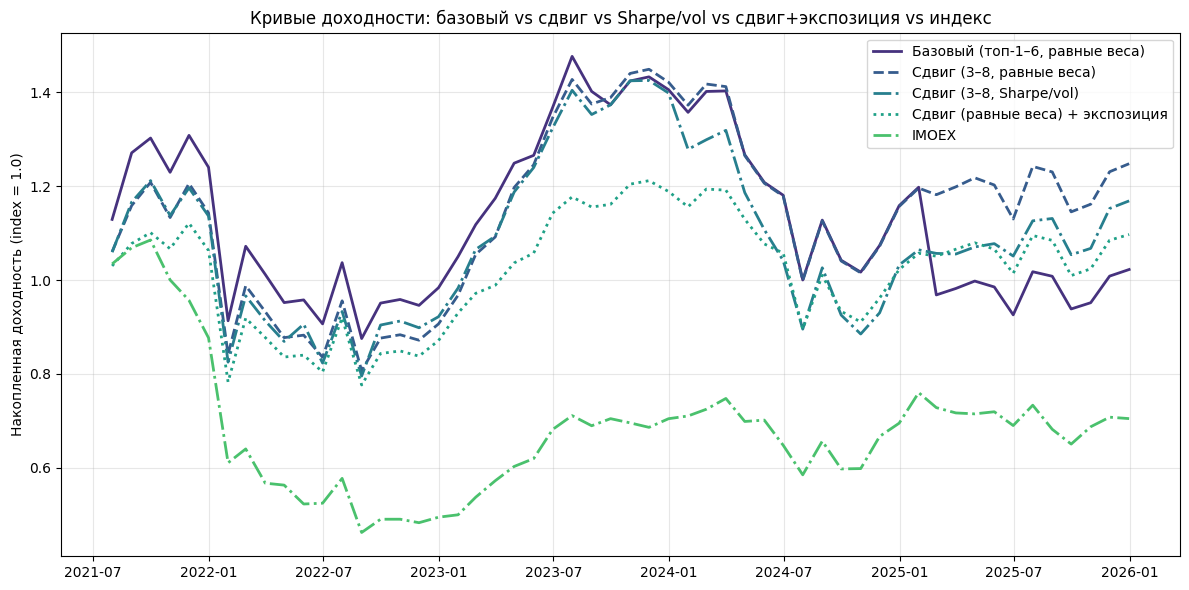

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === ПАРАМЕТРЫ БЭКТЕСТА ===
lookback_days = 126          # окно для Sharpe_6m (≈ 6 месяцев)
roll_window = 63             # окно для rolling Sharpe (≈ 3 месяца)
rebalance_freq = "M"         # ребалансировка по концу месяца
n_assets = 6                 # фиксированный размер портфеля
start_backtest = pd.Timestamp("2021-01-01")

# --- Подготовка данных ---
data = data.sort_index()
idx_prices = idx_prices.sort_index()

print("Данные акций:", data.index.min().date(), "→", data.index.max().date())
print("Данные индекса:", idx_prices.index.min().date(), "→", idx_prices.index.max().date())

returns = data.pct_change().dropna(how="all")
idx_returns = idx_prices.pct_change().dropna()

first_common_date = max(data.index.min(), idx_prices.index.min(), start_backtest)
data_bt = data.loc[data.index >= first_common_date].copy()
idx_bt = idx_prices.loc[idx_prices.index >= first_common_date].copy()
returns_bt = returns.loc[returns.index >= first_common_date].copy()
idx_returns_bt = idx_returns.loc[idx_returns.index >= first_common_date].copy()

print("Старт бэктеста:", first_common_date.date())

# Rolling Sharpe 3м по всем тикерам и индексу
roll_mean = returns_bt.rolling(roll_window).mean()
roll_std = returns_bt.rolling(roll_window).std()
roll_sharpe_all = (roll_mean / roll_std) * np.sqrt(252)

roll_mean_idx = idx_returns_bt.rolling(roll_window).mean()
roll_std_idx = idx_returns_bt.rolling(roll_window).std()
roll_sharpe_idx_all = (roll_mean_idx / roll_std_idx) * np.sqrt(252)

# Даты конца месяцев
month_ends = data_bt.resample(rebalance_freq).last().index
print("Количество месяцев для попытки бэктеста:", len(month_ends))


def run_backtest(mode_rule, use_sharpe_vol_weights=False):
    """
    mode_rule(end_date, roll_sharpe_now_port) -> bool is_q4_like
    is_q4_like = True: использовать диапазон 3–8 по Sharpe_6m вместо топ‑1–6.

    use_sharpe_vol_weights:
      False -> внутри месяца равные веса 6 бумаг;
      True  -> веса пропорциональны Sharpe_6m / vol_6m по каждой бумаге.
    """
    records = []
    port_daily_rets = []
    idx_daily_rets = []

    for i in range(len(month_ends) - 1):
        end_date = month_ends[i]
        next_end_date = month_ends[i + 1]

        # 1) Окно для Sharpe_6m
        window_mask = (data_bt.index <= end_date)
        window_data = data_bt.loc[window_mask]

        if len(window_data) < lookback_days + 5:
            continue

        window_data = window_data.tail(lookback_days + 1)
        window_idx = idx_bt.loc[window_data.index.min():window_data.index.max()]
        if len(window_idx) < lookback_days - 10:
            continue

        idx_rets_win = window_idx.pct_change().dropna()
        if len(idx_rets_win) < 20 or idx_rets_win.std() == 0:
            continue

        sharpe_idx_6m = idx_rets_win.mean() / idx_rets_win.std() * np.sqrt(252)
        idx_ret_6m = window_idx.iloc[-1] / window_idx.iloc[0] - 1

        # 2) Sharpe_6m, Ret_6m и vol_6m по тикерам
        sharpe_6m = {}
        ret_6m = {}
        vol_6m = {}
        for t in window_data.columns:
            series = window_data[t].dropna()
            if len(series) < 30:
                continue
            rets_t = series.pct_change().dropna()
            if len(rets_t) < 20 or rets_t.std() == 0:
                continue
            vol = rets_t.std() * np.sqrt(252)
            sharpe_t = rets_t.mean() / rets_t.std() * np.sqrt(252)
            sharpe_6m[t] = sharpe_t
            ret_6m[t] = series.iloc[-1] / series.iloc[0] - 1
            vol_6m[t] = vol

        if len(sharpe_6m) == 0:
            continue

        sharpe_6m = pd.Series(sharpe_6m)
        ret_6m = pd.Series(ret_6m)
        vol_6m = pd.Series(vol_6m)

        # 3) Фильтр качества: Sharpe_6m > 0 и Ret_6m > Ret_6m индекса
        cond_sharpe_pos = sharpe_6m > 0
        cond_ret_premium = ret_6m > idx_ret_6m
        filtered = sharpe_6m[cond_sharpe_pos & cond_ret_premium].sort_values(ascending=False)

        # Rolling Sharpe 3м портфеля для базовых 6 тикеров (по Sharpe_6m)
        base_candidates = filtered.copy()
        if len(base_candidates) < n_assets:
            others = sharpe_6m.drop(base_candidates.index, errors="ignore").sort_values(ascending=False)
            base_candidates = pd.concat([base_candidates, others.head(n_assets - len(base_candidates))])
        base_top_tickers = base_candidates.head(n_assets).index.tolist()

        if end_date in roll_sharpe_all.index:
            roll_sharpe_now_port = roll_sharpe_all.loc[end_date, base_top_tickers].mean()
        else:
            prev_dates = roll_sharpe_all.index[roll_sharpe_all.index < end_date]
            if len(prev_dates) == 0:
                roll_sharpe_now_port = np.nan
            else:
                roll_sharpe_now_port = roll_sharpe_all.loc[prev_dates[-1], base_top_tickers].mean()

        if end_date in roll_sharpe_idx_all.index:
            roll_sharpe_now_idx = roll_sharpe_idx_all.loc[end_date]
        else:
            prev_dates_idx = roll_sharpe_idx_all.index[roll_sharpe_idx_all.index < end_date]
            if len(prev_dates_idx) == 0:
                roll_sharpe_now_idx = np.nan
            else:
                roll_sharpe_now_idx = roll_sharpe_idx_all.loc[prev_dates_idx[-1]]

        # 4) Определяем режим (Q4 или нет)
        is_q4_like = mode_rule(end_date, roll_sharpe_now_port)

        # Окончательный выбор тикеров
        filtered_sorted = filtered.sort_values(ascending=False)

        if len(filtered_sorted) >= n_assets:
            if not is_q4_like:
                # обычный режим: топ‑1–6
                top_tickers = filtered_sorted.head(n_assets).index.tolist()
                selection_mode = "top1_6"
            else:
                # Q4 режим: смещённый диапазон по Sharpe_6m
                if len(filtered_sorted) >= 8:
                    top_tickers = filtered_sorted.iloc[2:8].index.tolist()  # 3–8
                    selection_mode = "3_8"
                elif len(filtered_sorted) == 7:
                    top_tickers = filtered_sorted.iloc[1:7].index.tolist()  # 2–7
                    selection_mode = "2_7"
                else:  # len == 6
                    top_tickers = filtered_sorted.iloc[0:6].index.tolist()  # 1–6 (fallback)
                    selection_mode = "1_6_fallback"
        else:
            # фильтр слишком жёсткий — дозаполняем по Sharpe_6m
            remaining_needed = n_assets - len(filtered_sorted)
            others = sharpe_6m.drop(filtered_sorted.index, errors="ignore").sort_values(ascending=False)
            extra = others.head(remaining_needed).index.tolist()
            top_tickers = list(filtered_sorted.index) + extra
            selection_mode = "filled"

        # 5) Период доходности
        period_mask = (data_bt.index > end_date) & (data_bt.index <= next_end_date)
        period_data = data_bt.loc[period_mask, top_tickers]
        period_idx = idx_bt.loc[(idx_bt.index > end_date) & (idx_bt.index <= next_end_date)]

        if len(period_data) < 2 or len(period_idx) < 2:
            continue

        period_rets = period_data.pct_change().dropna(how="all")
        period_idx_rets = period_idx.pct_change().dropna()

        common_idx2 = period_rets.index.intersection(period_idx_rets.index)
        period_rets = period_rets.loc[common_idx2]
        period_idx_rets = period_idx_rets.loc[common_idx2]

        if len(period_idx_rets) == 0:
            continue

        # Веса внутри месяца
        if not use_sharpe_vol_weights:
            # равновесовый портфель
            weights = pd.Series(1.0 / len(top_tickers), index=top_tickers)
        else:
            # веса пропорциональны Sharpe_6m / vol_6m
            sv = sharpe_6m[top_tickers] / vol_6m[top_tickers].replace(0, np.nan)
            sv = sv.clip(lower=0)  # на всякий случай
            if sv.sum() == 0 or sv.isna().all():
                weights = pd.Series(1.0 / len(top_tickers), index=top_tickers)
            else:
                weights = sv / sv.sum()

        # Портфельные дневные доходности с учётом весов
        port_rets = (period_rets[weights.index] * weights.values).sum(axis=1)

        if len(port_rets) == 0:
            continue

        port_month_ret = (1 + port_rets).prod() - 1
        idx_month_ret = (1 + period_idx_rets).prod() - 1

        if port_rets.std() > 0:
            sharpe_port_1m = port_rets.mean() / port_rets.std() * np.sqrt(252)
        else:
            sharpe_port_1m = np.nan

        port_daily_rets.append(port_rets)
        idx_daily_rets.append(period_idx_rets)

        records.append({
            "MonthEnd": end_date,
            "NextMonthEnd": next_end_date,
            "Tickers": ", ".join(top_tickers),
            "selection_mode": selection_mode,
            "Sharpe_6m_port_mean": sharpe_6m[top_tickers].mean(),
            "Sharpe_6m_idx": sharpe_idx_6m,
            "RollSharpe_3m_port_mean": roll_sharpe_now_port,
            "RollSharpe_3m_idx": roll_sharpe_now_idx,
            "Port_ret_1m": port_month_ret,
            "Idx_ret_1m": idx_month_ret,
            "Alpha_1m": port_month_ret - idx_month_ret,
            "Sharpe_1m_port": sharpe_port_1m,
            "is_q4_like": is_q4_like,
        })

    return pd.DataFrame(records), port_daily_rets, idx_daily_rets


# --- 1. Базовый прогон: всегда топ‑1–6, равные веса ---
bt_base, _, _ = run_backtest(
    lambda end_date, roll_s: False,
    use_sharpe_vol_weights=False
)

if len(bt_base) == 0:
    print("\n⚠️ Нет ни одного месяца даже в базовом прогоне.")
else:
    # Порог Q4 по rolling Sharpe портфеля (75‑й перцентиль)
    q4_threshold = bt_base["RollSharpe_3m_port_mean"].quantile(0.75)
    print(f"\nПорог Q4 по RollSharpe_3m_port_mean (75-й перцентиль): {q4_threshold:.3f}")

    def q4_rule(end_date, roll_s):
        if np.isnan(roll_s):
            return False
        return roll_s >= q4_threshold

    # --- 2. Прогон со сдвигом: 3–8 в Q4, равные веса ---
    bt_shift_eq, _, _ = run_backtest(q4_rule, use_sharpe_vol_weights=False)

    # --- 3. Прогон со сдвигом: 3–8 в Q4, веса Sharpe_6m/vol_6m ---
    bt_shift_sv, _, _ = run_backtest(q4_rule, use_sharpe_vol_weights=True)

    # Перевод доходностей в проценты
    for df in (bt_base, bt_shift_eq, bt_shift_sv):
        for col in ["Port_ret_1m", "Idx_ret_1m", "Alpha_1m"]:
            df[col] = df[col] * 100

    print("\n📅 Базовый бэктест (всегда топ‑1–6, равные веса):")
    print(
        bt_base[[
            "MonthEnd",
            "Tickers",
            "RollSharpe_3m_port_mean",
            "Port_ret_1m",
            "Idx_ret_1m",
            "Alpha_1m",
        ]].round(3)
    )

    print("\n📅 Бэктест со сдвигом (3–8 в Q4, равные веса):")
    print(
        bt_shift_eq[[
            "MonthEnd",
            "Tickers",
            "selection_mode",
            "RollSharpe_3m_port_mean",
            "Port_ret_1m",
            "Idx_ret_1m",
            "Alpha_1m",
        ]].round(3)
    )

    print("\n📅 Бэктест со сдвигом (3–8 в Q4, веса Sharpe_6m/vol_6m):")
    print(
        bt_shift_sv[[
            "MonthEnd",
            "Tickers",
            "selection_mode",
            "RollSharpe_3m_port_mean",
            "Port_ret_1m",
            "Idx_ret_1m",
            "Alpha_1m",
        ]].round(3)
    )

    # --- Аналитика по bt_shift_eq (как раньше) ---
    print("\n📊 Alpha_1m по режимам selection_mode (сдвиг, равные веса):")
    mode_stats = (
        bt_shift_eq.groupby("selection_mode")["Alpha_1m"]
        .agg(["count", "mean", "std"])
        .round(3)
    )
    print(mode_stats)

    bt_shift_eq["RollSharpe_3m_quartile"] = pd.qcut(
        bt_shift_eq["RollSharpe_3m_port_mean"],
        q=4,
        labels=["Q1_lowest", "Q2", "Q3", "Q4_highest"]
    )

    print("\n📊 Alpha_1m по квартилям RollSharpe_3m_port_mean (сдвиг, равные веса):")
    quartile_stats_shift = (
        bt_shift_eq.groupby("RollSharpe_3m_quartile")["Alpha_1m"]
        .agg(["count", "mean", "std"])
        .round(3)
    )
    print(quartile_stats_shift)

    # --- Функция max drawdown по месячным доходностям (в %) ---
    def max_drawdown_from_returns(ret_percent_series):
        curve = (1 + ret_percent_series / 100).cumprod()
        cummax = curve.cummax()
        dd = curve / cummax - 1
        return curve, dd.min()

    # Кривые для базового, сдвига (равные веса) и сдвига (Sharpe/vol)
    base_curve_m, base_dd = max_drawdown_from_returns(bt_base["Port_ret_1m"])
    shift_eq_curve_m, shift_eq_dd = max_drawdown_from_returns(bt_shift_eq["Port_ret_1m"])
    shift_sv_curve_m, shift_sv_dd = max_drawdown_from_returns(bt_shift_sv["Port_ret_1m"])
    idx_curve_m, idx_dd = max_drawdown_from_returns(bt_base["Idx_ret_1m"])

    # --- Динамическая экспозиция на основе квартилей (для равновесовой сдвинутой стратегии) ---
    exposure_map = {
        "Q1_lowest": 1.0,
        "Q2": 0.8,
        "Q3": 1.0,
        "Q4_highest": 0.5
    }

    bt_shift_eq["exposure"] = bt_shift_eq["RollSharpe_3m_quartile"].map(exposure_map).astype(float)
    bt_shift_eq["Port_ret_1m_dyn"] = bt_shift_eq["Port_ret_1m"] * bt_shift_eq["exposure"]

    dyn_curve_m, dyn_dd = max_drawdown_from_returns(bt_shift_eq["Port_ret_1m_dyn"])

    print(f"\nИтоговая доходность базового портфеля (1–6, равные веса): {(base_curve_m.iloc[-1]-1)*100:.2f}%")
    print(f"Итоговая доходность портфеля со сдвигом (3–8 в Q4, равные веса): {(shift_eq_curve_m.iloc[-1]-1)*100:.2f}%")
    print(f"Итоговая доходность портфеля со сдвигом (3–8 в Q4, Sharpe/vol веса): {(shift_sv_curve_m.iloc[-1]-1)*100:.2f}%")
    print(f"Итоговая доходность портфеля со сдвигом + динамическая экспозиция: {(dyn_curve_m.iloc[-1]-1)*100:.2f}%")
    print(f"Итоговая доходность индекса IMOEX: {(idx_curve_m.iloc[-1]-1)*100:.2f}%")

    print(f"\nМакс. просадка базового портфеля: {base_dd*100:.2f}%")
    print(f"Макс. просадка портфеля со сдвигом (равные веса): {shift_eq_dd*100:.2f}%")
    print(f"Макс. просадка портфеля со сдвигом (Sharpe/vol): {shift_sv_dd*100:.2f}%")
    print(f"Макс. просадка портфеля со сдвигом + динамическая экспозиция: {dyn_dd*100:.2f}%")
    print(f"Макс. просадка индекса IMOEX: {idx_dd*100:.2f}%")

    # График всех кривых
    plt.figure(figsize=(12, 6))
    plt.plot(bt_base["MonthEnd"], base_curve_m, label="Базовый (топ‑1–6, равные веса)", linewidth=2)
    plt.plot(bt_shift_eq["MonthEnd"], shift_eq_curve_m, label="Сдвиг (3–8, равные веса)", linewidth=2, linestyle="--")
    plt.plot(bt_shift_sv["MonthEnd"], shift_sv_curve_m, label="Сдвиг (3–8, Sharpe/vol)", linewidth=2, linestyle="-.")

    plt.plot(bt_shift_eq["MonthEnd"], dyn_curve_m, label="Сдвиг (равные веса) + экспозиция", linewidth=2, linestyle=":")
    plt.plot(bt_base["MonthEnd"], idx_curve_m, label="IMOEX", linewidth=2, linestyle="-.")
    plt.title("Кривые доходности: базовый vs сдвиг vs Sharpe/vol vs сдвиг+экспозиция vs индекс")
    plt.ylabel("Накопленная доходность (index = 1.0)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()











Данные акций: 2020-01-03 → 2026-01-06
Данные индекса: 2020-01-03 → 2026-01-06
Старт бэктеста: 2021-01-01
Количество месяцев для попытки бэктеста: 61

Порог Q4 по RollSharpe_3m_port_mean (75-й перцентиль): 3.510

Итоговая доходность базового портфеля: 2.27%
Итоговая доходность сдвига (3–8, равные веса): 24.82%
Итоговая доходность сдвига + динамическая экспозиция: 9.72%
Итоговая доходность индекса: -29.51%

Макс. просадка базового: -37.30%
Макс. просадка сдвига (равные): -33.24%
Макс. просадка сдвига + экспозиция: -30.76%
Макс. просадка индекса: -57.43%

📊 Future_ret_1m по квартилям Sharpe_port (t):
                 count   mean  median     std
Sharpe_quartile                              
Q1_lowest           14 -0.559   1.106  11.360
Q2                  13 -0.315  -0.951   7.392
Q3                  13  1.907   1.420   5.052
Q4_highest          13  1.536   3.522   6.184


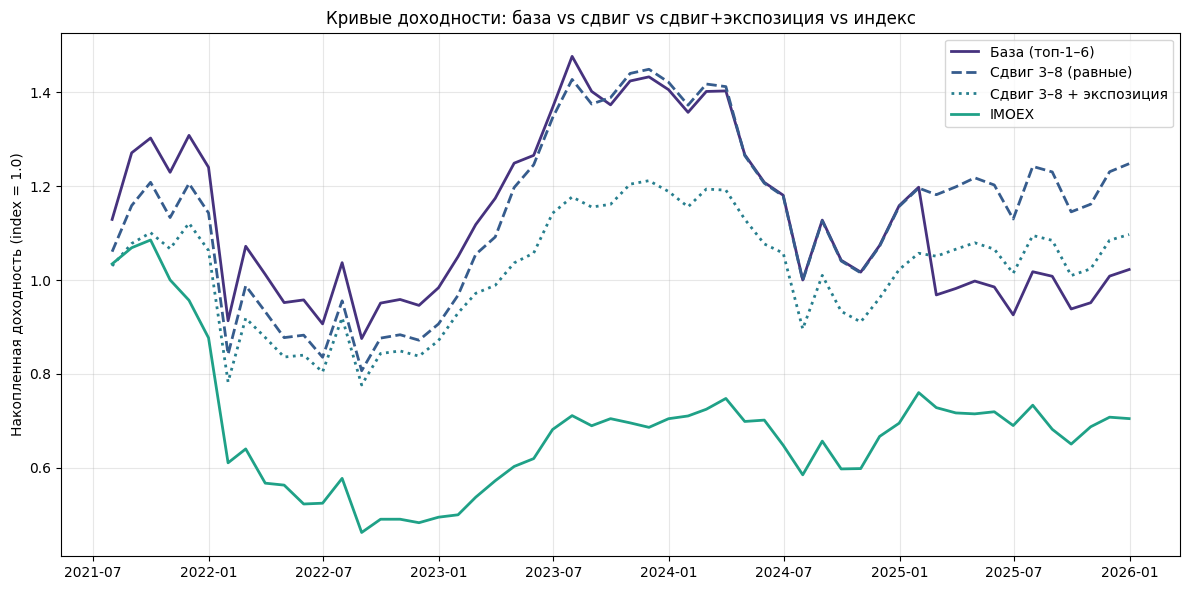


Последняя дата в данных: 2026-01-06

=== РЕКОМЕНДАЦИИ НА СЛЕДУЮЩИЙ МЕСЯЦ ===
Последняя дата в данных: 2026-01-06
Текущий RollSharpe_3m_port_mean: 1.974
Порог Q4: 3.510
Режим сейчас: не Q4 (используем топ‑1–10)
Режим выбора: top1_10
Sharpe‑режим: Q3, E_mean[портфельный R_next | режим] ≈ 1.91% (median ≈ 1.42%, σ ≈ 5.05 п.п.)

Топ‑10 тикеров на следующий месяц:
       Sharpe_6m  Ret_6m_%  Exp_ret_1m_ticker_%  Exp_ret_1m_port_mean_%  \
MDMG       3.263    49.485                6.984                   1.907   
MRKU       2.838    60.925                8.481                   1.907   
LENT       2.789    44.692                6.484                   1.907   
GMKN       2.313    46.544                6.905                   1.907   
PLZL       2.148    33.559                5.176                   1.907   
LSNGP      2.136    43.271                6.543                   1.907   
MRKP       1.973    42.301                6.550                   1.907   
OZON       1.505    13.559            

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === ПАРАМЕТРЫ ===
lookback_days = 126          # окно для Sharpe_6m (≈ 6 месяцев)
roll_window = 63             # окно для rolling Sharpe (≈ 3 месяца)
rebalance_freq = "M"         # ребаланс по концу месяца
n_assets = 6                 # размер портфеля в бэктесте
top_n_recommend = 10         # сколько тикеров показывать в рекомендациях
start_backtest = pd.Timestamp("2021-01-01")

# === ПОДГОТОВКА ДАННЫХ ===
data = data.sort_index()
idx_prices = idx_prices.sort_index()

print("Данные акций:", data.index.min().date(), "→", data.index.max().date())
print("Данные индекса:", idx_prices.index.min().date(), "→", idx_prices.index.max().date())

returns = data.pct_change().dropna(how="all")
idx_returns = idx_prices.pct_change().dropna()

first_common_date = max(data.index.min(), idx_prices.index.min(), start_backtest)
data_bt = data.loc[data.index >= first_common_date].copy()
idx_bt = idx_prices.loc[idx_prices.index >= first_common_date].copy()
returns_bt = returns.loc[returns.index >= first_common_date].copy()
idx_returns_bt = idx_returns.loc[idx_returns.index >= first_common_date].copy()

print("Старт бэктеста:", first_common_date.date())

# rolling Sharpe 3м по тикерам и индексу
roll_mean = returns_bt.rolling(roll_window).mean()
roll_std = returns_bt.rolling(roll_window).std()
roll_sharpe_all = (roll_mean / roll_std) * np.sqrt(252)

roll_mean_idx = idx_returns_bt.rolling(roll_window).mean()
roll_std_idx = idx_returns_bt.rolling(roll_window).std()
roll_sharpe_idx_all = (roll_mean_idx / roll_std_idx) * np.sqrt(252)

month_ends = data_bt.resample(rebalance_freq).last().index
print("Количество месяцев для попытки бэктеста:", len(month_ends))


# === ФУНКЦИЯ БЭКТЕСТА (БАЗА + СДВИГ 3–8) ===
def run_backtest(mode_rule, use_sharpe_vol_weights=False):
    """
    mode_rule(end_date, roll_sharpe_now_port) -> bool is_q4_like.
    is_q4_like = True → использовать диапазон 3–8 по Sharpe_6m вместо топ‑1–6.
    use_sharpe_vol_weights: False → равные веса; True → веса ~ Sharpe_6m/vol_6m.
    """
    records = []

    for i in range(len(month_ends) - 1):
        end_date = month_ends[i]
        next_end_date = month_ends[i + 1]

        # окно для Sharpe_6m
        window_mask = (data_bt.index <= end_date)
        window_data = data_bt.loc[window_mask]

        if len(window_data) < lookback_days + 5:
            continue

        window_data = window_data.tail(lookback_days + 1)
        window_idx = idx_bt.loc[window_data.index.min():window_data.index.max()]
        if len(window_idx) < lookback_days - 10:
            continue

        idx_rets_win = window_idx.pct_change().dropna()
        if len(idx_rets_win) < 20 or idx_rets_win.std() == 0:
            continue

        sharpe_idx_6m = idx_rets_win.mean() / idx_rets_win.std() * np.sqrt(252)
        idx_ret_6m = window_idx.iloc[-1] / window_idx.iloc[0] - 1

        # Sharpe_6m, Ret_6m, vol_6m по тикерам
        sharpe_6m = {}
        ret_6m = {}
        vol_6m = {}
        for t in window_data.columns:
            series = window_data[t].dropna()
            if len(series) < 30:
                continue
            r = series.pct_change().dropna()
            if len(r) < 20 or r.std() == 0:
                continue
            vol = r.std() * np.sqrt(252)
            sharpe_t = r.mean() / r.std() * np.sqrt(252)
            sharpe_6m[t] = sharpe_t
            ret_6m[t] = series.iloc[-1] / series.iloc[0] - 1
            vol_6m[t] = vol

        if len(sharpe_6m) == 0:
            continue

        sharpe_6m = pd.Series(sharpe_6m)
        ret_6m = pd.Series(ret_6m)
        vol_6m = pd.Series(vol_6m)

        # фильтр качества
        cond_sharpe_pos = sharpe_6m > 0
        cond_ret_premium = ret_6m > idx_ret_6m
        filtered = sharpe_6m[cond_sharpe_pos & cond_ret_premium].sort_values(ascending=False)

        # rolling Sharpe 3м портфеля для базовых 6 (по Sharpe_6m)
        base_candidates = filtered.copy()
        if len(base_candidates) < n_assets:
            others = sharpe_6m.drop(base_candidates.index, errors="ignore").sort_values(ascending=False)
            base_candidates = pd.concat([base_candidates, others.head(n_assets - len(base_candidates))])
        base_top = base_candidates.head(n_assets).index.tolist()

        if end_date in roll_sharpe_all.index:
            roll_sharpe_now_port = roll_sharpe_all.loc[end_date, base_top].mean()
        else:
            prev_dates = roll_sharpe_all.index[roll_sharpe_all.index < end_date]
            roll_sharpe_now_port = roll_sharpe_all.loc[prev_dates[-1], base_top].mean() if len(prev_dates) else np.nan

        if end_date in roll_sharpe_idx_all.index:
            roll_sharpe_now_idx = roll_sharpe_idx_all.loc[end_date]
        else:
            prev_dates_idx = roll_sharpe_idx_all.index[roll_sharpe_idx_all.index < end_date]
            roll_sharpe_now_idx = roll_sharpe_idx_all.loc[prev_dates_idx[-1]] if len(prev_dates_idx) else np.nan

        is_q4_like = mode_rule(end_date, roll_sharpe_now_port)
        filtered_sorted = filtered.sort_values(ascending=False)

        # выбор тикеров (1–6 или 3–8)
        if len(filtered_sorted) >= n_assets:
            if not is_q4_like:
                top_tickers = filtered_sorted.head(n_assets).index.tolist()
                selection_mode = "top1_6"
            else:
                if len(filtered_sorted) >= 8:
                    top_tickers = filtered_sorted.iloc[2:8].index.tolist()  # 3–8
                    selection_mode = "3_8"
                elif len(filtered_sorted) == 7:
                    top_tickers = filtered_sorted.iloc[1:7].index.tolist()  # 2–7
                    selection_mode = "2_7"
                else:
                    top_tickers = filtered_sorted.iloc[0:6].index.tolist()  # 1–6 fallback
                    selection_mode = "1_6_fallback"
        else:
            remaining_needed = n_assets - len(filtered_sorted)
            others = sharpe_6m.drop(filtered_sorted.index, errors="ignore").sort_values(ascending=False)
            extra = others.head(remaining_needed).index.tolist()
            top_tickers = list(filtered_sorted.index) + extra
            selection_mode = "filled"

        # период доходности
        period_mask = (data_bt.index > end_date) & (data_bt.index <= next_end_date)
        period_data = data_bt.loc[period_mask, top_tickers]
        period_idx = idx_bt.loc[(idx_bt.index > end_date) & (idx_bt.index <= next_end_date)]

        if len(period_data) < 2 or len(period_idx) < 2:
            continue

        period_rets = period_data.pct_change().dropna(how="all")
        period_idx_rets = period_idx.pct_change().dropna()

        common_idx2 = period_rets.index.intersection(period_idx_rets.index)
        period_rets = period_rets.loc[common_idx2]
        period_idx_rets = period_idx_rets.loc[common_idx2]

        if len(period_idx_rets) == 0 or len(period_rets) == 0:
            continue

        # веса
        if not use_sharpe_vol_weights:
            weights = pd.Series(1.0 / len(top_tickers), index=top_tickers)
        else:
            sv = sharpe_6m[top_tickers] / vol_6m[top_tickers].replace(0, np.nan)
            sv = sv.clip(lower=0)
            if sv.sum() == 0 or sv.isna().all():
                weights = pd.Series(1.0 / len(top_tickers), index=top_tickers)
            else:
                weights = sv / sv.sum()

        port_rets = (period_rets[weights.index] * weights.values).sum(axis=1)
        port_month_ret = (1 + port_rets).prod() - 1
        idx_month_ret = (1 + period_idx_rets).prod() - 1

        if port_rets.std() > 0:
            sharpe_port_1m = port_rets.mean() / port_rets.std() * np.sqrt(252)
        else:
            sharpe_port_1m = np.nan

        records.append({
            "MonthEnd": end_date,
            "NextMonthEnd": next_end_date,
            "Tickers": ", ".join(top_tickers),
            "selection_mode": selection_mode,
            "Sharpe_6m_port_mean": sharpe_6m[top_tickers].mean(),
            "Sharpe_6m_idx": sharpe_idx_6m,
            "RollSharpe_3m_port_mean": roll_sharpe_now_port,
            "RollSharpe_3m_idx": roll_sharpe_now_idx,
            "Port_ret_1m": port_month_ret * 100,
            "Idx_ret_1m": idx_month_ret * 100,
            "Alpha_1m": (port_month_ret - idx_month_ret) * 100,
            "Sharpe_1m_port": sharpe_port_1m,
        })

    return pd.DataFrame(records)


# === БЭКТЕСТ: БАЗА, СДВИГ, ЭКСПОЗИЦИЯ ===
bt_base = run_backtest(lambda d, s: False, use_sharpe_vol_weights=False)

if len(bt_base) == 0:
    print("\n⚠️ Нет ни одного месяца даже в базовом прогоне.")
else:
    q4_threshold = bt_base["RollSharpe_3m_port_mean"].quantile(0.75)
    print(f"\nПорог Q4 по RollSharpe_3m_port_mean (75-й перцентиль): {q4_threshold:.3f}")

    def q4_rule(end_date, roll_s):
        if np.isnan(roll_s):
            return False
        return roll_s >= q4_threshold

    bt_shift_eq = run_backtest(q4_rule, use_sharpe_vol_weights=False)

    # квартильные режимы для сдвига
    bt_shift_eq["RollSharpe_3m_quartile"] = pd.qcut(
        bt_shift_eq["RollSharpe_3m_port_mean"],
        q=4,
        labels=["Q1_lowest", "Q2", "Q3", "Q4_highest"]
    )

    # динамическая экспозиция
    exposure_map = {
        "Q1_lowest": 1.0,
        "Q2": 0.8,
        "Q3": 1.0,
        "Q4_highest": 0.5
    }
    bt_shift_eq["exposure"] = bt_shift_eq["RollSharpe_3m_quartile"].map(exposure_map).astype(float)
    bt_shift_eq["Port_ret_1m_dyn"] = bt_shift_eq["Port_ret_1m"] * bt_shift_eq["exposure"]

    # max drawdown
    def max_drawdown_from_returns(ret_percent_series):
        curve = (1 + ret_percent_series / 100).cumprod()
        cummax = curve.cummax()
        dd = curve / cummax - 1
        return curve, dd.min()

    base_curve_m, base_dd = max_drawdown_from_returns(bt_base["Port_ret_1m"])
    shift_eq_curve_m, shift_eq_dd = max_drawdown_from_returns(bt_shift_eq["Port_ret_1m"])
    dyn_curve_m, dyn_dd = max_drawdown_from_returns(bt_shift_eq["Port_ret_1m_dyn"])
    idx_curve_m, idx_dd = max_drawdown_from_returns(bt_base["Idx_ret_1m"])

    print(f"\nИтоговая доходность базового портфеля: {(base_curve_m.iloc[-1]-1)*100:.2f}%")
    print(f"Итоговая доходность сдвига (3–8, равные веса): {(shift_eq_curve_m.iloc[-1]-1)*100:.2f}%")
    print(f"Итоговая доходность сдвига + динамическая экспозиция: {(dyn_curve_m.iloc[-1]-1)*100:.2f}%")
    print(f"Итоговая доходность индекса: {(idx_curve_m.iloc[-1]-1)*100:.2f}%")

    print(f"\nМакс. просадка базового: {base_dd*100:.2f}%")
    print(f"Макс. просадка сдвига (равные): {shift_eq_dd*100:.2f}%")
    print(f"Макс. просадка сдвига + экспозиция: {dyn_dd*100:.2f}%")
    print(f"Макс. просадка индекса: {idx_dd*100:.2f}%")

    # === ИСТОРИЯ «Sharpe_t → Future_ret_{t+1}» (mean + median) ===
    hist = bt_shift_eq[["MonthEnd", "RollSharpe_3m_port_mean", "Port_ret_1m"]].copy()
    hist["Future_ret_1m"] = hist["Port_ret_1m"].shift(-1)
    hist = hist.dropna(subset=["Future_ret_1m"])

    hist["Sharpe_quartile"] = pd.qcut(
        hist["RollSharpe_3m_port_mean"],
        q=4,
        labels=["Q1_lowest", "Q2", "Q3", "Q4_highest"]
    )

    regime_stats = (
        hist.groupby("Sharpe_quartile")["Future_ret_1m"]
        .agg(["count", "mean", "median", "std"])
        .round(3)
    )

    print("\n📊 Future_ret_1m по квартилям Sharpe_port (t):")
    print(regime_stats)

    # график стратегий
    plt.figure(figsize=(12, 6))
    plt.plot(bt_base["MonthEnd"], base_curve_m, label="База (топ‑1–6)", linewidth=2)
    plt.plot(bt_shift_eq["MonthEnd"], shift_eq_curve_m, label="Сдвиг 3–8 (равные)", linewidth=2, linestyle="--")
    plt.plot(bt_shift_eq["MonthEnd"], dyn_curve_m, label="Сдвиг 3–8 + экспозиция", linewidth=2, linestyle=":")
    plt.plot(bt_base["MonthEnd"], idx_curve_m, label="IMOEX", linewidth=2)
    plt.title("Кривые доходности: база vs сдвиг vs сдвиг+экспозиция vs индекс")
    plt.ylabel("Накопленная доходность (index = 1.0)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === РЕКОМЕНДАЦИИ НА СЛЕДУЮЩИЙ МЕСЯЦ: ТОП‑10 С ТРЕМЯ EXPECTED RETURN ===

    last_date = data_bt.index.max()
    print(f"\nПоследняя дата в данных: {last_date.date()}")

    window_data = data_bt.loc[data_bt.index <= last_date].tail(lookback_days + 1)
    window_idx = idx_bt.loc[window_data.index.min():window_data.index.max()]

    idx_rets_win = window_idx.pct_change().dropna()
    idx_ret_6m_last = window_idx.iloc[-1] / window_idx.iloc[0] - 1

    sharpe_6m_last = {}
    ret_6m_last = {}
    for t in window_data.columns:
        s = window_data[t].dropna()
        if len(s) < 30:
            continue
        r = s.pct_change().dropna()
        if len(r) < 20 or r.std() == 0:
            continue
        sharpe_6m_last[t] = r.mean() / r.std() * np.sqrt(252)
        ret_6m_last[t] = s.iloc[-1] / s.iloc[0] - 1

    sharpe_6m_last = pd.Series(sharpe_6m_last)
    ret_6m_last = pd.Series(ret_6m_last)

    cond_sharpe_pos = sharpe_6m_last > 0
    cond_ret_premium = ret_6m_last > idx_ret_6m_last
    filtered_last = sharpe_6m_last[cond_sharpe_pos & cond_ret_premium].sort_values(ascending=False)

    # rolling Sharpe портфеля на последнюю дату по топ‑6 Sharpe_6m
    base_candidates_last = filtered_last.copy()
    if len(base_candidates_last) < n_assets:
        others_last = sharpe_6m_last.drop(base_candidates_last.index, errors="ignore").sort_values(ascending=False)
        base_candidates_last = pd.concat([base_candidates_last, others_last.head(n_assets - len(base_candidates_last))])
    base_top_last = base_candidates_last.head(n_assets).index.tolist()

    if last_date in roll_sharpe_all.index:
        roll_sharpe_last_port = roll_sharpe_all.loc[last_date, base_top_last].mean()
    else:
        prev_dates = roll_sharpe_all.index[roll_sharpe_all.index < last_date]
        roll_sharpe_last_port = roll_sharpe_all.loc[prev_dates[-1], base_top_last].mean() if len(prev_dates) else np.nan

    is_q4_now = (not np.isnan(roll_sharpe_last_port)) and (roll_sharpe_last_port >= q4_threshold)

    filtered_sorted_last = filtered_last.sort_values(ascending=False)

    # логика выдачи топ‑10: 1–10 или 3–12
    if len(filtered_sorted_last) >= top_n_recommend:
        if not is_q4_now:
            next_tickers = filtered_sorted_last.head(top_n_recommend).index.tolist()
            sel_mode_next = "top1_10"
        else:
            if len(filtered_sorted_last) >= top_n_recommend + 2:
                next_tickers = filtered_sorted_last.iloc[2:2 + top_n_recommend].index.tolist()
                sel_mode_next = "3_12"
            else:
                start = max(0, len(filtered_sorted_last) - top_n_recommend)
                next_tickers = filtered_sorted_last.iloc[start:].index.tolist()
                sel_mode_next = "shifted_tail"
    else:
        remaining_needed = top_n_recommend - len(filtered_sorted_last)
        others_last = sharpe_6m_last.drop(filtered_sorted_last.index, errors="ignore").sort_values(ascending=False)
        extra_last = others_last.head(remaining_needed).index.tolist()
        next_tickers = list(filtered_sorted_last.index) + extra_last
        sel_mode_next = "filled_to_10"

    # 1) Тикерный expected return (история по самому тикеру)
    recent_days = 126
    per_ticker_exp_ret = {}
    for t in next_tickers:
        r_full = returns_bt[t].dropna()
        if len(r_full) < recent_days:
            per_ticker_exp_ret[t] = np.nan
            continue
        last_r = r_full.tail(recent_days)
        mu_d = last_r.mean()
        per_ticker_exp_ret[t] = mu_d * 21 * 100  # дневной μ × 21

    # 2) Режимный expected return портфеля (Sharpe режим) — mean и median
    qs = hist["RollSharpe_3m_port_mean"].quantile([0.25, 0.5, 0.75])
    if roll_sharpe_last_port <= qs.loc[0.25]:
        current_regime = "Q1_lowest"
    elif roll_sharpe_last_port <= qs.loc[0.5]:
        current_regime = "Q2"
    elif roll_sharpe_last_port <= qs.loc[0.75]:
        current_regime = "Q3"
    else:
        current_regime = "Q4_highest"

    hist_reg = hist.loc[hist["Sharpe_quartile"] == current_regime, "Future_ret_1m"]
    exp_port_SR_mean = hist_reg.mean()
    exp_port_SR_median = hist_reg.median()
    std_port_SR = hist_reg.std()

    print("\n=== РЕКОМЕНДАЦИИ НА СЛЕДУЮЩИЙ МЕСЯЦ ===")
    print(f"Последняя дата в данных: {last_date.date()}")
    print(f"Текущий RollSharpe_3m_port_mean: {roll_sharpe_last_port:.3f}")
    print(f"Порог Q4: {q4_threshold:.3f}")
    print(
        f"Режим сейчас: "
        f"{'Q4 (используем сдвиг 3–12)' if is_q4_now else 'не Q4 (используем топ‑1–10)'}"
    )
    print(f"Режим выбора: {sel_mode_next}")
    print(
        f"Sharpe‑режим: {current_regime}, "
        f"E_mean[портфельный R_next | режим] ≈ {exp_port_SR_mean:.2f}% "
        f"(median ≈ {exp_port_SR_median:.2f}%, σ ≈ {std_port_SR:.2f} п.п.)"
    )

    rec_df = pd.DataFrame({
        "Sharpe_6m": sharpe_6m_last[next_tickers],
        "Ret_6m_%": ret_6m_last[next_tickers] * 100,
        "Exp_ret_1m_ticker_%": pd.Series(per_ticker_exp_ret),
        "Exp_ret_1m_port_mean_%": exp_port_SR_mean,
        "Exp_ret_1m_port_median_%": exp_port_SR_median,
    }).round(3)

    print("\nТоп‑10 тикеров на следующий месяц:")
    print(rec_df)

        # === РЕКОМЕНДАЦИЯ ПОРТФЕЛЯ ПО Sharpe_1m ===

    # 1) Считаем Sharpe_1m по каждому тикеру на последнем месяце
    last_month_days = 21
    sharpe_1m_last = {}
    for t in data_bt.columns:
        series = data_bt[t].dropna()
        if len(series) < last_month_days + 2:
            continue
        window_prices = series.tail(last_month_days + 1)
        r = window_prices.pct_change().dropna()
        if len(r) < 10 or r.std() == 0:
            continue
        sharpe_1m_last[t] = r.mean() / r.std() * np.sqrt(252)

    sharpe_1m_last = pd.Series(sharpe_1m_last)

    if len(sharpe_1m_last) > 0:
        # 2) Топ‑10 по Sharpe_1m
        sharpe_1m_sorted = sharpe_1m_last.sort_values(ascending=False)
        top_10_sharpe_1m = sharpe_1m_sorted.head(top_n_recommend).index.tolist()

        # 3) Доходность этих тикеров за последний месяц (в %)
        #    используем те же данные returns_bt (дневные ретёрны)
        ret_1m_last = {}
        for t in top_10_sharpe_1m:
            r_full = returns_bt[t].dropna()
            if len(r_full) < last_month_days:
                ret_1m_last[t] = np.nan
                continue
            last_r = r_full.tail(last_month_days)
            ret_1m_last[t] = (1 + last_r).prod() - 1

        sharpe_1m_portfolio_df = pd.DataFrame({
            "Sharpe_1m": sharpe_1m_last[top_10_sharpe_1m],
            "Ret_last_1m_%": pd.Series(ret_1m_last) * 100,
        }).round(3)

        print("\n=== РЕКОМЕНДУЕМЫЙ ПОРТФЕЛЬ ПО Sharpe_1m (последний месяц) ===")
        print("Топ‑10 тикеров по Sharpe_1m и их доходность за последний месяц:")
        print(sharpe_1m_portfolio_df)
    else:
        print("\n⚠️ Недостаточно данных для расчёта Sharpe_1m по тикерам.")


    print("\nПояснение столбцов:")
    print("  Exp_ret_1m_ticker_%        — оценка по самому тикеру (средний дневной рет × 21 за последние ~6м).")
    print("  Exp_ret_1m_port_mean_%      — агрессивный режимный прогноз (среднее Future_ret_1m по этому Sharpe‑режиму).")
    print("  Exp_ret_1m_port_median_%    — консервативный режимный прогноз (медиана Future_ret_1m по режиму).")






Риск-метрики по top-10 тикерам (дневные, за ~1 год):
       mu_daily_%  sigma_daily_%    skew  kurt_excess  VaR95_%  VaR99_%  \
MDMG        0.215          1.489   0.035        2.445   -2.402   -3.294   
MRKU        0.127          2.316  -0.322        4.592   -3.475   -5.458   
LENT        0.234          1.740   0.450        1.434   -2.782   -3.807   
GMKN        0.151          2.360   0.580        0.812   -3.137   -4.704   
PLZL       -0.128          5.983 -13.682      206.402   -3.001   -5.846   
LSNGP       0.167          1.933   1.139       25.312   -2.221   -5.502   
MRKP        0.240          2.195  -0.631        8.868   -2.671   -7.013   
OZON        0.161          1.963   0.343        2.214   -2.915   -5.587   
OKEY        0.064          2.325   1.699        7.644   -3.233   -5.121   
SVET        0.034          4.048   1.327       10.965   -4.282   -8.929   

       ES95_%  ES99_%  
MDMG   -3.078  -4.176  
MRKU   -5.195  -8.802  
LENT   -3.320  -3.992  
GMKN   -4.041  -5.177  


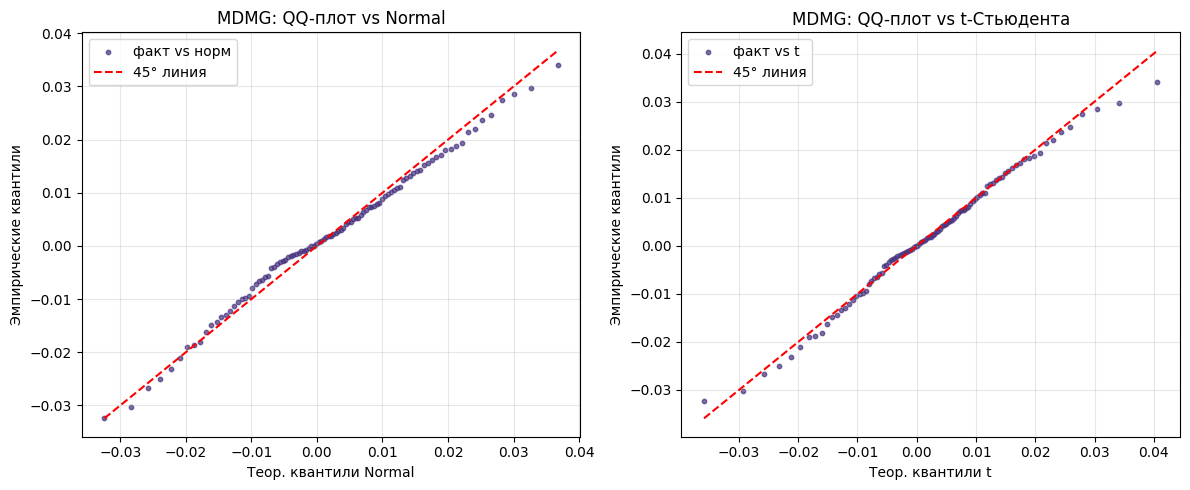

In [21]:
import scipy.stats as st

# === РИСК-МЕТРИКИ И QQ-ДАННЫЕ ДЛЯ TOP-10 ТИКЕРОВ ===

risk_stats = {}

# параметр: сколько дней истории брать для распределения
risk_lookback_days = 252  # ~1 год, можно 504 (~2 года)

for t in next_tickers:
    r_full = returns_bt[t].dropna()
    if len(r_full) < risk_lookback_days // 2:
        continue
    r = r_full.tail(risk_lookback_days)

    r_sorted = np.sort(r.values)
    n = len(r_sorted)

    # эмпирические VaR и ES (левый хвост, 5% и 1%)
    alpha_95 = 0.95
    alpha_99 = 0.99
    idx_95 = int(np.floor((1 - alpha_95) * n))
    idx_99 = int(np.floor((1 - alpha_99) * n))

    var95 = r_sorted[idx_95]          # VaR 95% (например, -0.03 = -3%)
    var99 = r_sorted[idx_99]          # VaR 99%
    es95 = r_sorted[:idx_95 + 1].mean() if idx_95 > 0 else var95
    es99 = r_sorted[:idx_99 + 1].mean() if idx_99 > 0 else var99

    # моментные характеристики
    mu = r.mean()
    sigma = r.std(ddof=1)
    skew = st.skew(r, bias=False)
    kurt_excess = st.kurtosis(r, fisher=True, bias=False)  # excess kurtosis

    # подгонка нормального и t-распределения
    # Normal: N(mu_norm, sigma_norm)
    mu_norm, sigma_norm = st.norm.fit(r)

    # Student t: df_t, loc_t, scale_t
    df_t, loc_t, scale_t = st.t.fit(r)

    # данные для QQ-плотов (можно потом использовать для графиков)
    # квантильные уровни
    probs = np.linspace(0.01, 0.99, 99)
    r_q = np.quantile(r, probs)
    norm_q = st.norm.ppf(probs, loc=mu_norm, scale=sigma_norm)
    t_q = st.t.ppf(probs, df_t, loc=loc_t, scale=scale_t)

    risk_stats[t] = {
        "mu": mu,
        "sigma": sigma,
        "skew": skew,
        "kurt_excess": kurt_excess,
        "VaR95": var95,
        "VaR99": var99,
        "ES95": es95,
        "ES99": es99,
        "mu_norm": mu_norm,
        "sigma_norm": sigma_norm,
        "df_t": df_t,
        "loc_t": loc_t,
        "scale_t": scale_t,
        "probs": probs,
        "r_q": r_q,
        "norm_q": norm_q,
        "t_q": t_q,
    }

# Вывод сводной таблицы по основным риск-метрикам
risk_df = pd.DataFrame(
    {
        t: {
            "mu_daily_%": v["mu"] * 100,
            "sigma_daily_%": v["sigma"] * 100,
            "skew": v["skew"],
            "kurt_excess": v["kurt_excess"],
            "VaR95_%": v["VaR95"] * 100,
            "VaR99_%": v["VaR99"] * 100,
            "ES95_%": v["ES95"] * 100,
            "ES99_%": v["ES99"] * 100,
        }
        for t, v in risk_stats.items()
    }
).T.round(3)

print("\nРиск-метрики по top-10 тикерам (дневные, за ~1 год):")
print(risk_df)


print("\nРиск-метрики по top-10 тикерам (дневные, за ~1 год):")
print(risk_df)
print("\nДля QQ-плотов по конкретному тикеру смотри risk_stats['TICKER']['r_q', 'norm_q', 't_q'].")

# Пример построения QQ-плота: фактическое vs нормальное и vs t-Стьюдента
ticker_for_qq = next_tickers[0]  # выбери нужный тикер
qq = risk_stats[ticker_for_qq]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(qq["norm_q"], qq["r_q"], s=10, alpha=0.7, label="факт vs норм")
plt.plot(qq["norm_q"], qq["norm_q"], "r--", label="45° линия")
plt.title(f"{ticker_for_qq}: QQ-плот vs Normal")
plt.xlabel("Теор. квантили Normal")
plt.ylabel("Эмпирические квантили")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(qq["t_q"], qq["r_q"], s=10, alpha=0.7, label="факт vs t")
plt.plot(qq["t_q"], qq["t_q"], "r--", label="45° линия")
plt.title(f"{ticker_for_qq}: QQ-плот vs t-Стьюдента")
plt.xlabel("Теор. квантили t")
plt.ylabel("Эмпирические квантили")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


=== Лекция 2: Тяжёлые хвосты нефтяных акций (MOEX) ===
SBER: ν=2.25 (степени свободы)
GAZP: ν=2.40 (степени свободы)
LKOH: ν=2.62 (степени свободы)
GMKN: ν=3.01 (степени свободы)
NVTK: ν=3.16 (степени свободы)
ROSN: ν=2.95 (степени свободы)
TATN: ν=2.69 (степени свободы)
MDMG: ν=2.58 (степени свободы)
MTSS: ν=2.23 (степени свободы)
MGNT: ν=3.00 (степени свободы)
CHMF: ν=3.61 (степени свободы)
PLZL: ν=3.25 (степени свободы)
YDEX: ν=7.57 (степени свободы)
MOEX: ν=3.23 (степени свободы)
TRNFP: ν=2.16 (степени свободы)
MRKP: ν=2.26 (степени свободы)
LSNGP: ν=2.10 (степени свободы)
SNGSP: ν=2.49 (степени свободы)
HEAD: ν=3.46 (степени свободы)
RASP: ν=2.55 (степени свободы)
SFIN: ν=1.73 (степени свободы)
SMLT: ν=1.95 (степени свободы)
DIAS: ν=3.10 (степени свободы)
SVCB: ν=4.79 (степени свободы)
FEES: ν=2.64 (степени свободы)
FLOT: ν=2.31 (степени свободы)
BELU: ν=1.82 (степени свободы)
SPBE: ν=1.92 (степени свободы)
IVAT: ν=2.17 (степени свободы)
KAZTP: ν=2.21 (степени свободы)
RENI: ν=2.7

IndexError: index 6 is out of bounds for axis 0 with size 6

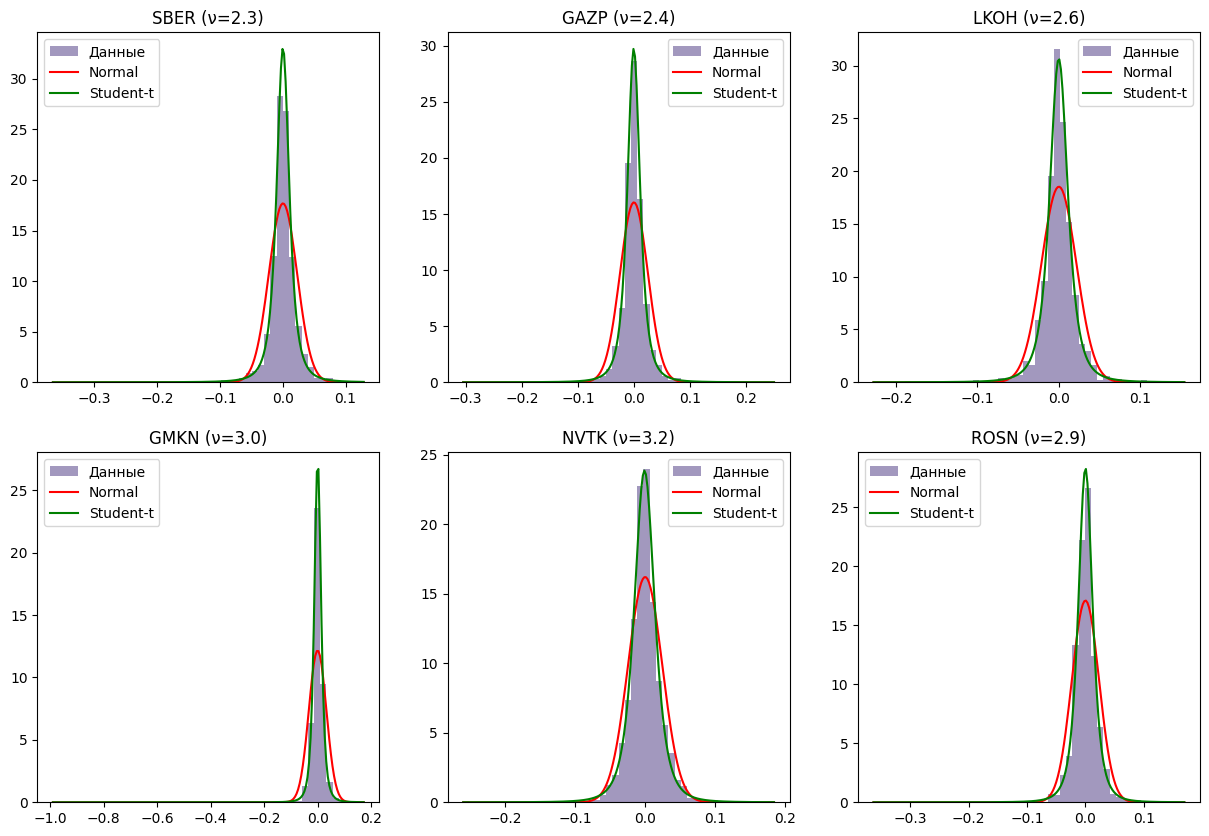

In [22]:
from scipy.stats import t, pareto
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Продолжение с returns из MOEX
extreme_returns = returns[returns.abs() > returns.std() * 2]  # экстремальные движения
print("=== Лекция 2: Тяжёлые хвосты нефтяных акций (MOEX) ===")

# Фит Student-t для каждой акции
t_fits = {}
for ticker in tickers:
    series = returns[ticker].dropna()
    params = t.fit(series)        # loc, scale, df
    t_fits[ticker] = params
    # params: (df, loc, scale) в scipy t.fit [web:62]
    df_param = params[0]
    print(f"{ticker}: ν={df_param:.2f} (степени свободы)")

# Pareto для правого хвоста (потери > 95%)
pareto_fits = {}
for ticker in tickers:
    series = returns[ticker].dropna()
    tail = -series[series < series.quantile(0.05)].dropna()
    if len(tail) > 10:
        alpha, xmin, _ = pareto.fit(tail, floc=0)
        pareto_fits[ticker] = alpha
        print(f"{ticker}: α={alpha:.2f} (Pareto хвост)")

# Сравнение плотностей
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, ticker in enumerate(tickers):
    data_series = returns[ticker].dropna()
    x = np.linspace(data_series.min(), data_series.max(), 200)

    # Эмпирическая + Normal + t
    axes[i].hist(data_series, bins=50, density=True, alpha=0.5, label='Данные')
    axes[i].plot(x, stats.norm.pdf(x, data_series.mean(), data_series.std()),
                 'r-', label='Normal')
    if ticker in t_fits:
        axes[i].plot(x, t.pdf(x, *t_fits[ticker]), 'g-', label='Student-t')
    df_param = t_fits[ticker][0]
    axes[i].set_title(f'{ticker} (ν={df_param:.1f})')
    axes[i].legend()
plt.tight_layout()
plt.show()

print("ν<10: дисперсия конечна, но тяжёлые хвосты. α<2: бесконечная дисперсия. [web:62]")

In [23]:
# === metrics_core.py (или просто ячейка с функциями) ===
import numpy as np
import pandas as pd

top_6_all = base_all_sorted.head(6)   # долгосрочные топ-6

trading_days = 252
risk_free = 0.0

def sharpe_ratio(r):
    if len(r) == 0 or r.std() == 0:
        return np.nan
    mean_excess = r.mean() - risk_free / trading_days
    return np.sqrt(trading_days) * mean_excess / r.std()

def sortino_ratio(r):
    if len(r) == 0:
        return np.nan
    d = r[r < 0]
    if d.std() == 0:
        return np.nan
    mean_excess = r.mean() - risk_free / trading_days
    return np.sqrt(trading_days) * mean_excess / d.std()

def omega_ratio(r, threshold=0.0):
    if len(r) == 0:
        return np.nan
    gains = r[r > threshold] - threshold
    losses = threshold - r[r < threshold]
    if losses.sum() == 0:
        return np.nan
    return gains.sum() / losses.sum()

def max_drawdown(cum):
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

def calmar_ratio(r):
    if len(r) == 0:
        return np.nan
    cum = (1 + r).cumprod()
    mdd = max_drawdown(cum)
    if mdd == 0 or np.isnan(mdd):
        return np.nan
    ann_ret = (1 + r).prod() ** (trading_days / len(r)) - 1
    return ann_ret / abs(mdd)

def martin_ratio(r):
    if len(r) == 0:
        return np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd_pct = 100 * (cum - peak) / peak
    ulcer = np.sqrt((dd_pct ** 2).mean())
    if ulcer == 0:
        return np.nan
    ann_ret = (1 + r).prod() ** (trading_days / len(r)) - 1
    return ann_ret / ulcer

def compute_ratios_block(rets, windows):
    """
    rets: DataFrame с дневной доходностью по колонкам (тикеры)
    windows: dict {'All': None, '1Y':252, ...}
    возвращает: results_port[window] = DataFrame с 5 метриками
    """
    results = {}
    for name, w in windows.items():
        r_win = rets if w is None else rets.iloc[-w:]
        ratios = { "Sharpe": [], "Sortino": [], "Omega": [], "Calmar": [], "Martin": [] }
        for t in r_win.columns:
            r = r_win[t].dropna()
            ratios["Sharpe"].append(sharpe_ratio(r))
            ratios["Sortino"].append(sortino_ratio(r))
            ratios["Omega"].append(omega_ratio(r))
            ratios["Calmar"].append(calmar_ratio(r))
            ratios["Martin"].append(martin_ratio(r))
        results[name] = pd.DataFrame(ratios, index=r_win.columns)
    return results


# =========================================
# MONITORING FUNCTION
# =========================================

top_6_all = base_all_sorted.head(10)   # долгосрочные топ-6

def build_monitor_for_set(tickers, results_port):
    # ранги по Sharpe/Sortino/Omega
    ranks_3m = results_port["3M"][["Sharpe","Sortino","Omega"]].rank(ascending=False)
    ranks_1m = results_port["1M"][["Sharpe","Sortino","Omega"]].rank(ascending=False)

    # ранги по Sharpe+Calmar для All и 1Y
    rank_all = (
        results_port["All"][["Sharpe","Calmar"]]
        .assign(Score=lambda df: df["Sharpe"].rank(ascending=False)
                              + df["Calmar"].rank(ascending=False))
    )
    rank_1y = (
        results_port["1Y"][["Sharpe","Calmar"]]
        .assign(Score=lambda df: df["Sharpe"].rank(ascending=False)
                              + df["Calmar"].rank(ascending=False))
    )

    top30_all = rank_all["Score"].rank().nsmallest(30).index
    top30_1y  = rank_1y["Score"].rank().nsmallest(30).index

    rows = []
    for t in tickers:
        row = {"Ticker": t}
        # значения метрик
        for h in ["3M","6M"]:
            row[f"Sharpe_{h}"]  = results_port[h].loc[t, "Sharpe"]
        row["Sortino_3M"] = results_port["3M"].loc[t, "Sortino"]
        row["Omega_3M"]   = results_port["3M"].loc[t, "Omega"]
        for h in ["6M","1Y"]:
            row[f"Calmar_{h}"] = results_port[h].loc[t, "Calmar"]
            row[f"Martin_{h}"] = results_port[h].loc[t, "Martin"]

        # ранги
        row["Rank_Sharpe_3M"]  = ranks_3m.loc[t, "Sharpe"]
        row["Rank_Sortino_3M"] = ranks_3m.loc[t, "Sortino"]
        row["Rank_Omega_3M"]   = ranks_3m.loc[t, "Omega"]
        row["Rank_Sharpe_1M"]  = ranks_1m.loc[t, "Sharpe"]
        row["Rank_Sortino_1M"] = ranks_1m.loc[t, "Sortino"]
        row["Rank_Omega_1M"]   = ranks_1m.loc[t, "Omega"]

        n_universe = len(results_port["3M"])

        row["TopDecile_3M"] = int(
            (row["Rank_Sharpe_3M"]  <= 0.1 * n_universe) and
            (row["Rank_Sortino_3M"] <= 0.1 * n_universe) and
            (row["Rank_Omega_3M"]   <= 0.1 * n_universe)
        )
        row["TopDecile_1M"] = int(
            (row["Rank_Sharpe_1M"]  <= 0.1 * n_universe) and
            (row["Rank_Sortino_1M"] <= 0.1 * n_universe) and
            (row["Rank_Omega_1M"]   <= 0.1 * n_universe)
        )

        row["In_top30_All"] = int(t in top30_all)
        row["In_top30_1Y"]  = int(t in top30_1y)

        rows.append(row)

    monitor = pd.DataFrame(rows).set_index("Ticker")

    # пороги для сигналов
    med_sharpe_3m  = results_port["3M"]["Sharpe"].median()
    med_sortino_3m = results_port["3M"]["Sortino"].median()
    med_martin_1y  = results_port["1Y"]["Martin"].median()

    # мягкий сигнал
    monitor["Soft_exit"] = (
        (monitor["Sharpe_3M"]  < med_sharpe_3m) &
        (monitor["Sortino_3M"] < med_sortino_3m) &
        (monitor["Omega_3M"]   < 1.1)
    ).astype(int)

    # жёсткий сигнал
    monitor["Hard_exit"] = (
        ((monitor["In_top30_All"] == 0) | (monitor["In_top30_1Y"] == 0)) &
        (monitor["Calmar_1Y"] < 0.3) &
        (monitor["Martin_1Y"] < med_martin_1y)
    ).astype(int)

    monitor["Exit_flag"] = monitor[["Soft_exit","Hard_exit"]].max(axis=1)

    return monitor


# топ-6 по All и по 1M
tickers_all = list(top_6_all.index)
tickers_1m  = list(top_6_1m.index)

monitor_all = build_monitor_for_set(tickers_all, results_port)
monitor_1m  = build_monitor_for_set(tickers_1m,  results_port)

print("MONITORING: long-term top-6 (All-based):")
display(monitor_all)

print("MONITORING: 1M cascade top-6:")
display(monitor_1m)

# Простые текстовые рекомендации
def describe_status(monitor_df, label):
    print(f"\n=== Recommendations for {label} ===")
    for t, row in monitor_df.iterrows():
        if row["Hard_exit"] == 1:
            status = "STRONG EXIT: рассматривать полный выход / замену."
        elif row["Soft_exit"] == 1:
            status = "SOFT EXIT: снизить вес, держать под наблюдением."
        elif (row["TopDecile_3M"] == 1) or (row["TopDecile_1M"] == 1):
            status = "OK / MOMENTUM: можно удерживать, моментум и риск-профиль хорошие."
        else:
            status = "NEUTRAL: держать или частично сократить, смотреть динамику метрик."
        print(f"{t}: {status}")

describe_status(monitor_all, "long-term top-6 (All)")
describe_status(monitor_1m,  "1M cascade top-6")


NameError: name 'base_all_sorted' is not defined